# Risk Models Using Tree-based Models

Welcome to the second assignment of Course 2!


In this assignment, you'll gain experience with tree based models by predicting the 10-year risk of death of individuals from the NHANES I epidemiology dataset (for a detailed description of this dataset you can check the [CDC Website](https://wwwn.cdc.gov/nchs/nhanes/nhefs/default.aspx/)). This is a challenging task and a great test bed for the machine learning methods we learned this week.

As you go through the assignment, you'll learn about: 

- Dealing with Missing Data
  - Complete Case Analysis.
  - Imputation
- Decision Trees
  - Evaluation.
  - Regularization.
- Random Forests 
  - Hyperparameter Tuning.

## Table of Contents

- [1. Import Packages](#1)
- [2. The Dataset](#2)
    - [2.1 Explore the Dataset](#2-1)
    - [2.2 Dealing with Missing Data](#2-2)
        - [Exercise 1 - fraction_rows_missing](#ex-1)
- [3. Decision Trees](#3)
    - [Exercise 2 - dt_hyperparams](#ex-2)
- [4. Random Forests](#4)
    - [Exercise 3 - random_forest_grid_search](#ex-3)
- [5. Imputation](#5)
    - [5.1 Error Analysis](#5-1)
        - [Exercise 4 - bad_subset](#ex-4)
    - [5.2 Imputation Approaches](#5-2)
        - [Exercise 5 - hyperparams](#ex-5)
        - [Exercise 6 - hyperparams](#ex-6)
- [6. Comparison](#6)
- [7. Explanations: SHAP](#7)

<a name='1'></a>
## 1. Import Packages

We'll first import all the common packages that we need for this assignment. 

- `shap` is a library that explains predictions made by machine learning models.
- `sklearn` is one of the most popular machine learning libraries.
- `itertools` allows us to conveniently manipulate iterable objects such as lists.
- `pydotplus` is used together with `IPython.display.Image` to visualize graph structures such as decision trees.
- `numpy` is a fundamental package for scientific computing in Python.
- `pandas` is what we'll use to manipulate our data.
- `seaborn` is a plotting library which has some convenient functions for visualizing missing data.
- `matplotlib` is a plotting library.

In [1]:
import shap
import sklearn
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image 

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

# We'll also import some helper functions that will be useful later on.
from util import load_data, cindex
from public_tests import *

<a name='2'></a>
## 2. The Dataset

Run the next cell to load in the NHANES I epidemiology dataset. This dataset contains various features of hospital patients as well as their outcomes, i.e. whether or not they died within 10 years.

In [2]:
X_dev, X_test, y_dev, y_test = load_data(10, 'data/NHANESI_subset_X.csv', 'data/NHANESI_subset_y.csv')

The dataset has been split into a development set (or dev set), which we will use to develop our risk models, and a test set, which we will use to test our models.

We further split the dev set into a training and validation set, respectively to train and tune our models, using a 75/25 split (note that we set a random state to make this split repeatable).

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=10)

<a name='2-1'></a>
### 2.1 Explore the Dataset

The first step is to familiarize yourself with the data. Run the next cell to get the size of your training set and look at a small sample. 

In [4]:
print("X_train shape: {}".format(X_train.shape))
X_train.head()

X_train shape: (5147, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
1599,43.0,84.0,637.0,1.0,49.3,10.0,5.0,253.0,134.0,1.59,7.7,1.0,NaN,490.0,27.3,9.1,25.803007,34.0
2794,72.0,96.0,154.0,2.0,43.4,23.0,4.3,265.0,106.0,1.66,6.8,2.0,208.0,301.0,35.2,6.0,33.394319,112.0
1182,54.0,78.0,205.0,1.0,43.8,12.0,4.2,206.0,180.0,1.67,6.6,2.0,NaN,363.0,49.6,5.9,20.278410,34.0
6915,59.0,90.0,417.0,1.0,43.4,9.0,4.5,327.0,114.0,1.65,7.6,2.0,NaN,347.0,32.9,6.1,32.917744,78.0
500,34.0,80.0,385.0,1.0,77.7,9.0,4.1,197.0,64.0,1.74,7.3,2.0,NaN,376.0,17.0,8.2,30.743489,30.0


Our targets `y` will be whether or not the target died within 10 years. Run the next cell to see the target data series.

In [5]:
y_train.head(20)

1599    False
2794     True
1182    False
6915    False
500     False
1188     True
9739    False
3266    False
6681    False
8822    False
5856     True
3415    False
9366    False
7975    False
1397    False
6809    False
9461    False
9374    False
1170     True
158     False
Name: time, dtype: bool

Use the next cell to examine individual cases and familiarize yourself with the features.

In [6]:
i = 10
print(X_train.iloc[i,:])
print("\nDied within 10 years? {}".format(y_train.loc[y_train.index[i]]))

Age                    67.000000
Diastolic BP           94.000000
Poverty index         114.000000
Race                    1.000000
Red blood cells        43.800000
Sedimentation rate     12.000000
Serum Albumin           3.700000
Serum Cholesterol     178.000000
Serum Iron             73.000000
Serum Magnesium         1.850000
Serum Protein           7.000000
Sex                     1.000000
Systolic BP           140.000000
TIBC                  311.000000
TS                     23.500000
White blood cells       4.300000
BMI                    17.481227
Pulse pressure         46.000000
Name: 5856, dtype: float64

Died within 10 years? True


<a name='2-2'></a>
### 2.2 Dealing with Missing Data

Looking at our data in `X_train`, we see that some of the data is missing: some values in the output of the previous cell are marked as `NaN` ("not a number").

Missing data is a common occurrence in data analysis, that can be due to a variety of reasons, such as measuring instrument malfunction, respondents not willing or not able to supply information, and errors in the data collection process.

Let's examine the missing data pattern. `seaborn` is an alternative to `matplotlib` that has some convenient plotting functions for data analysis. We can use its `heatmap` function to easily visualize the missing data pattern.

Run the cell below to plot the missing data: 

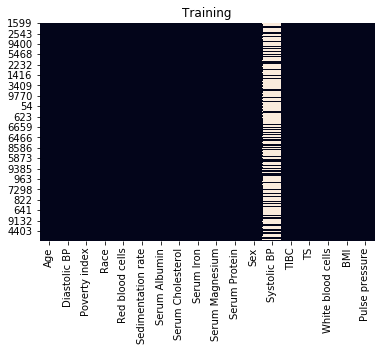

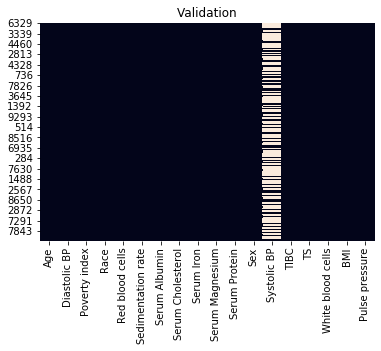

In [7]:
sns.heatmap(X_train.isnull(), cbar=False)
plt.title("Training")
plt.show()

sns.heatmap(X_val.isnull(), cbar=False)
plt.title("Validation")
plt.show()

For each feature, represented as a column, values that are present are shown in black, and missing values are set in a light color.

From this plot, we can see that many values are missing for systolic blood pressure (`Systolic BP`).


<a name='ex-1'></a>
### Exercise 1 - fraction_rows_missing

In the cell below, write a function to compute the fraction of cases with missing data. This will help us decide how we handle this missing data in the future.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> The <code>pandas.DataFrame.isnull()</code> method is helpful in this case.</li>
    <li> Use the <code>pandas.DataFrame.any()</code> method and set the <code>axis</code> parameter.</li>
    <li> Divide the total number of rows with missing data by the total number of rows. Remember that in Python, <code>True</code> values are equal to 1.</li>
</ul>
</p>

In [30]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def fraction_rows_missing(df):
    '''
    Return percent of rows with any missing
    data in the dataframe. 
    
    Input:
        df (dataframe): a pandas dataframe with potentially missing data
    Output:
        frac_missing (float): fraction of rows with missing data
    '''
    ### START CODE HERE (REPLACE 'None' with your code) ###
    return sum(df.isnull().any(axis=1))/len(df)
    ### END CODE HERE ###

In [31]:
### test cell ex1 - do not modify this test cell   
fraction_rows_missing_test(fraction_rows_missing, X_train, X_val, X_test)

Example dataframe:

      a    b
0  NaN  1.0
1  1.0  NaN
2  1.0  0.0
3  NaN  1.0 

Computed fraction missing:  0.75
Fraction of rows missing from X_train:  0.6986594132504371
Fraction of rows missing from X_val:  0.703962703962704
Fraction of rows missing from X_test:  0.0
 All tests passed.


#### Expected Output:
```
Computed fraction missing:  0.75
Fraction of rows missing from X_train:  0.6986594132504371
Fraction of rows missing from X_val:  0.703962703962704
Fraction of rows missing from X_test:  0.0
 All tests passed.
``` 

We see that our train and validation sets have missing values, but luckily our test set has complete cases.

As a first pass, we will begin with a **complete case analysis**, dropping all of the rows with any missing data. Run the following cell to drop these rows from our train and validation sets. 

In [32]:
X_train_dropped = X_train.dropna(axis='rows')
y_train_dropped = y_train.loc[X_train_dropped.index]
X_val_dropped = X_val.dropna(axis='rows')
y_val_dropped = y_val.loc[X_val_dropped.index]

### Notice the new shape of X
print("X_train_dropped shape: {}".format(X_train_dropped.shape))
X_train_dropped.head() 

X_train_dropped shape: (1551, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
2794,72.0,96.0,154.0,2.0,43.4,23.0,4.3,265.0,106.0,1.66,6.8,2.0,208.0,301.0,35.2,6.0,33.394319,112.0
5856,67.0,94.0,114.0,1.0,43.8,12.0,3.7,178.0,73.0,1.85,7.0,1.0,140.0,311.0,23.5,4.3,17.481227,46.0
9374,68.0,80.0,201.0,1.0,46.2,20.0,4.1,223.0,204.0,1.54,7.2,1.0,140.0,275.0,74.2,17.2,20.690581,60.0
8819,68.0,80.0,651.0,1.0,47.7,16.0,4.3,178.0,168.0,1.97,7.3,1.0,102.0,339.0,49.6,10.2,27.719091,22.0
7331,73.0,88.0,68.0,2.0,42.1,19.0,3.6,215.0,64.0,1.59,5.7,2.0,190.0,334.0,19.2,6.6,31.880432,102.0


<a name='3'></a>
## 3. Decision Trees

Having just learned about decision trees, you choose to use a decision tree classifier. Use scikit-learn to build a decision tree for the hospital dataset using the train set.

In [33]:
dt = DecisionTreeClassifier(max_depth=None, random_state=10)
dt.fit(X_train_dropped, y_train_dropped)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=10, splitter='best')

Next we will evaluate our model. We'll use C-Index for evaluation.

> Remember from lesson 4 of week 1 that the C-Index evaluates the ability of a model to differentiate between different classes, by quantifying how often, when considering all pairs of patients (A, B), the model says that patient A has a higher risk score than patient B when, in the observed data, patient A actually died and patient B actually lived. In our case, our model is a binary classifier, where each risk score is either 1 (the model predicts that the patient will die) or 0 (the patient will live).
>
> More formally, defining _permissible pairs_ of patients as pairs where the outcomes are different, _concordant pairs_ as permissible pairs where the patient that died had a higher risk score (i.e. our model predicted 1 for the patient that died and 0 for the one that lived), and _ties_ as permissible pairs where the risk scores were equal (i.e. our model predicted 1 for both patients or 0 for both patients), the C-Index is equal to:
>
> $$\text{C-Index} = \frac{\#\text{concordant pairs} + 0.5\times \#\text{ties}}{\#\text{permissible pairs}}$$

Run the next cell to compute the C-Index on the train and validation set (we've given you an implementation this time).

In [34]:
y_train_preds = dt.predict_proba(X_train_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_preds)}")


y_val_preds = dt.predict_proba(X_val_dropped)[:, 1]
print(f"Val C-Index: {cindex(y_val_dropped.values, y_val_preds)}")

Train C-Index: 1.0
Val C-Index: 0.5629321808510638


Unfortunately your tree seems to be overfitting: it fits the training data so closely that it doesn't generalize well to other samples such as those from the validation set.

> The training C-index comes out to 1.0 because, when initializing `DecisionTreeClasifier`, we have left `max_depth` and `min_samples_split` unspecified. The resulting decision tree will therefore keep splitting as far as it can, which pretty much guarantees a pure fit to the training data.

To handle this, you can change some of the hyperparameters of our tree.

<a name='ex-2'></a>
### Exercise 2 - dt_hyperparams

Try and find a set of hyperparameters that improves the generalization to the validation set and recompute the C-index. If you do it right, you should get C-index above 0.6 for the validation set. 

You can refer to the documentation for the sklearn [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> Try limiting the depth of the tree (max_depth).</li>
</ul>
</p>

In [62]:
# Experiment with different hyperparameters for the DecisionTreeClassifier
# until you get a c-index above 0.6 for the validation set
dt_hyperparams = {
    # set your own hyperparameters below, such as 'min_samples_split': 1

    ### START CODE HERE ###
    
    'max_depth': 3,
    'min_samples_split': 100
    
    ### END CODE HERE ###
}


Run the next cell to fit and evaluate the regularized tree.

In [63]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
dt_reg = DecisionTreeClassifier(**dt_hyperparams, random_state=10)
dt_reg.fit(X_train_dropped, y_train_dropped)

y_train_preds = dt_reg.predict_proba(X_train_dropped)[:, 1]
y_val_preds = dt_reg.predict_proba(X_val_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_preds)}")
print(f"Val C-Index (expected > 0.6): {cindex(y_val_dropped.values, y_val_preds)}")

Train C-Index: 0.688738755448391
Val C-Index (expected > 0.6): 0.6302692819148936


#### Expected Output:
```
Train C-Index > 0.6
Val C-Index > 0.6
```

If your output is not greater than `0.6`, try changing and tweaking your hyperparameters in `Ex 2`.

If you used a low `max_depth` you can print the entire tree. This allows for easy interpretability. Run the next cell to print the tree splits. 

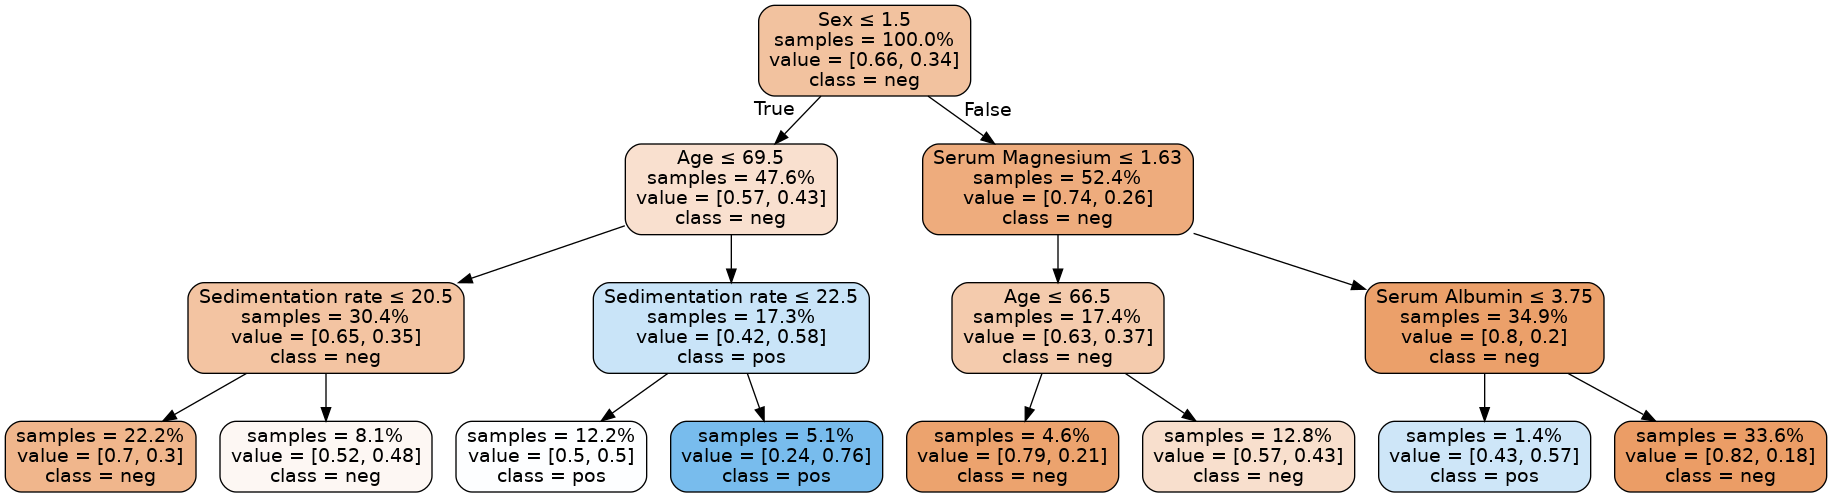

In [64]:
dot_data = StringIO()
export_graphviz(dt_reg, feature_names=X_train_dropped.columns, out_file=dot_data,  
                filled=True, rounded=True, proportion=True, special_characters=True,
                impurity=False, class_names=['neg', 'pos'], precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

> **Overfitting, underfitting, and the bias-variance tradeoff**
>
> If you tested several values of `max_depth`, you may have seen that a value of `3` gives training and validation C-Indices of about `0.689` and `0.630`, and that a `max_depth` of `2` gives better agreement with values of about `0.653` and `0.607`. In the latter case, we have further reduced overfitting, at the cost of a minor loss in predictive performance.
>
> Contrast this with a `max_depth` value of `1`, which results in C-Indices of about `0.597` for the training set and `0.598` for the validation set: we have eliminated overfitting but with a much stronger degradation of predictive performance.
>
> Lower predictive performance on the training and validation sets is indicative of the model _underfitting_ the data: it neither learns enough from the training data nor is able to generalize to unseen data (the validation data in our case).
>
> Finding a model that minimizes and acceptably balances underfitting and overfitting (e.g. selecting the model with a `max_depth` of `2` over the other values) is a common problem in machine learning that is known as the _bias-variance tradeoff_.

<a name='4'></a>
## 4. Random Forests

No matter how you choose hyperparameters, a single decision tree is prone to overfitting. To solve this problem, you can try **random forests**, which combine predictions from many different trees to create a robust classifier. 

As before, we will use scikit-learn to build a random forest for the data. We will use the default hyperparameters.

In [65]:
rf = RandomForestClassifier(n_estimators=100, random_state=10)
rf.fit(X_train_dropped, y_train_dropped)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

Now compute and report the C-Index for the random forest on the training and validation set.

In [66]:
y_train_rf_preds = rf.predict_proba(X_train_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_rf_preds)}")

y_val_rf_preds = rf.predict_proba(X_val_dropped)[:, 1]
print(f"Val C-Index: {cindex(y_val_dropped.values, y_val_rf_preds)}")

Train C-Index: 1.0
Val C-Index: 0.6660488696808511


Training a random forest with the default hyperparameters results in a model that has better predictive performance than individual decision trees as in the previous section, but this model is overfitting.

We therefore need to tune (or optimize) the hyperparameters, to find a model that both has good predictive performance and minimizes overfitting.

The hyperparameters we choose to adjust will be:

- `n_estimators`: the number of trees used in the forest.
- `max_depth`: the maximum depth of each tree.
- `min_samples_leaf`: the minimum number (if `int`) or proportion (if `float`) of samples in a leaf.

The approach we implement to tune the hyperparameters is known as a grid search:

- We define a set of possible values for each of the target hyperparameters.

- A model is trained and evaluated for every possible combination of hyperparameters.

- The best performing set of hyperparameters is returned.

The cell below implements a hyperparameter grid search, using the C-Index to evaluate each tested model.

In [67]:
def holdout_grid_search(clf, X_train_hp, y_train_hp, X_val_hp, y_val_hp, hyperparams, fixed_hyperparams={}):
    '''
    Conduct hyperparameter grid search on hold out validation set. Use holdout validation.
    Hyperparameters are input as a dictionary mapping each hyperparameter name to the
    range of values they should iterate over. Use the cindex function as your evaluation
    function.

    Input:
        clf: sklearn classifier
        X_train_hp (dataframe): dataframe for training set input variables
        y_train_hp (dataframe): dataframe for training set targets
        X_val_hp (dataframe): dataframe for validation set input variables
        y_val_hp (dataframe): dataframe for validation set targets
        hyperparams (dict): hyperparameter dictionary mapping hyperparameter
                            names to range of values for grid search
        fixed_hyperparams (dict): dictionary of fixed hyperparameters that
                                  are not included in the grid search

    Output:
        best_estimator (sklearn classifier): fitted sklearn classifier with best performance on
                                             validation set
        best_hyperparams (dict): hyperparameter dictionary mapping hyperparameter
                                 names to values in best_estimator
    '''
    best_estimator = None
    best_hyperparams = {}
    
    # hold best running score
    best_score = 0.0

    # get list of param values
    lists = hyperparams.values()
    
    # get all param combinations
    param_combinations = list(itertools.product(*lists))
    total_param_combinations = len(param_combinations)

    # iterate through param combinations
    for i, params in enumerate(param_combinations, 1):
        # fill param dict with params
        param_dict = {}
        for param_index, param_name in enumerate(hyperparams):
            param_dict[param_name] = params[param_index]
            
        # create estimator with specified params
        estimator = clf(**param_dict, **fixed_hyperparams)

        # fit estimator
        estimator.fit(X_train_hp, y_train_hp)
        
        # get predictions on validation set
        preds = estimator.predict_proba(X_val_hp)
        
        # compute cindex for predictions
        estimator_score = cindex(y_val_hp, preds[:,1])

        print(f'[{i}/{total_param_combinations}] {param_dict}')
        print(f'Val C-Index: {estimator_score}\n')

        # if new high score, update high score, best estimator
        # and best params 
        if estimator_score >= best_score:
                best_score = estimator_score
                best_estimator = estimator
                best_hyperparams = param_dict

    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)
    
    return best_estimator, best_hyperparams

<a name='ex-3'></a>
### Exercise 3 - random_forest_grid_search

In the cell below, define the values you want to run the hyperparameter grid search on, and run the cell to find the best-performing set of hyperparameters.

Your objective is to get a C-Index above `0.6` on both the train and validation set.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>n_estimators: try values greater than 100</li>
    <li>max_depth: try values in the range 1 to 100</li>
    <li>min_samples_leaf: try float values below .5 and/or int values greater than 2</li>
</ul>
</p>

In [79]:
def random_forest_grid_search(X_train_dropped, y_train_dropped, X_val_dropped, y_val_dropped):

    # Define ranges for the chosen random forest hyperparameters 
    hyperparams = {
        
        ### START CODE HERE (REPLACE array values with your code) ###

        # how many trees should be in the forest (int)
        'n_estimators': [180],

        # the maximum depth of trees in the forest (int)
        
        'max_depth': [98],
        
        # the minimum number of samples in a leaf as a fraction
        # of the total number of samples in the training set
        # Can be int (in which case that is the minimum number)
        # or float (in which case the minimum is that fraction of the
        # number of training set samples)
        'min_samples_leaf': [0.05],

        ### END CODE HERE ###
    }

    
    fixed_hyperparams = {
        'random_state': 10,
    }
    
    rf = RandomForestClassifier

    best_rf, best_hyperparams = holdout_grid_search(rf, X_train_dropped, y_train_dropped,
                                                    X_val_dropped, y_val_dropped, hyperparams,
                                                    fixed_hyperparams)

    print(f"Best hyperparameters:\n{best_hyperparams}")

    
    y_train_best = best_rf.predict_proba(X_train_dropped)[:, 1]
    print(f"Train C-Index: {cindex(y_train_dropped, y_train_best)}")

    y_val_best = best_rf.predict_proba(X_val_dropped)[:, 1]
    print(f"Val C-Index: {cindex(y_val_dropped, y_val_best)}")
    
    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)
    
    return best_rf, best_hyperparams

In [80]:
best_rf, best_hyperparams = random_forest_grid_search(X_train_dropped, y_train_dropped, X_val_dropped, y_val_dropped)

[1/6840] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.05}
Val C-Index: 0.665483710106383

[2/6840] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.1}
Val C-Index: 0.6589345079787234

[3/6840] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6550116356382979

[4/6840] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.2}
Val C-Index: 0.6433011968085106

[5/6840] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.25}
Val C-Index: 0.641439494680851

[6/6840] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6175365691489362

[7/6840] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[8/6840] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[9/6840] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[10/6840] {'n_estimators': 10, 'max_depth': 22, 'mi

[78/6840] {'n_estimators': 10, 'max_depth': 36, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6175365691489362

[79/6840] {'n_estimators': 10, 'max_depth': 36, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[80/6840] {'n_estimators': 10, 'max_depth': 36, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[81/6840] {'n_estimators': 10, 'max_depth': 36, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[82/6840] {'n_estimators': 10, 'max_depth': 38, 'min_samples_leaf': 0.05}
Val C-Index: 0.665483710106383

[83/6840] {'n_estimators': 10, 'max_depth': 38, 'min_samples_leaf': 0.1}
Val C-Index: 0.6589345079787234

[84/6840] {'n_estimators': 10, 'max_depth': 38, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6550116356382979

[85/6840] {'n_estimators': 10, 'max_depth': 38, 'min_samples_leaf': 0.2}
Val C-Index: 0.6433011968085106

[86/6840] {'n_estimators': 10, 'max_depth': 38, 'min_samples_leaf': 0.25}
Val C-Index: 0.641439494680851

[87/6840] {'n_estimators': 10, 'max_depth'

[158/6840] {'n_estimators': 10, 'max_depth': 54, 'min_samples_leaf': 0.25}
Val C-Index: 0.641439494680851

[159/6840] {'n_estimators': 10, 'max_depth': 54, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6175365691489362

[160/6840] {'n_estimators': 10, 'max_depth': 54, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[161/6840] {'n_estimators': 10, 'max_depth': 54, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[162/6840] {'n_estimators': 10, 'max_depth': 54, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[163/6840] {'n_estimators': 10, 'max_depth': 56, 'min_samples_leaf': 0.05}
Val C-Index: 0.665483710106383

[164/6840] {'n_estimators': 10, 'max_depth': 56, 'min_samples_leaf': 0.1}
Val C-Index: 0.6589345079787234

[165/6840] {'n_estimators': 10, 'max_depth': 56, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6550116356382979

[166/6840] {'n_estimators': 10, 'max_depth': 56, 'min_samples_leaf': 0.2}
Val C-Index: 0.6433011968085106

[167/6840] {'n_estimators': 10, '

[235/6840] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.05}
Val C-Index: 0.665483710106383

[236/6840] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.1}
Val C-Index: 0.6589345079787234

[237/6840] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6550116356382979

[238/6840] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.2}
Val C-Index: 0.6433011968085106

[239/6840] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.25}
Val C-Index: 0.641439494680851

[240/6840] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6175365691489362

[241/6840] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[242/6840] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[243/6840] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[244/6840] {'n_estimators': 10, '

[312/6840] {'n_estimators': 10, 'max_depth': 88, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6175365691489362

[313/6840] {'n_estimators': 10, 'max_depth': 88, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[314/6840] {'n_estimators': 10, 'max_depth': 88, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[315/6840] {'n_estimators': 10, 'max_depth': 88, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[316/6840] {'n_estimators': 10, 'max_depth': 90, 'min_samples_leaf': 0.05}
Val C-Index: 0.665483710106383

[317/6840] {'n_estimators': 10, 'max_depth': 90, 'min_samples_leaf': 0.1}
Val C-Index: 0.6589345079787234

[318/6840] {'n_estimators': 10, 'max_depth': 90, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6550116356382979

[319/6840] {'n_estimators': 10, 'max_depth': 90, 'min_samples_leaf': 0.2}
Val C-Index: 0.6433011968085106

[320/6840] {'n_estimators': 10, 'max_depth': 90, 'min_samples_leaf': 0.25}
Val C-Index: 0.641439494680851

[321/6840] {'n_estimators': 10, '

[391/6840] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.2}
Val C-Index: 0.6671293218085106

[392/6840] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.25}
Val C-Index: 0.6692902260638298

[393/6840] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6656582446808511

[394/6840] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[395/6840] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[396/6840] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[397/6840] {'n_estimators': 20, 'max_depth': 28, 'min_samples_leaf': 0.05}
Val C-Index: 0.664561170212766

[398/6840] {'n_estimators': 20, 'max_depth': 28, 'min_samples_leaf': 0.1}
Val C-Index: 0.6705535239361702

[399/6840] {'n_estimators': 20, 'max_depth': 28, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6758394281914893

[400/6840] {'n_estimators': 20, 

[469/6840] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.05}
Val C-Index: 0.664561170212766

[470/6840] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.1}
Val C-Index: 0.6705535239361702

[471/6840] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6758394281914893

[472/6840] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.2}
Val C-Index: 0.6671293218085106

[473/6840] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.25}
Val C-Index: 0.6692902260638298

[474/6840] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6656582446808511

[475/6840] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[476/6840] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[477/6840] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[478/6840] {'n_estimators': 20, 

[547/6840] {'n_estimators': 20, 'max_depth': 60, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[548/6840] {'n_estimators': 20, 'max_depth': 60, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[549/6840] {'n_estimators': 20, 'max_depth': 60, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[550/6840] {'n_estimators': 20, 'max_depth': 62, 'min_samples_leaf': 0.05}
Val C-Index: 0.664561170212766

[551/6840] {'n_estimators': 20, 'max_depth': 62, 'min_samples_leaf': 0.1}
Val C-Index: 0.6705535239361702

[552/6840] {'n_estimators': 20, 'max_depth': 62, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6758394281914893

[553/6840] {'n_estimators': 20, 'max_depth': 62, 'min_samples_leaf': 0.2}
Val C-Index: 0.6671293218085106

[554/6840] {'n_estimators': 20, 'max_depth': 62, 'min_samples_leaf': 0.25}
Val C-Index: 0.6692902260638298

[555/6840] {'n_estimators': 20, 'max_depth': 62, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6656582446808511

[556/6840] {'n_estimators': 20, 

[625/6840] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.2}
Val C-Index: 0.6671293218085106

[626/6840] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.25}
Val C-Index: 0.6692902260638298

[627/6840] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6656582446808511

[628/6840] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[629/6840] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[630/6840] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[631/6840] {'n_estimators': 20, 'max_depth': 80, 'min_samples_leaf': 0.05}
Val C-Index: 0.664561170212766

[632/6840] {'n_estimators': 20, 'max_depth': 80, 'min_samples_leaf': 0.1}
Val C-Index: 0.6705535239361702

[633/6840] {'n_estimators': 20, 'max_depth': 80, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6758394281914893

[634/6840] {'n_estimators': 20, 

[703/6840] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.05}
Val C-Index: 0.664561170212766

[704/6840] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.1}
Val C-Index: 0.6705535239361702

[705/6840] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6758394281914893

[706/6840] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.2}
Val C-Index: 0.6671293218085106

[707/6840] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.25}
Val C-Index: 0.6692902260638298

[708/6840] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6656582446808511

[709/6840] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[710/6840] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[711/6840] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[712/6840] {'n_estimators': 20, 

[782/6840] {'n_estimators': 30, 'max_depth': 32, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[783/6840] {'n_estimators': 30, 'max_depth': 32, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[784/6840] {'n_estimators': 30, 'max_depth': 34, 'min_samples_leaf': 0.05}
Val C-Index: 0.6700797872340426

[785/6840] {'n_estimators': 30, 'max_depth': 34, 'min_samples_leaf': 0.1}
Val C-Index: 0.6674867021276596

[786/6840] {'n_estimators': 30, 'max_depth': 34, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6672872340425532

[787/6840] {'n_estimators': 30, 'max_depth': 34, 'min_samples_leaf': 0.2}
Val C-Index: 0.6614361702127659

[788/6840] {'n_estimators': 30, 'max_depth': 34, 'min_samples_leaf': 0.25}
Val C-Index: 0.664278590425532

[789/6840] {'n_estimators': 30, 'max_depth': 34, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6559341755319149

[790/6840] {'n_estimators': 30, 'max_depth': 34, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[791/6840] {'n_estimators': 30, 

[860/6840] {'n_estimators': 30, 'max_depth': 50, 'min_samples_leaf': 0.25}
Val C-Index: 0.664278590425532

[861/6840] {'n_estimators': 30, 'max_depth': 50, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6559341755319149

[862/6840] {'n_estimators': 30, 'max_depth': 50, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[863/6840] {'n_estimators': 30, 'max_depth': 50, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[864/6840] {'n_estimators': 30, 'max_depth': 50, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[865/6840] {'n_estimators': 30, 'max_depth': 52, 'min_samples_leaf': 0.05}
Val C-Index: 0.6700797872340426

[866/6840] {'n_estimators': 30, 'max_depth': 52, 'min_samples_leaf': 0.1}
Val C-Index: 0.6674867021276596

[867/6840] {'n_estimators': 30, 'max_depth': 52, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6672872340425532

[868/6840] {'n_estimators': 30, 'max_depth': 52, 'min_samples_leaf': 0.2}
Val C-Index: 0.6614361702127659

[869/6840] {'n_estimators': 30, 

[937/6840] {'n_estimators': 30, 'max_depth': 68, 'min_samples_leaf': 0.05}
Val C-Index: 0.6700797872340426

[938/6840] {'n_estimators': 30, 'max_depth': 68, 'min_samples_leaf': 0.1}
Val C-Index: 0.6674867021276596

[939/6840] {'n_estimators': 30, 'max_depth': 68, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6672872340425532

[940/6840] {'n_estimators': 30, 'max_depth': 68, 'min_samples_leaf': 0.2}
Val C-Index: 0.6614361702127659

[941/6840] {'n_estimators': 30, 'max_depth': 68, 'min_samples_leaf': 0.25}
Val C-Index: 0.664278590425532

[942/6840] {'n_estimators': 30, 'max_depth': 68, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6559341755319149

[943/6840] {'n_estimators': 30, 'max_depth': 68, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[944/6840] {'n_estimators': 30, 'max_depth': 68, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[945/6840] {'n_estimators': 30, 'max_depth': 68, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[946/6840] {'n_estimators': 30, 

[1013/6840] {'n_estimators': 30, 'max_depth': 84, 'min_samples_leaf': 0.25}
Val C-Index: 0.664278590425532

[1014/6840] {'n_estimators': 30, 'max_depth': 84, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6559341755319149

[1015/6840] {'n_estimators': 30, 'max_depth': 84, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1016/6840] {'n_estimators': 30, 'max_depth': 84, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1017/6840] {'n_estimators': 30, 'max_depth': 84, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1018/6840] {'n_estimators': 30, 'max_depth': 86, 'min_samples_leaf': 0.05}
Val C-Index: 0.6700797872340426

[1019/6840] {'n_estimators': 30, 'max_depth': 86, 'min_samples_leaf': 0.1}
Val C-Index: 0.6674867021276596

[1020/6840] {'n_estimators': 30, 'max_depth': 86, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6672872340425532

[1021/6840] {'n_estimators': 30, 'max_depth': 86, 'min_samples_leaf': 0.2}
Val C-Index: 0.6614361702127659

[1022/6840] {'n_estimat

[1089/6840] {'n_estimators': 40, 'max_depth': 20, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1090/6840] {'n_estimators': 40, 'max_depth': 22, 'min_samples_leaf': 0.05}
Val C-Index: 0.675033244680851

[1091/6840] {'n_estimators': 40, 'max_depth': 22, 'min_samples_leaf': 0.1}
Val C-Index: 0.6687001329787234

[1092/6840] {'n_estimators': 40, 'max_depth': 22, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6721077127659575

[1093/6840] {'n_estimators': 40, 'max_depth': 22, 'min_samples_leaf': 0.2}
Val C-Index: 0.6629321808510639

[1094/6840] {'n_estimators': 40, 'max_depth': 22, 'min_samples_leaf': 0.25}
Val C-Index: 0.6679521276595745

[1095/6840] {'n_estimators': 40, 'max_depth': 22, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6684341755319149

[1096/6840] {'n_estimators': 40, 'max_depth': 22, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1097/6840] {'n_estimators': 40, 'max_depth': 22, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1098/6840] {'n_estimat

[1165/6840] {'n_estimators': 40, 'max_depth': 38, 'min_samples_leaf': 0.2}
Val C-Index: 0.6629321808510639

[1166/6840] {'n_estimators': 40, 'max_depth': 38, 'min_samples_leaf': 0.25}
Val C-Index: 0.6679521276595745

[1167/6840] {'n_estimators': 40, 'max_depth': 38, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6684341755319149

[1168/6840] {'n_estimators': 40, 'max_depth': 38, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1169/6840] {'n_estimators': 40, 'max_depth': 38, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1170/6840] {'n_estimators': 40, 'max_depth': 38, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1171/6840] {'n_estimators': 40, 'max_depth': 40, 'min_samples_leaf': 0.05}
Val C-Index: 0.675033244680851

[1172/6840] {'n_estimators': 40, 'max_depth': 40, 'min_samples_leaf': 0.1}
Val C-Index: 0.6687001329787234

[1173/6840] {'n_estimators': 40, 'max_depth': 40, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6721077127659575

[1174/6840] {'n_estimat

[1241/6840] {'n_estimators': 40, 'max_depth': 54, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1242/6840] {'n_estimators': 40, 'max_depth': 54, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1243/6840] {'n_estimators': 40, 'max_depth': 56, 'min_samples_leaf': 0.05}
Val C-Index: 0.675033244680851

[1244/6840] {'n_estimators': 40, 'max_depth': 56, 'min_samples_leaf': 0.1}
Val C-Index: 0.6687001329787234

[1245/6840] {'n_estimators': 40, 'max_depth': 56, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6721077127659575

[1246/6840] {'n_estimators': 40, 'max_depth': 56, 'min_samples_leaf': 0.2}
Val C-Index: 0.6629321808510639

[1247/6840] {'n_estimators': 40, 'max_depth': 56, 'min_samples_leaf': 0.25}
Val C-Index: 0.6679521276595745

[1248/6840] {'n_estimators': 40, 'max_depth': 56, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6684341755319149

[1249/6840] {'n_estimators': 40, 'max_depth': 56, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1250/6840] {'n_estimat

[1317/6840] {'n_estimators': 40, 'max_depth': 72, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6721077127659575

[1318/6840] {'n_estimators': 40, 'max_depth': 72, 'min_samples_leaf': 0.2}
Val C-Index: 0.6629321808510639

[1319/6840] {'n_estimators': 40, 'max_depth': 72, 'min_samples_leaf': 0.25}
Val C-Index: 0.6679521276595745

[1320/6840] {'n_estimators': 40, 'max_depth': 72, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6684341755319149

[1321/6840] {'n_estimators': 40, 'max_depth': 72, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1322/6840] {'n_estimators': 40, 'max_depth': 72, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1323/6840] {'n_estimators': 40, 'max_depth': 72, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1324/6840] {'n_estimators': 40, 'max_depth': 74, 'min_samples_leaf': 0.05}
Val C-Index: 0.675033244680851

[1325/6840] {'n_estimators': 40, 'max_depth': 74, 'min_samples_leaf': 0.1}
Val C-Index: 0.6687001329787234

[1326/6840] {'n_estimat

[1393/6840] {'n_estimators': 40, 'max_depth': 88, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1394/6840] {'n_estimators': 40, 'max_depth': 88, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1395/6840] {'n_estimators': 40, 'max_depth': 88, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1396/6840] {'n_estimators': 40, 'max_depth': 90, 'min_samples_leaf': 0.05}
Val C-Index: 0.675033244680851

[1397/6840] {'n_estimators': 40, 'max_depth': 90, 'min_samples_leaf': 0.1}
Val C-Index: 0.6687001329787234

[1398/6840] {'n_estimators': 40, 'max_depth': 90, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6721077127659575

[1399/6840] {'n_estimators': 40, 'max_depth': 90, 'min_samples_leaf': 0.2}
Val C-Index: 0.6629321808510639

[1400/6840] {'n_estimators': 40, 'max_depth': 90, 'min_samples_leaf': 0.25}
Val C-Index: 0.6679521276595745

[1401/6840] {'n_estimators': 40, 'max_depth': 90, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6684341755319149

[1402/6840] {'n_estimat

[1470/6840] {'n_estimators': 50, 'max_depth': 26, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6720744680851064

[1471/6840] {'n_estimators': 50, 'max_depth': 26, 'min_samples_leaf': 0.2}
Val C-Index: 0.6638297872340425

[1472/6840] {'n_estimators': 50, 'max_depth': 26, 'min_samples_leaf': 0.25}
Val C-Index: 0.6685837765957446

[1473/6840] {'n_estimators': 50, 'max_depth': 26, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6631648936170212

[1474/6840] {'n_estimators': 50, 'max_depth': 26, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1475/6840] {'n_estimators': 50, 'max_depth': 26, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1476/6840] {'n_estimators': 50, 'max_depth': 26, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1477/6840] {'n_estimators': 50, 'max_depth': 28, 'min_samples_leaf': 0.05}
Val C-Index: 0.6755817819148936

[1478/6840] {'n_estimators': 50, 'max_depth': 28, 'min_samples_leaf': 0.1}
Val C-Index: 0.6675365691489362

[1479/6840] {'n_estima

[1546/6840] {'n_estimators': 50, 'max_depth': 42, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1547/6840] {'n_estimators': 50, 'max_depth': 42, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1548/6840] {'n_estimators': 50, 'max_depth': 42, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1549/6840] {'n_estimators': 50, 'max_depth': 44, 'min_samples_leaf': 0.05}
Val C-Index: 0.6755817819148936

[1550/6840] {'n_estimators': 50, 'max_depth': 44, 'min_samples_leaf': 0.1}
Val C-Index: 0.6675365691489362

[1551/6840] {'n_estimators': 50, 'max_depth': 44, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6720744680851064

[1552/6840] {'n_estimators': 50, 'max_depth': 44, 'min_samples_leaf': 0.2}
Val C-Index: 0.6638297872340425

[1553/6840] {'n_estimators': 50, 'max_depth': 44, 'min_samples_leaf': 0.25}
Val C-Index: 0.6685837765957446

[1554/6840] {'n_estimators': 50, 'max_depth': 44, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6631648936170212

[1555/6840] {'n_estima

[1623/6840] {'n_estimators': 50, 'max_depth': 60, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6720744680851064

[1624/6840] {'n_estimators': 50, 'max_depth': 60, 'min_samples_leaf': 0.2}
Val C-Index: 0.6638297872340425

[1625/6840] {'n_estimators': 50, 'max_depth': 60, 'min_samples_leaf': 0.25}
Val C-Index: 0.6685837765957446

[1626/6840] {'n_estimators': 50, 'max_depth': 60, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6631648936170212

[1627/6840] {'n_estimators': 50, 'max_depth': 60, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1628/6840] {'n_estimators': 50, 'max_depth': 60, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1629/6840] {'n_estimators': 50, 'max_depth': 60, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1630/6840] {'n_estimators': 50, 'max_depth': 62, 'min_samples_leaf': 0.05}
Val C-Index: 0.6755817819148936

[1631/6840] {'n_estimators': 50, 'max_depth': 62, 'min_samples_leaf': 0.1}
Val C-Index: 0.6675365691489362

[1632/6840] {'n_estima

[1699/6840] {'n_estimators': 50, 'max_depth': 76, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1700/6840] {'n_estimators': 50, 'max_depth': 76, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1701/6840] {'n_estimators': 50, 'max_depth': 76, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1702/6840] {'n_estimators': 50, 'max_depth': 78, 'min_samples_leaf': 0.05}
Val C-Index: 0.6755817819148936

[1703/6840] {'n_estimators': 50, 'max_depth': 78, 'min_samples_leaf': 0.1}
Val C-Index: 0.6675365691489362

[1704/6840] {'n_estimators': 50, 'max_depth': 78, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6720744680851064

[1705/6840] {'n_estimators': 50, 'max_depth': 78, 'min_samples_leaf': 0.2}
Val C-Index: 0.6638297872340425

[1706/6840] {'n_estimators': 50, 'max_depth': 78, 'min_samples_leaf': 0.25}
Val C-Index: 0.6685837765957446

[1707/6840] {'n_estimators': 50, 'max_depth': 78, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6631648936170212

[1708/6840] {'n_estima

[1775/6840] {'n_estimators': 50, 'max_depth': 94, 'min_samples_leaf': 0.1}
Val C-Index: 0.6675365691489362

[1776/6840] {'n_estimators': 50, 'max_depth': 94, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6720744680851064

[1777/6840] {'n_estimators': 50, 'max_depth': 94, 'min_samples_leaf': 0.2}
Val C-Index: 0.6638297872340425

[1778/6840] {'n_estimators': 50, 'max_depth': 94, 'min_samples_leaf': 0.25}
Val C-Index: 0.6685837765957446

[1779/6840] {'n_estimators': 50, 'max_depth': 94, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6631648936170212

[1780/6840] {'n_estimators': 50, 'max_depth': 94, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1781/6840] {'n_estimators': 50, 'max_depth': 94, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1782/6840] {'n_estimators': 50, 'max_depth': 94, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1783/6840] {'n_estimators': 50, 'max_depth': 96, 'min_samples_leaf': 0.05}
Val C-Index: 0.6755817819148936

[1784/6840] {'n_estima

[1851/6840] {'n_estimators': 60, 'max_depth': 30, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6659740691489362

[1852/6840] {'n_estimators': 60, 'max_depth': 30, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1853/6840] {'n_estimators': 60, 'max_depth': 30, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1854/6840] {'n_estimators': 60, 'max_depth': 30, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1855/6840] {'n_estimators': 60, 'max_depth': 32, 'min_samples_leaf': 0.05}
Val C-Index: 0.6778922872340426

[1856/6840] {'n_estimators': 60, 'max_depth': 32, 'min_samples_leaf': 0.1}
Val C-Index: 0.6689328457446808

[1857/6840] {'n_estimators': 60, 'max_depth': 32, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6750997340425532

[1858/6840] {'n_estimators': 60, 'max_depth': 32, 'min_samples_leaf': 0.2}
Val C-Index: 0.6711602393617021

[1859/6840] {'n_estimators': 60, 'max_depth': 32, 'min_samples_leaf': 0.25}
Val C-Index: 0.6707613031914894

[1860/6840] {'n_estima

[1927/6840] {'n_estimators': 60, 'max_depth': 48, 'min_samples_leaf': 0.05}
Val C-Index: 0.6778922872340426

[1928/6840] {'n_estimators': 60, 'max_depth': 48, 'min_samples_leaf': 0.1}
Val C-Index: 0.6689328457446808

[1929/6840] {'n_estimators': 60, 'max_depth': 48, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6750997340425532

[1930/6840] {'n_estimators': 60, 'max_depth': 48, 'min_samples_leaf': 0.2}
Val C-Index: 0.6711602393617021

[1931/6840] {'n_estimators': 60, 'max_depth': 48, 'min_samples_leaf': 0.25}
Val C-Index: 0.6707613031914894

[1932/6840] {'n_estimators': 60, 'max_depth': 48, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6659740691489362

[1933/6840] {'n_estimators': 60, 'max_depth': 48, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1934/6840] {'n_estimators': 60, 'max_depth': 48, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1935/6840] {'n_estimators': 60, 'max_depth': 48, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1936/6840] {'n_estima

[2004/6840] {'n_estimators': 60, 'max_depth': 64, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6659740691489362

[2005/6840] {'n_estimators': 60, 'max_depth': 64, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2006/6840] {'n_estimators': 60, 'max_depth': 64, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2007/6840] {'n_estimators': 60, 'max_depth': 64, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2008/6840] {'n_estimators': 60, 'max_depth': 66, 'min_samples_leaf': 0.05}
Val C-Index: 0.6778922872340426

[2009/6840] {'n_estimators': 60, 'max_depth': 66, 'min_samples_leaf': 0.1}
Val C-Index: 0.6689328457446808

[2010/6840] {'n_estimators': 60, 'max_depth': 66, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6750997340425532

[2011/6840] {'n_estimators': 60, 'max_depth': 66, 'min_samples_leaf': 0.2}
Val C-Index: 0.6711602393617021

[2012/6840] {'n_estimators': 60, 'max_depth': 66, 'min_samples_leaf': 0.25}
Val C-Index: 0.6707613031914894

[2013/6840] {'n_estima

[2080/6840] {'n_estimators': 60, 'max_depth': 82, 'min_samples_leaf': 0.05}
Val C-Index: 0.6778922872340426

[2081/6840] {'n_estimators': 60, 'max_depth': 82, 'min_samples_leaf': 0.1}
Val C-Index: 0.6689328457446808

[2082/6840] {'n_estimators': 60, 'max_depth': 82, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6750997340425532

[2083/6840] {'n_estimators': 60, 'max_depth': 82, 'min_samples_leaf': 0.2}
Val C-Index: 0.6711602393617021

[2084/6840] {'n_estimators': 60, 'max_depth': 82, 'min_samples_leaf': 0.25}
Val C-Index: 0.6707613031914894

[2085/6840] {'n_estimators': 60, 'max_depth': 82, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6659740691489362

[2086/6840] {'n_estimators': 60, 'max_depth': 82, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2087/6840] {'n_estimators': 60, 'max_depth': 82, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2088/6840] {'n_estimators': 60, 'max_depth': 82, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2089/6840] {'n_estima

[2157/6840] {'n_estimators': 60, 'max_depth': 98, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6659740691489362

[2158/6840] {'n_estimators': 60, 'max_depth': 98, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2159/6840] {'n_estimators': 60, 'max_depth': 98, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2160/6840] {'n_estimators': 60, 'max_depth': 98, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2161/6840] {'n_estimators': 70, 'max_depth': 20, 'min_samples_leaf': 0.05}
Val C-Index: 0.6772440159574468

[2162/6840] {'n_estimators': 70, 'max_depth': 20, 'min_samples_leaf': 0.1}
Val C-Index: 0.6671708776595745

[2163/6840] {'n_estimators': 70, 'max_depth': 20, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6709940159574468

[2164/6840] {'n_estimators': 70, 'max_depth': 20, 'min_samples_leaf': 0.2}
Val C-Index: 0.6692320478723405

[2165/6840] {'n_estimators': 70, 'max_depth': 20, 'min_samples_leaf': 0.25}
Val C-Index: 0.6695728058510638

[2166/6840] {'n_estima

[2233/6840] {'n_estimators': 70, 'max_depth': 36, 'min_samples_leaf': 0.05}
Val C-Index: 0.6772440159574468

[2234/6840] {'n_estimators': 70, 'max_depth': 36, 'min_samples_leaf': 0.1}
Val C-Index: 0.6671708776595745

[2235/6840] {'n_estimators': 70, 'max_depth': 36, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6709940159574468

[2236/6840] {'n_estimators': 70, 'max_depth': 36, 'min_samples_leaf': 0.2}
Val C-Index: 0.6692320478723405

[2237/6840] {'n_estimators': 70, 'max_depth': 36, 'min_samples_leaf': 0.25}
Val C-Index: 0.6695728058510638

[2238/6840] {'n_estimators': 70, 'max_depth': 36, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6607214095744681

[2239/6840] {'n_estimators': 70, 'max_depth': 36, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2240/6840] {'n_estimators': 70, 'max_depth': 36, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2241/6840] {'n_estimators': 70, 'max_depth': 36, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2242/6840] {'n_estima

[2309/6840] {'n_estimators': 70, 'max_depth': 52, 'min_samples_leaf': 0.25}
Val C-Index: 0.6695728058510638

[2310/6840] {'n_estimators': 70, 'max_depth': 52, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6607214095744681

[2311/6840] {'n_estimators': 70, 'max_depth': 52, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2312/6840] {'n_estimators': 70, 'max_depth': 52, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2313/6840] {'n_estimators': 70, 'max_depth': 52, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2314/6840] {'n_estimators': 70, 'max_depth': 54, 'min_samples_leaf': 0.05}
Val C-Index: 0.6772440159574468

[2315/6840] {'n_estimators': 70, 'max_depth': 54, 'min_samples_leaf': 0.1}
Val C-Index: 0.6671708776595745

[2316/6840] {'n_estimators': 70, 'max_depth': 54, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6709940159574468

[2317/6840] {'n_estimators': 70, 'max_depth': 54, 'min_samples_leaf': 0.2}
Val C-Index: 0.6692320478723405

[2318/6840] {'n_estima

[2386/6840] {'n_estimators': 70, 'max_depth': 70, 'min_samples_leaf': 0.05}
Val C-Index: 0.6772440159574468

[2387/6840] {'n_estimators': 70, 'max_depth': 70, 'min_samples_leaf': 0.1}
Val C-Index: 0.6671708776595745

[2388/6840] {'n_estimators': 70, 'max_depth': 70, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6709940159574468

[2389/6840] {'n_estimators': 70, 'max_depth': 70, 'min_samples_leaf': 0.2}
Val C-Index: 0.6692320478723405

[2390/6840] {'n_estimators': 70, 'max_depth': 70, 'min_samples_leaf': 0.25}
Val C-Index: 0.6695728058510638

[2391/6840] {'n_estimators': 70, 'max_depth': 70, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6607214095744681

[2392/6840] {'n_estimators': 70, 'max_depth': 70, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2393/6840] {'n_estimators': 70, 'max_depth': 70, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2394/6840] {'n_estimators': 70, 'max_depth': 70, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2395/6840] {'n_estima

[2462/6840] {'n_estimators': 70, 'max_depth': 86, 'min_samples_leaf': 0.25}
Val C-Index: 0.6695728058510638

[2463/6840] {'n_estimators': 70, 'max_depth': 86, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6607214095744681

[2464/6840] {'n_estimators': 70, 'max_depth': 86, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2465/6840] {'n_estimators': 70, 'max_depth': 86, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2466/6840] {'n_estimators': 70, 'max_depth': 86, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2467/6840] {'n_estimators': 70, 'max_depth': 88, 'min_samples_leaf': 0.05}
Val C-Index: 0.6772440159574468

[2468/6840] {'n_estimators': 70, 'max_depth': 88, 'min_samples_leaf': 0.1}
Val C-Index: 0.6671708776595745

[2469/6840] {'n_estimators': 70, 'max_depth': 88, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6709940159574468

[2470/6840] {'n_estimators': 70, 'max_depth': 88, 'min_samples_leaf': 0.2}
Val C-Index: 0.6692320478723405

[2471/6840] {'n_estima

[2538/6840] {'n_estimators': 80, 'max_depth': 22, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2539/6840] {'n_estimators': 80, 'max_depth': 24, 'min_samples_leaf': 0.05}
Val C-Index: 0.6753324468085107

[2540/6840] {'n_estimators': 80, 'max_depth': 24, 'min_samples_leaf': 0.1}
Val C-Index: 0.6657081117021276

[2541/6840] {'n_estimators': 80, 'max_depth': 24, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6677360372340425

[2542/6840] {'n_estimators': 80, 'max_depth': 24, 'min_samples_leaf': 0.2}
Val C-Index: 0.6628656914893617

[2543/6840] {'n_estimators': 80, 'max_depth': 24, 'min_samples_leaf': 0.25}
Val C-Index: 0.666264960106383

[2544/6840] {'n_estimators': 80, 'max_depth': 24, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6574384973404256

[2545/6840] {'n_estimators': 80, 'max_depth': 24, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2546/6840] {'n_estimators': 80, 'max_depth': 24, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2547/6840] {'n_estimat

[2614/6840] {'n_estimators': 80, 'max_depth': 40, 'min_samples_leaf': 0.2}
Val C-Index: 0.6628656914893617

[2615/6840] {'n_estimators': 80, 'max_depth': 40, 'min_samples_leaf': 0.25}
Val C-Index: 0.666264960106383

[2616/6840] {'n_estimators': 80, 'max_depth': 40, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6574384973404256

[2617/6840] {'n_estimators': 80, 'max_depth': 40, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2618/6840] {'n_estimators': 80, 'max_depth': 40, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2619/6840] {'n_estimators': 80, 'max_depth': 40, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2620/6840] {'n_estimators': 80, 'max_depth': 42, 'min_samples_leaf': 0.05}
Val C-Index: 0.6753324468085107

[2621/6840] {'n_estimators': 80, 'max_depth': 42, 'min_samples_leaf': 0.1}
Val C-Index: 0.6657081117021276

[2622/6840] {'n_estimators': 80, 'max_depth': 42, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6677360372340425

[2623/6840] {'n_estimat

[2690/6840] {'n_estimators': 80, 'max_depth': 56, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2691/6840] {'n_estimators': 80, 'max_depth': 56, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2692/6840] {'n_estimators': 80, 'max_depth': 58, 'min_samples_leaf': 0.05}
Val C-Index: 0.6753324468085107

[2693/6840] {'n_estimators': 80, 'max_depth': 58, 'min_samples_leaf': 0.1}
Val C-Index: 0.6657081117021276

[2694/6840] {'n_estimators': 80, 'max_depth': 58, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6677360372340425

[2695/6840] {'n_estimators': 80, 'max_depth': 58, 'min_samples_leaf': 0.2}
Val C-Index: 0.6628656914893617

[2696/6840] {'n_estimators': 80, 'max_depth': 58, 'min_samples_leaf': 0.25}
Val C-Index: 0.666264960106383

[2697/6840] {'n_estimators': 80, 'max_depth': 58, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6574384973404256

[2698/6840] {'n_estimators': 80, 'max_depth': 58, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2699/6840] {'n_estimat

[2766/6840] {'n_estimators': 80, 'max_depth': 74, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6677360372340425

[2767/6840] {'n_estimators': 80, 'max_depth': 74, 'min_samples_leaf': 0.2}
Val C-Index: 0.6628656914893617

[2768/6840] {'n_estimators': 80, 'max_depth': 74, 'min_samples_leaf': 0.25}
Val C-Index: 0.666264960106383

[2769/6840] {'n_estimators': 80, 'max_depth': 74, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6574384973404256

[2770/6840] {'n_estimators': 80, 'max_depth': 74, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2771/6840] {'n_estimators': 80, 'max_depth': 74, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2772/6840] {'n_estimators': 80, 'max_depth': 74, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2773/6840] {'n_estimators': 80, 'max_depth': 76, 'min_samples_leaf': 0.05}
Val C-Index: 0.6753324468085107

[2774/6840] {'n_estimators': 80, 'max_depth': 76, 'min_samples_leaf': 0.1}
Val C-Index: 0.6657081117021276

[2775/6840] {'n_estimat

[2842/6840] {'n_estimators': 80, 'max_depth': 90, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2843/6840] {'n_estimators': 80, 'max_depth': 90, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2844/6840] {'n_estimators': 80, 'max_depth': 90, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2845/6840] {'n_estimators': 80, 'max_depth': 92, 'min_samples_leaf': 0.05}
Val C-Index: 0.6753324468085107

[2846/6840] {'n_estimators': 80, 'max_depth': 92, 'min_samples_leaf': 0.1}
Val C-Index: 0.6657081117021276

[2847/6840] {'n_estimators': 80, 'max_depth': 92, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6677360372340425

[2848/6840] {'n_estimators': 80, 'max_depth': 92, 'min_samples_leaf': 0.2}
Val C-Index: 0.6628656914893617

[2849/6840] {'n_estimators': 80, 'max_depth': 92, 'min_samples_leaf': 0.25}
Val C-Index: 0.666264960106383

[2850/6840] {'n_estimators': 80, 'max_depth': 92, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6574384973404256

[2851/6840] {'n_estimat

[2918/6840] {'n_estimators': 90, 'max_depth': 28, 'min_samples_leaf': 0.1}
Val C-Index: 0.6668051861702128

[2919/6840] {'n_estimators': 90, 'max_depth': 28, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6667719414893617

[2920/6840] {'n_estimators': 90, 'max_depth': 28, 'min_samples_leaf': 0.2}
Val C-Index: 0.6630236037234043

[2921/6840] {'n_estimators': 90, 'max_depth': 28, 'min_samples_leaf': 0.25}
Val C-Index: 0.6637965425531915

[2922/6840] {'n_estimators': 90, 'max_depth': 28, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6526761968085106

[2923/6840] {'n_estimators': 90, 'max_depth': 28, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2924/6840] {'n_estimators': 90, 'max_depth': 28, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2925/6840] {'n_estimators': 90, 'max_depth': 28, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2926/6840] {'n_estimators': 90, 'max_depth': 30, 'min_samples_leaf': 0.05}
Val C-Index: 0.6769614361702128

[2927/6840] {'n_estima

[2994/6840] {'n_estimators': 90, 'max_depth': 44, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6526761968085106

[2995/6840] {'n_estimators': 90, 'max_depth': 44, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2996/6840] {'n_estimators': 90, 'max_depth': 44, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2997/6840] {'n_estimators': 90, 'max_depth': 44, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2998/6840] {'n_estimators': 90, 'max_depth': 46, 'min_samples_leaf': 0.05}
Val C-Index: 0.6769614361702128

[2999/6840] {'n_estimators': 90, 'max_depth': 46, 'min_samples_leaf': 0.1}
Val C-Index: 0.6668051861702128

[3000/6840] {'n_estimators': 90, 'max_depth': 46, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6667719414893617

[3001/6840] {'n_estimators': 90, 'max_depth': 46, 'min_samples_leaf': 0.2}
Val C-Index: 0.6630236037234043

[3002/6840] {'n_estimators': 90, 'max_depth': 46, 'min_samples_leaf': 0.25}
Val C-Index: 0.6637965425531915

[3003/6840] {'n_estima

[3070/6840] {'n_estimators': 90, 'max_depth': 62, 'min_samples_leaf': 0.05}
Val C-Index: 0.6769614361702128

[3071/6840] {'n_estimators': 90, 'max_depth': 62, 'min_samples_leaf': 0.1}
Val C-Index: 0.6668051861702128

[3072/6840] {'n_estimators': 90, 'max_depth': 62, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6667719414893617

[3073/6840] {'n_estimators': 90, 'max_depth': 62, 'min_samples_leaf': 0.2}
Val C-Index: 0.6630236037234043

[3074/6840] {'n_estimators': 90, 'max_depth': 62, 'min_samples_leaf': 0.25}
Val C-Index: 0.6637965425531915

[3075/6840] {'n_estimators': 90, 'max_depth': 62, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6526761968085106

[3076/6840] {'n_estimators': 90, 'max_depth': 62, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3077/6840] {'n_estimators': 90, 'max_depth': 62, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3078/6840] {'n_estimators': 90, 'max_depth': 62, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3079/6840] {'n_estima

[3146/6840] {'n_estimators': 90, 'max_depth': 78, 'min_samples_leaf': 0.25}
Val C-Index: 0.6637965425531915

[3147/6840] {'n_estimators': 90, 'max_depth': 78, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6526761968085106

[3148/6840] {'n_estimators': 90, 'max_depth': 78, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3149/6840] {'n_estimators': 90, 'max_depth': 78, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3150/6840] {'n_estimators': 90, 'max_depth': 78, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3151/6840] {'n_estimators': 90, 'max_depth': 80, 'min_samples_leaf': 0.05}
Val C-Index: 0.6769614361702128

[3152/6840] {'n_estimators': 90, 'max_depth': 80, 'min_samples_leaf': 0.1}
Val C-Index: 0.6668051861702128

[3153/6840] {'n_estimators': 90, 'max_depth': 80, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6667719414893617

[3154/6840] {'n_estimators': 90, 'max_depth': 80, 'min_samples_leaf': 0.2}
Val C-Index: 0.6630236037234043

[3155/6840] {'n_estima

[3222/6840] {'n_estimators': 90, 'max_depth': 94, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3223/6840] {'n_estimators': 90, 'max_depth': 96, 'min_samples_leaf': 0.05}
Val C-Index: 0.6769614361702128

[3224/6840] {'n_estimators': 90, 'max_depth': 96, 'min_samples_leaf': 0.1}
Val C-Index: 0.6668051861702128

[3225/6840] {'n_estimators': 90, 'max_depth': 96, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6667719414893617

[3226/6840] {'n_estimators': 90, 'max_depth': 96, 'min_samples_leaf': 0.2}
Val C-Index: 0.6630236037234043

[3227/6840] {'n_estimators': 90, 'max_depth': 96, 'min_samples_leaf': 0.25}
Val C-Index: 0.6637965425531915

[3228/6840] {'n_estimators': 90, 'max_depth': 96, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6526761968085106

[3229/6840] {'n_estimators': 90, 'max_depth': 96, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3230/6840] {'n_estimators': 90, 'max_depth': 96, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3231/6840] {'n_estima

[3298/6840] {'n_estimators': 100, 'max_depth': 32, 'min_samples_leaf': 0.2}
Val C-Index: 0.6620262632978723

[3299/6840] {'n_estimators': 100, 'max_depth': 32, 'min_samples_leaf': 0.25}
Val C-Index: 0.6639793882978723

[3300/6840] {'n_estimators': 100, 'max_depth': 32, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6527593085106383

[3301/6840] {'n_estimators': 100, 'max_depth': 32, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3302/6840] {'n_estimators': 100, 'max_depth': 32, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3303/6840] {'n_estimators': 100, 'max_depth': 32, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3304/6840] {'n_estimators': 100, 'max_depth': 34, 'min_samples_leaf': 0.05}
Val C-Index: 0.677908909574468

[3305/6840] {'n_estimators': 100, 'max_depth': 34, 'min_samples_leaf': 0.1}
Val C-Index: 0.6689162234042553

[3306/6840] {'n_estimators': 100, 'max_depth': 34, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6665226063829788

[3307/6840] {'

[3373/6840] {'n_estimators': 100, 'max_depth': 48, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3374/6840] {'n_estimators': 100, 'max_depth': 48, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3375/6840] {'n_estimators': 100, 'max_depth': 48, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3376/6840] {'n_estimators': 100, 'max_depth': 50, 'min_samples_leaf': 0.05}
Val C-Index: 0.677908909574468

[3377/6840] {'n_estimators': 100, 'max_depth': 50, 'min_samples_leaf': 0.1}
Val C-Index: 0.6689162234042553

[3378/6840] {'n_estimators': 100, 'max_depth': 50, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6665226063829788

[3379/6840] {'n_estimators': 100, 'max_depth': 50, 'min_samples_leaf': 0.2}
Val C-Index: 0.6620262632978723

[3380/6840] {'n_estimators': 100, 'max_depth': 50, 'min_samples_leaf': 0.25}
Val C-Index: 0.6639793882978723

[3381/6840] {'n_estimators': 100, 'max_depth': 50, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6527593085106383

[3382/6840] {'

[3449/6840] {'n_estimators': 100, 'max_depth': 66, 'min_samples_leaf': 0.1}
Val C-Index: 0.6689162234042553

[3450/6840] {'n_estimators': 100, 'max_depth': 66, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6665226063829788

[3451/6840] {'n_estimators': 100, 'max_depth': 66, 'min_samples_leaf': 0.2}
Val C-Index: 0.6620262632978723

[3452/6840] {'n_estimators': 100, 'max_depth': 66, 'min_samples_leaf': 0.25}
Val C-Index: 0.6639793882978723

[3453/6840] {'n_estimators': 100, 'max_depth': 66, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6527593085106383

[3454/6840] {'n_estimators': 100, 'max_depth': 66, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3455/6840] {'n_estimators': 100, 'max_depth': 66, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3456/6840] {'n_estimators': 100, 'max_depth': 66, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3457/6840] {'n_estimators': 100, 'max_depth': 68, 'min_samples_leaf': 0.05}
Val C-Index: 0.677908909574468

[3458/6840] {'

[3524/6840] {'n_estimators': 100, 'max_depth': 82, 'min_samples_leaf': 0.25}
Val C-Index: 0.6639793882978723

[3525/6840] {'n_estimators': 100, 'max_depth': 82, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6527593085106383

[3526/6840] {'n_estimators': 100, 'max_depth': 82, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3527/6840] {'n_estimators': 100, 'max_depth': 82, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3528/6840] {'n_estimators': 100, 'max_depth': 82, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3529/6840] {'n_estimators': 100, 'max_depth': 84, 'min_samples_leaf': 0.05}
Val C-Index: 0.677908909574468

[3530/6840] {'n_estimators': 100, 'max_depth': 84, 'min_samples_leaf': 0.1}
Val C-Index: 0.6689162234042553

[3531/6840] {'n_estimators': 100, 'max_depth': 84, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6665226063829788

[3532/6840] {'n_estimators': 100, 'max_depth': 84, 'min_samples_leaf': 0.2}
Val C-Index: 0.6620262632978723

[3533/6840] {'

[3599/6840] {'n_estimators': 100, 'max_depth': 98, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3600/6840] {'n_estimators': 100, 'max_depth': 98, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3601/6840] {'n_estimators': 110, 'max_depth': 20, 'min_samples_leaf': 0.05}
Val C-Index: 0.6786901595744681

[3602/6840] {'n_estimators': 110, 'max_depth': 20, 'min_samples_leaf': 0.1}
Val C-Index: 0.6697140957446809

[3603/6840] {'n_estimators': 110, 'max_depth': 20, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6690159574468085

[3604/6840] {'n_estimators': 110, 'max_depth': 20, 'min_samples_leaf': 0.2}
Val C-Index: 0.6641788563829787

[3605/6840] {'n_estimators': 110, 'max_depth': 20, 'min_samples_leaf': 0.25}
Val C-Index: 0.6676363031914894

[3606/6840] {'n_estimators': 110, 'max_depth': 20, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6578457446808511

[3607/6840] {'n_estimators': 110, 'max_depth': 20, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3608/6840] {

[3674/6840] {'n_estimators': 110, 'max_depth': 36, 'min_samples_leaf': 0.1}
Val C-Index: 0.6697140957446809

[3675/6840] {'n_estimators': 110, 'max_depth': 36, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6690159574468085

[3676/6840] {'n_estimators': 110, 'max_depth': 36, 'min_samples_leaf': 0.2}
Val C-Index: 0.6641788563829787

[3677/6840] {'n_estimators': 110, 'max_depth': 36, 'min_samples_leaf': 0.25}
Val C-Index: 0.6676363031914894

[3678/6840] {'n_estimators': 110, 'max_depth': 36, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6578457446808511

[3679/6840] {'n_estimators': 110, 'max_depth': 36, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3680/6840] {'n_estimators': 110, 'max_depth': 36, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3681/6840] {'n_estimators': 110, 'max_depth': 36, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3682/6840] {'n_estimators': 110, 'max_depth': 38, 'min_samples_leaf': 0.05}
Val C-Index: 0.6786901595744681

[3683/6840] {

[3749/6840] {'n_estimators': 110, 'max_depth': 52, 'min_samples_leaf': 0.25}
Val C-Index: 0.6676363031914894

[3750/6840] {'n_estimators': 110, 'max_depth': 52, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6578457446808511

[3751/6840] {'n_estimators': 110, 'max_depth': 52, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3752/6840] {'n_estimators': 110, 'max_depth': 52, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3753/6840] {'n_estimators': 110, 'max_depth': 52, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3754/6840] {'n_estimators': 110, 'max_depth': 54, 'min_samples_leaf': 0.05}
Val C-Index: 0.6786901595744681

[3755/6840] {'n_estimators': 110, 'max_depth': 54, 'min_samples_leaf': 0.1}
Val C-Index: 0.6697140957446809

[3756/6840] {'n_estimators': 110, 'max_depth': 54, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6690159574468085

[3757/6840] {'n_estimators': 110, 'max_depth': 54, 'min_samples_leaf': 0.2}
Val C-Index: 0.6641788563829787

[3758/6840] {

[3824/6840] {'n_estimators': 110, 'max_depth': 68, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3825/6840] {'n_estimators': 110, 'max_depth': 68, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3826/6840] {'n_estimators': 110, 'max_depth': 70, 'min_samples_leaf': 0.05}
Val C-Index: 0.6786901595744681

[3827/6840] {'n_estimators': 110, 'max_depth': 70, 'min_samples_leaf': 0.1}
Val C-Index: 0.6697140957446809

[3828/6840] {'n_estimators': 110, 'max_depth': 70, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6690159574468085

[3829/6840] {'n_estimators': 110, 'max_depth': 70, 'min_samples_leaf': 0.2}
Val C-Index: 0.6641788563829787

[3830/6840] {'n_estimators': 110, 'max_depth': 70, 'min_samples_leaf': 0.25}
Val C-Index: 0.6676363031914894

[3831/6840] {'n_estimators': 110, 'max_depth': 70, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6578457446808511

[3832/6840] {'n_estimators': 110, 'max_depth': 70, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3833/6840] {

[3899/6840] {'n_estimators': 110, 'max_depth': 86, 'min_samples_leaf': 0.1}
Val C-Index: 0.6697140957446809

[3900/6840] {'n_estimators': 110, 'max_depth': 86, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6690159574468085

[3901/6840] {'n_estimators': 110, 'max_depth': 86, 'min_samples_leaf': 0.2}
Val C-Index: 0.6641788563829787

[3902/6840] {'n_estimators': 110, 'max_depth': 86, 'min_samples_leaf': 0.25}
Val C-Index: 0.6676363031914894

[3903/6840] {'n_estimators': 110, 'max_depth': 86, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6578457446808511

[3904/6840] {'n_estimators': 110, 'max_depth': 86, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3905/6840] {'n_estimators': 110, 'max_depth': 86, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3906/6840] {'n_estimators': 110, 'max_depth': 86, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3907/6840] {'n_estimators': 110, 'max_depth': 88, 'min_samples_leaf': 0.05}
Val C-Index: 0.6786901595744681

[3908/6840] {

[3974/6840] {'n_estimators': 120, 'max_depth': 22, 'min_samples_leaf': 0.25}
Val C-Index: 0.6666223404255319

[3975/6840] {'n_estimators': 120, 'max_depth': 22, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6602227393617022

[3976/6840] {'n_estimators': 120, 'max_depth': 22, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3977/6840] {'n_estimators': 120, 'max_depth': 22, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3978/6840] {'n_estimators': 120, 'max_depth': 22, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3979/6840] {'n_estimators': 120, 'max_depth': 24, 'min_samples_leaf': 0.05}
Val C-Index: 0.6797706117021277

[3980/6840] {'n_estimators': 120, 'max_depth': 24, 'min_samples_leaf': 0.1}
Val C-Index: 0.6704288563829788

[3981/6840] {'n_estimators': 120, 'max_depth': 24, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6702127659574468

[3982/6840] {'n_estimators': 120, 'max_depth': 24, 'min_samples_leaf': 0.2}
Val C-Index: 0.663846409574468

[3983/6840] {'

[4049/6840] {'n_estimators': 120, 'max_depth': 38, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4050/6840] {'n_estimators': 120, 'max_depth': 38, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4051/6840] {'n_estimators': 120, 'max_depth': 40, 'min_samples_leaf': 0.05}
Val C-Index: 0.6797706117021277

[4052/6840] {'n_estimators': 120, 'max_depth': 40, 'min_samples_leaf': 0.1}
Val C-Index: 0.6704288563829788

[4053/6840] {'n_estimators': 120, 'max_depth': 40, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6702127659574468

[4054/6840] {'n_estimators': 120, 'max_depth': 40, 'min_samples_leaf': 0.2}
Val C-Index: 0.663846409574468

[4055/6840] {'n_estimators': 120, 'max_depth': 40, 'min_samples_leaf': 0.25}
Val C-Index: 0.6666223404255319

[4056/6840] {'n_estimators': 120, 'max_depth': 40, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6602227393617022

[4057/6840] {'n_estimators': 120, 'max_depth': 40, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4058/6840] {'

[4125/6840] {'n_estimators': 120, 'max_depth': 56, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6702127659574468

[4126/6840] {'n_estimators': 120, 'max_depth': 56, 'min_samples_leaf': 0.2}
Val C-Index: 0.663846409574468

[4127/6840] {'n_estimators': 120, 'max_depth': 56, 'min_samples_leaf': 0.25}
Val C-Index: 0.6666223404255319

[4128/6840] {'n_estimators': 120, 'max_depth': 56, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6602227393617022

[4129/6840] {'n_estimators': 120, 'max_depth': 56, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4130/6840] {'n_estimators': 120, 'max_depth': 56, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4131/6840] {'n_estimators': 120, 'max_depth': 56, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4132/6840] {'n_estimators': 120, 'max_depth': 58, 'min_samples_leaf': 0.05}
Val C-Index: 0.6797706117021277

[4133/6840] {'n_estimators': 120, 'max_depth': 58, 'min_samples_leaf': 0.1}
Val C-Index: 0.6704288563829788

[4134/6840] {'

[4200/6840] {'n_estimators': 120, 'max_depth': 72, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6602227393617022

[4201/6840] {'n_estimators': 120, 'max_depth': 72, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4202/6840] {'n_estimators': 120, 'max_depth': 72, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4203/6840] {'n_estimators': 120, 'max_depth': 72, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4204/6840] {'n_estimators': 120, 'max_depth': 74, 'min_samples_leaf': 0.05}
Val C-Index: 0.6797706117021277

[4205/6840] {'n_estimators': 120, 'max_depth': 74, 'min_samples_leaf': 0.1}
Val C-Index: 0.6704288563829788

[4206/6840] {'n_estimators': 120, 'max_depth': 74, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6702127659574468

[4207/6840] {'n_estimators': 120, 'max_depth': 74, 'min_samples_leaf': 0.2}
Val C-Index: 0.663846409574468

[4208/6840] {'n_estimators': 120, 'max_depth': 74, 'min_samples_leaf': 0.25}
Val C-Index: 0.6666223404255319

[4209/6840] {'

[4275/6840] {'n_estimators': 120, 'max_depth': 88, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4276/6840] {'n_estimators': 120, 'max_depth': 90, 'min_samples_leaf': 0.05}
Val C-Index: 0.6797706117021277

[4277/6840] {'n_estimators': 120, 'max_depth': 90, 'min_samples_leaf': 0.1}
Val C-Index: 0.6704288563829788

[4278/6840] {'n_estimators': 120, 'max_depth': 90, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6702127659574468

[4279/6840] {'n_estimators': 120, 'max_depth': 90, 'min_samples_leaf': 0.2}
Val C-Index: 0.663846409574468

[4280/6840] {'n_estimators': 120, 'max_depth': 90, 'min_samples_leaf': 0.25}
Val C-Index: 0.6666223404255319

[4281/6840] {'n_estimators': 120, 'max_depth': 90, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6602227393617022

[4282/6840] {'n_estimators': 120, 'max_depth': 90, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4283/6840] {'n_estimators': 120, 'max_depth': 90, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4284/6840] {'

[4350/6840] {'n_estimators': 130, 'max_depth': 26, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6693982712765958

[4351/6840] {'n_estimators': 130, 'max_depth': 26, 'min_samples_leaf': 0.2}
Val C-Index: 0.664561170212766

[4352/6840] {'n_estimators': 130, 'max_depth': 26, 'min_samples_leaf': 0.25}
Val C-Index: 0.6637716090425532

[4353/6840] {'n_estimators': 130, 'max_depth': 26, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6580618351063829

[4354/6840] {'n_estimators': 130, 'max_depth': 26, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4355/6840] {'n_estimators': 130, 'max_depth': 26, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4356/6840] {'n_estimators': 130, 'max_depth': 26, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4357/6840] {'n_estimators': 130, 'max_depth': 28, 'min_samples_leaf': 0.05}
Val C-Index: 0.6798204787234042

[4358/6840] {'n_estimators': 130, 'max_depth': 28, 'min_samples_leaf': 0.1}
Val C-Index: 0.6695478723404256

[4359/6840] {'

[4425/6840] {'n_estimators': 130, 'max_depth': 42, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6580618351063829

[4426/6840] {'n_estimators': 130, 'max_depth': 42, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4427/6840] {'n_estimators': 130, 'max_depth': 42, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4428/6840] {'n_estimators': 130, 'max_depth': 42, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4429/6840] {'n_estimators': 130, 'max_depth': 44, 'min_samples_leaf': 0.05}
Val C-Index: 0.6798204787234042

[4430/6840] {'n_estimators': 130, 'max_depth': 44, 'min_samples_leaf': 0.1}
Val C-Index: 0.6695478723404256

[4431/6840] {'n_estimators': 130, 'max_depth': 44, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6693982712765958

[4432/6840] {'n_estimators': 130, 'max_depth': 44, 'min_samples_leaf': 0.2}
Val C-Index: 0.664561170212766

[4433/6840] {'n_estimators': 130, 'max_depth': 44, 'min_samples_leaf': 0.25}
Val C-Index: 0.6637716090425532

[4434/6840] {'

[4500/6840] {'n_estimators': 130, 'max_depth': 58, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4501/6840] {'n_estimators': 130, 'max_depth': 60, 'min_samples_leaf': 0.05}
Val C-Index: 0.6798204787234042

[4502/6840] {'n_estimators': 130, 'max_depth': 60, 'min_samples_leaf': 0.1}
Val C-Index: 0.6695478723404256

[4503/6840] {'n_estimators': 130, 'max_depth': 60, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6693982712765958

[4504/6840] {'n_estimators': 130, 'max_depth': 60, 'min_samples_leaf': 0.2}
Val C-Index: 0.664561170212766

[4505/6840] {'n_estimators': 130, 'max_depth': 60, 'min_samples_leaf': 0.25}
Val C-Index: 0.6637716090425532

[4506/6840] {'n_estimators': 130, 'max_depth': 60, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6580618351063829

[4507/6840] {'n_estimators': 130, 'max_depth': 60, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4508/6840] {'n_estimators': 130, 'max_depth': 60, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4509/6840] {'

[4575/6840] {'n_estimators': 130, 'max_depth': 76, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6693982712765958

[4576/6840] {'n_estimators': 130, 'max_depth': 76, 'min_samples_leaf': 0.2}
Val C-Index: 0.664561170212766

[4577/6840] {'n_estimators': 130, 'max_depth': 76, 'min_samples_leaf': 0.25}
Val C-Index: 0.6637716090425532

[4578/6840] {'n_estimators': 130, 'max_depth': 76, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6580618351063829

[4579/6840] {'n_estimators': 130, 'max_depth': 76, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4580/6840] {'n_estimators': 130, 'max_depth': 76, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4581/6840] {'n_estimators': 130, 'max_depth': 76, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4582/6840] {'n_estimators': 130, 'max_depth': 78, 'min_samples_leaf': 0.05}
Val C-Index: 0.6798204787234042

[4583/6840] {'n_estimators': 130, 'max_depth': 78, 'min_samples_leaf': 0.1}
Val C-Index: 0.6695478723404256

[4584/6840] {'

[4650/6840] {'n_estimators': 130, 'max_depth': 92, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6580618351063829

[4651/6840] {'n_estimators': 130, 'max_depth': 92, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4652/6840] {'n_estimators': 130, 'max_depth': 92, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4653/6840] {'n_estimators': 130, 'max_depth': 92, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4654/6840] {'n_estimators': 130, 'max_depth': 94, 'min_samples_leaf': 0.05}
Val C-Index: 0.6798204787234042

[4655/6840] {'n_estimators': 130, 'max_depth': 94, 'min_samples_leaf': 0.1}
Val C-Index: 0.6695478723404256

[4656/6840] {'n_estimators': 130, 'max_depth': 94, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6693982712765958

[4657/6840] {'n_estimators': 130, 'max_depth': 94, 'min_samples_leaf': 0.2}
Val C-Index: 0.664561170212766

[4658/6840] {'n_estimators': 130, 'max_depth': 94, 'min_samples_leaf': 0.25}
Val C-Index: 0.6637716090425532

[4659/6840] {'

[4725/6840] {'n_estimators': 140, 'max_depth': 28, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4726/6840] {'n_estimators': 140, 'max_depth': 30, 'min_samples_leaf': 0.05}
Val C-Index: 0.6808011968085106

[4727/6840] {'n_estimators': 140, 'max_depth': 30, 'min_samples_leaf': 0.1}
Val C-Index: 0.6709607712765957

[4728/6840] {'n_estimators': 140, 'max_depth': 30, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.670844414893617

[4729/6840] {'n_estimators': 140, 'max_depth': 30, 'min_samples_leaf': 0.2}
Val C-Index: 0.6652925531914894

[4730/6840] {'n_estimators': 140, 'max_depth': 30, 'min_samples_leaf': 0.25}
Val C-Index: 0.6630069813829788

[4731/6840] {'n_estimators': 140, 'max_depth': 30, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6565492021276595

[4732/6840] {'n_estimators': 140, 'max_depth': 30, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4733/6840] {'n_estimators': 140, 'max_depth': 30, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4734/6840] {'

[4800/6840] {'n_estimators': 140, 'max_depth': 46, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.670844414893617

[4801/6840] {'n_estimators': 140, 'max_depth': 46, 'min_samples_leaf': 0.2}
Val C-Index: 0.6652925531914894

[4802/6840] {'n_estimators': 140, 'max_depth': 46, 'min_samples_leaf': 0.25}
Val C-Index: 0.6630069813829788

[4803/6840] {'n_estimators': 140, 'max_depth': 46, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6565492021276595

[4804/6840] {'n_estimators': 140, 'max_depth': 46, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4805/6840] {'n_estimators': 140, 'max_depth': 46, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4806/6840] {'n_estimators': 140, 'max_depth': 46, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4807/6840] {'n_estimators': 140, 'max_depth': 48, 'min_samples_leaf': 0.05}
Val C-Index: 0.6808011968085106

[4808/6840] {'n_estimators': 140, 'max_depth': 48, 'min_samples_leaf': 0.1}
Val C-Index: 0.6709607712765957

[4809/6840] {'

[4875/6840] {'n_estimators': 140, 'max_depth': 62, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6565492021276595

[4876/6840] {'n_estimators': 140, 'max_depth': 62, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4877/6840] {'n_estimators': 140, 'max_depth': 62, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4878/6840] {'n_estimators': 140, 'max_depth': 62, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4879/6840] {'n_estimators': 140, 'max_depth': 64, 'min_samples_leaf': 0.05}
Val C-Index: 0.6808011968085106

[4880/6840] {'n_estimators': 140, 'max_depth': 64, 'min_samples_leaf': 0.1}
Val C-Index: 0.6709607712765957

[4881/6840] {'n_estimators': 140, 'max_depth': 64, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.670844414893617

[4882/6840] {'n_estimators': 140, 'max_depth': 64, 'min_samples_leaf': 0.2}
Val C-Index: 0.6652925531914894

[4883/6840] {'n_estimators': 140, 'max_depth': 64, 'min_samples_leaf': 0.25}
Val C-Index: 0.6630069813829788

[4884/6840] {'

[4950/6840] {'n_estimators': 140, 'max_depth': 78, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4951/6840] {'n_estimators': 140, 'max_depth': 80, 'min_samples_leaf': 0.05}
Val C-Index: 0.6808011968085106

[4952/6840] {'n_estimators': 140, 'max_depth': 80, 'min_samples_leaf': 0.1}
Val C-Index: 0.6709607712765957

[4953/6840] {'n_estimators': 140, 'max_depth': 80, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.670844414893617

[4954/6840] {'n_estimators': 140, 'max_depth': 80, 'min_samples_leaf': 0.2}
Val C-Index: 0.6652925531914894

[4955/6840] {'n_estimators': 140, 'max_depth': 80, 'min_samples_leaf': 0.25}
Val C-Index: 0.6630069813829788

[4956/6840] {'n_estimators': 140, 'max_depth': 80, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6565492021276595

[4957/6840] {'n_estimators': 140, 'max_depth': 80, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4958/6840] {'n_estimators': 140, 'max_depth': 80, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4959/6840] {'

[5025/6840] {'n_estimators': 140, 'max_depth': 96, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.670844414893617

[5026/6840] {'n_estimators': 140, 'max_depth': 96, 'min_samples_leaf': 0.2}
Val C-Index: 0.6652925531914894

[5027/6840] {'n_estimators': 140, 'max_depth': 96, 'min_samples_leaf': 0.25}
Val C-Index: 0.6630069813829788

[5028/6840] {'n_estimators': 140, 'max_depth': 96, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6565492021276595

[5029/6840] {'n_estimators': 140, 'max_depth': 96, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5030/6840] {'n_estimators': 140, 'max_depth': 96, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5031/6840] {'n_estimators': 140, 'max_depth': 96, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5032/6840] {'n_estimators': 140, 'max_depth': 98, 'min_samples_leaf': 0.05}
Val C-Index: 0.6808011968085106

[5033/6840] {'n_estimators': 140, 'max_depth': 98, 'min_samples_leaf': 0.1}
Val C-Index: 0.6709607712765957

[5034/6840] {'

[5100/6840] {'n_estimators': 150, 'max_depth': 32, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6553856382978723

[5101/6840] {'n_estimators': 150, 'max_depth': 32, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5102/6840] {'n_estimators': 150, 'max_depth': 32, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5103/6840] {'n_estimators': 150, 'max_depth': 32, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5104/6840] {'n_estimators': 150, 'max_depth': 34, 'min_samples_leaf': 0.05}
Val C-Index: 0.6796376329787234

[5105/6840] {'n_estimators': 150, 'max_depth': 34, 'min_samples_leaf': 0.1}
Val C-Index: 0.6692652925531914

[5106/6840] {'n_estimators': 150, 'max_depth': 34, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6714428191489362

[5107/6840] {'n_estimators': 150, 'max_depth': 34, 'min_samples_leaf': 0.2}
Val C-Index: 0.6671376329787234

[5108/6840] {'n_estimators': 150, 'max_depth': 34, 'min_samples_leaf': 0.25}
Val C-Index: 0.6649019281914894

[5109/6840] {

[5175/6840] {'n_estimators': 150, 'max_depth': 48, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5176/6840] {'n_estimators': 150, 'max_depth': 50, 'min_samples_leaf': 0.05}
Val C-Index: 0.6796376329787234

[5177/6840] {'n_estimators': 150, 'max_depth': 50, 'min_samples_leaf': 0.1}
Val C-Index: 0.6692652925531914

[5178/6840] {'n_estimators': 150, 'max_depth': 50, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6714428191489362

[5179/6840] {'n_estimators': 150, 'max_depth': 50, 'min_samples_leaf': 0.2}
Val C-Index: 0.6671376329787234

[5180/6840] {'n_estimators': 150, 'max_depth': 50, 'min_samples_leaf': 0.25}
Val C-Index: 0.6649019281914894

[5181/6840] {'n_estimators': 150, 'max_depth': 50, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6553856382978723

[5182/6840] {'n_estimators': 150, 'max_depth': 50, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5183/6840] {'n_estimators': 150, 'max_depth': 50, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5184/6840] {

[5250/6840] {'n_estimators': 150, 'max_depth': 66, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6714428191489362

[5251/6840] {'n_estimators': 150, 'max_depth': 66, 'min_samples_leaf': 0.2}
Val C-Index: 0.6671376329787234

[5252/6840] {'n_estimators': 150, 'max_depth': 66, 'min_samples_leaf': 0.25}
Val C-Index: 0.6649019281914894

[5253/6840] {'n_estimators': 150, 'max_depth': 66, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6553856382978723

[5254/6840] {'n_estimators': 150, 'max_depth': 66, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5255/6840] {'n_estimators': 150, 'max_depth': 66, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5256/6840] {'n_estimators': 150, 'max_depth': 66, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5257/6840] {'n_estimators': 150, 'max_depth': 68, 'min_samples_leaf': 0.05}
Val C-Index: 0.6796376329787234

[5258/6840] {'n_estimators': 150, 'max_depth': 68, 'min_samples_leaf': 0.1}
Val C-Index: 0.6692652925531914

[5259/6840] {

[5325/6840] {'n_estimators': 150, 'max_depth': 82, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6553856382978723

[5326/6840] {'n_estimators': 150, 'max_depth': 82, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5327/6840] {'n_estimators': 150, 'max_depth': 82, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5328/6840] {'n_estimators': 150, 'max_depth': 82, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5329/6840] {'n_estimators': 150, 'max_depth': 84, 'min_samples_leaf': 0.05}
Val C-Index: 0.6796376329787234

[5330/6840] {'n_estimators': 150, 'max_depth': 84, 'min_samples_leaf': 0.1}
Val C-Index: 0.6692652925531914

[5331/6840] {'n_estimators': 150, 'max_depth': 84, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6714428191489362

[5332/6840] {'n_estimators': 150, 'max_depth': 84, 'min_samples_leaf': 0.2}
Val C-Index: 0.6671376329787234

[5333/6840] {'n_estimators': 150, 'max_depth': 84, 'min_samples_leaf': 0.25}
Val C-Index: 0.6649019281914894

[5334/6840] {

[5400/6840] {'n_estimators': 150, 'max_depth': 98, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5401/6840] {'n_estimators': 160, 'max_depth': 20, 'min_samples_leaf': 0.05}
Val C-Index: 0.6804853723404255

[5402/6840] {'n_estimators': 160, 'max_depth': 20, 'min_samples_leaf': 0.1}
Val C-Index: 0.6692486702127659

[5403/6840] {'n_estimators': 160, 'max_depth': 20, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6722739361702128

[5404/6840] {'n_estimators': 160, 'max_depth': 20, 'min_samples_leaf': 0.2}
Val C-Index: 0.6700132978723404

[5405/6840] {'n_estimators': 160, 'max_depth': 20, 'min_samples_leaf': 0.25}
Val C-Index: 0.6681765292553191

[5406/6840] {'n_estimators': 160, 'max_depth': 20, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6594248670212766

[5407/6840] {'n_estimators': 160, 'max_depth': 20, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5408/6840] {'n_estimators': 160, 'max_depth': 20, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5409/6840] {

[5475/6840] {'n_estimators': 160, 'max_depth': 36, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6722739361702128

[5476/6840] {'n_estimators': 160, 'max_depth': 36, 'min_samples_leaf': 0.2}
Val C-Index: 0.6700132978723404

[5477/6840] {'n_estimators': 160, 'max_depth': 36, 'min_samples_leaf': 0.25}
Val C-Index: 0.6681765292553191

[5478/6840] {'n_estimators': 160, 'max_depth': 36, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6594248670212766

[5479/6840] {'n_estimators': 160, 'max_depth': 36, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5480/6840] {'n_estimators': 160, 'max_depth': 36, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5481/6840] {'n_estimators': 160, 'max_depth': 36, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5482/6840] {'n_estimators': 160, 'max_depth': 38, 'min_samples_leaf': 0.05}
Val C-Index: 0.6804853723404255

[5483/6840] {'n_estimators': 160, 'max_depth': 38, 'min_samples_leaf': 0.1}
Val C-Index: 0.6692486702127659

[5484/6840] {

[5550/6840] {'n_estimators': 160, 'max_depth': 52, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6594248670212766

[5551/6840] {'n_estimators': 160, 'max_depth': 52, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5552/6840] {'n_estimators': 160, 'max_depth': 52, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5553/6840] {'n_estimators': 160, 'max_depth': 52, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5554/6840] {'n_estimators': 160, 'max_depth': 54, 'min_samples_leaf': 0.05}
Val C-Index: 0.6804853723404255

[5555/6840] {'n_estimators': 160, 'max_depth': 54, 'min_samples_leaf': 0.1}
Val C-Index: 0.6692486702127659

[5556/6840] {'n_estimators': 160, 'max_depth': 54, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6722739361702128

[5557/6840] {'n_estimators': 160, 'max_depth': 54, 'min_samples_leaf': 0.2}
Val C-Index: 0.6700132978723404

[5558/6840] {'n_estimators': 160, 'max_depth': 54, 'min_samples_leaf': 0.25}
Val C-Index: 0.6681765292553191

[5559/6840] {

[5625/6840] {'n_estimators': 160, 'max_depth': 68, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5626/6840] {'n_estimators': 160, 'max_depth': 70, 'min_samples_leaf': 0.05}
Val C-Index: 0.6804853723404255

[5627/6840] {'n_estimators': 160, 'max_depth': 70, 'min_samples_leaf': 0.1}
Val C-Index: 0.6692486702127659

[5628/6840] {'n_estimators': 160, 'max_depth': 70, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6722739361702128

[5629/6840] {'n_estimators': 160, 'max_depth': 70, 'min_samples_leaf': 0.2}
Val C-Index: 0.6700132978723404

[5630/6840] {'n_estimators': 160, 'max_depth': 70, 'min_samples_leaf': 0.25}
Val C-Index: 0.6681765292553191

[5631/6840] {'n_estimators': 160, 'max_depth': 70, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6594248670212766

[5632/6840] {'n_estimators': 160, 'max_depth': 70, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5633/6840] {'n_estimators': 160, 'max_depth': 70, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5634/6840] {

[5700/6840] {'n_estimators': 160, 'max_depth': 86, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6722739361702128

[5701/6840] {'n_estimators': 160, 'max_depth': 86, 'min_samples_leaf': 0.2}
Val C-Index: 0.6700132978723404

[5702/6840] {'n_estimators': 160, 'max_depth': 86, 'min_samples_leaf': 0.25}
Val C-Index: 0.6681765292553191

[5703/6840] {'n_estimators': 160, 'max_depth': 86, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6594248670212766

[5704/6840] {'n_estimators': 160, 'max_depth': 86, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5705/6840] {'n_estimators': 160, 'max_depth': 86, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5706/6840] {'n_estimators': 160, 'max_depth': 86, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5707/6840] {'n_estimators': 160, 'max_depth': 88, 'min_samples_leaf': 0.05}
Val C-Index: 0.6804853723404255

[5708/6840] {'n_estimators': 160, 'max_depth': 88, 'min_samples_leaf': 0.1}
Val C-Index: 0.6692486702127659

[5709/6840] {

[5775/6840] {'n_estimators': 170, 'max_depth': 22, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.660688164893617

[5776/6840] {'n_estimators': 170, 'max_depth': 22, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5777/6840] {'n_estimators': 170, 'max_depth': 22, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5778/6840] {'n_estimators': 170, 'max_depth': 22, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5779/6840] {'n_estimators': 170, 'max_depth': 24, 'min_samples_leaf': 0.05}
Val C-Index: 0.6817154255319149

[5780/6840] {'n_estimators': 170, 'max_depth': 24, 'min_samples_leaf': 0.1}
Val C-Index: 0.6704454787234042

[5781/6840] {'n_estimators': 170, 'max_depth': 24, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.673653590425532

[5782/6840] {'n_estimators': 170, 'max_depth': 24, 'min_samples_leaf': 0.2}
Val C-Index: 0.6728889627659574

[5783/6840] {'n_estimators': 170, 'max_depth': 24, 'min_samples_leaf': 0.25}
Val C-Index: 0.6718999335106383

[5784/6840] {'n

[5850/6840] {'n_estimators': 170, 'max_depth': 38, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5851/6840] {'n_estimators': 170, 'max_depth': 40, 'min_samples_leaf': 0.05}
Val C-Index: 0.6817154255319149

[5852/6840] {'n_estimators': 170, 'max_depth': 40, 'min_samples_leaf': 0.1}
Val C-Index: 0.6704454787234042

[5853/6840] {'n_estimators': 170, 'max_depth': 40, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.673653590425532

[5854/6840] {'n_estimators': 170, 'max_depth': 40, 'min_samples_leaf': 0.2}
Val C-Index: 0.6728889627659574

[5855/6840] {'n_estimators': 170, 'max_depth': 40, 'min_samples_leaf': 0.25}
Val C-Index: 0.6718999335106383

[5856/6840] {'n_estimators': 170, 'max_depth': 40, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.660688164893617

[5857/6840] {'n_estimators': 170, 'max_depth': 40, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5858/6840] {'n_estimators': 170, 'max_depth': 40, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5859/6840] {'n

[5925/6840] {'n_estimators': 170, 'max_depth': 56, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.673653590425532

[5926/6840] {'n_estimators': 170, 'max_depth': 56, 'min_samples_leaf': 0.2}
Val C-Index: 0.6728889627659574

[5927/6840] {'n_estimators': 170, 'max_depth': 56, 'min_samples_leaf': 0.25}
Val C-Index: 0.6718999335106383

[5928/6840] {'n_estimators': 170, 'max_depth': 56, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.660688164893617

[5929/6840] {'n_estimators': 170, 'max_depth': 56, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5930/6840] {'n_estimators': 170, 'max_depth': 56, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5931/6840] {'n_estimators': 170, 'max_depth': 56, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5932/6840] {'n_estimators': 170, 'max_depth': 58, 'min_samples_leaf': 0.05}
Val C-Index: 0.6817154255319149

[5933/6840] {'n_estimators': 170, 'max_depth': 58, 'min_samples_leaf': 0.1}
Val C-Index: 0.6704454787234042

[5934/6840] {'n

[6000/6840] {'n_estimators': 170, 'max_depth': 72, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.660688164893617

[6001/6840] {'n_estimators': 170, 'max_depth': 72, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6002/6840] {'n_estimators': 170, 'max_depth': 72, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6003/6840] {'n_estimators': 170, 'max_depth': 72, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6004/6840] {'n_estimators': 170, 'max_depth': 74, 'min_samples_leaf': 0.05}
Val C-Index: 0.6817154255319149

[6005/6840] {'n_estimators': 170, 'max_depth': 74, 'min_samples_leaf': 0.1}
Val C-Index: 0.6704454787234042

[6006/6840] {'n_estimators': 170, 'max_depth': 74, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.673653590425532

[6007/6840] {'n_estimators': 170, 'max_depth': 74, 'min_samples_leaf': 0.2}
Val C-Index: 0.6728889627659574

[6008/6840] {'n_estimators': 170, 'max_depth': 74, 'min_samples_leaf': 0.25}
Val C-Index: 0.6718999335106383

[6009/6840] {'n

[6075/6840] {'n_estimators': 170, 'max_depth': 88, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6076/6840] {'n_estimators': 170, 'max_depth': 90, 'min_samples_leaf': 0.05}
Val C-Index: 0.6817154255319149

[6077/6840] {'n_estimators': 170, 'max_depth': 90, 'min_samples_leaf': 0.1}
Val C-Index: 0.6704454787234042

[6078/6840] {'n_estimators': 170, 'max_depth': 90, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.673653590425532

[6079/6840] {'n_estimators': 170, 'max_depth': 90, 'min_samples_leaf': 0.2}
Val C-Index: 0.6728889627659574

[6080/6840] {'n_estimators': 170, 'max_depth': 90, 'min_samples_leaf': 0.25}
Val C-Index: 0.6718999335106383

[6081/6840] {'n_estimators': 170, 'max_depth': 90, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.660688164893617

[6082/6840] {'n_estimators': 170, 'max_depth': 90, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6083/6840] {'n_estimators': 170, 'max_depth': 90, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6084/6840] {'n

[6150/6840] {'n_estimators': 180, 'max_depth': 26, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6739527925531915

[6151/6840] {'n_estimators': 180, 'max_depth': 26, 'min_samples_leaf': 0.2}
Val C-Index: 0.6737034574468085

[6152/6840] {'n_estimators': 180, 'max_depth': 26, 'min_samples_leaf': 0.25}
Val C-Index: 0.6718833111702127

[6153/6840] {'n_estimators': 180, 'max_depth': 26, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6613863031914894

[6154/6840] {'n_estimators': 180, 'max_depth': 26, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6155/6840] {'n_estimators': 180, 'max_depth': 26, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6156/6840] {'n_estimators': 180, 'max_depth': 26, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6157/6840] {'n_estimators': 180, 'max_depth': 28, 'min_samples_leaf': 0.05}
Val C-Index: 0.6822140957446808

[6158/6840] {'n_estimators': 180, 'max_depth': 28, 'min_samples_leaf': 0.1}
Val C-Index: 0.6708942819148936

[6159/6840] {

[6225/6840] {'n_estimators': 180, 'max_depth': 42, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6613863031914894

[6226/6840] {'n_estimators': 180, 'max_depth': 42, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6227/6840] {'n_estimators': 180, 'max_depth': 42, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6228/6840] {'n_estimators': 180, 'max_depth': 42, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6229/6840] {'n_estimators': 180, 'max_depth': 44, 'min_samples_leaf': 0.05}
Val C-Index: 0.6822140957446808

[6230/6840] {'n_estimators': 180, 'max_depth': 44, 'min_samples_leaf': 0.1}
Val C-Index: 0.6708942819148936

[6231/6840] {'n_estimators': 180, 'max_depth': 44, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6739527925531915

[6232/6840] {'n_estimators': 180, 'max_depth': 44, 'min_samples_leaf': 0.2}
Val C-Index: 0.6737034574468085

[6233/6840] {'n_estimators': 180, 'max_depth': 44, 'min_samples_leaf': 0.25}
Val C-Index: 0.6718833111702127

[6234/6840] {

[6300/6840] {'n_estimators': 180, 'max_depth': 58, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6301/6840] {'n_estimators': 180, 'max_depth': 60, 'min_samples_leaf': 0.05}
Val C-Index: 0.6822140957446808

[6302/6840] {'n_estimators': 180, 'max_depth': 60, 'min_samples_leaf': 0.1}
Val C-Index: 0.6708942819148936

[6303/6840] {'n_estimators': 180, 'max_depth': 60, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6739527925531915

[6304/6840] {'n_estimators': 180, 'max_depth': 60, 'min_samples_leaf': 0.2}
Val C-Index: 0.6737034574468085

[6305/6840] {'n_estimators': 180, 'max_depth': 60, 'min_samples_leaf': 0.25}
Val C-Index: 0.6718833111702127

[6306/6840] {'n_estimators': 180, 'max_depth': 60, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6613863031914894

[6307/6840] {'n_estimators': 180, 'max_depth': 60, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6308/6840] {'n_estimators': 180, 'max_depth': 60, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6309/6840] {

[6375/6840] {'n_estimators': 180, 'max_depth': 76, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6739527925531915

[6376/6840] {'n_estimators': 180, 'max_depth': 76, 'min_samples_leaf': 0.2}
Val C-Index: 0.6737034574468085

[6377/6840] {'n_estimators': 180, 'max_depth': 76, 'min_samples_leaf': 0.25}
Val C-Index: 0.6718833111702127

[6378/6840] {'n_estimators': 180, 'max_depth': 76, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6613863031914894

[6379/6840] {'n_estimators': 180, 'max_depth': 76, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6380/6840] {'n_estimators': 180, 'max_depth': 76, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6381/6840] {'n_estimators': 180, 'max_depth': 76, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6382/6840] {'n_estimators': 180, 'max_depth': 78, 'min_samples_leaf': 0.05}
Val C-Index: 0.6822140957446808

[6383/6840] {'n_estimators': 180, 'max_depth': 78, 'min_samples_leaf': 0.1}
Val C-Index: 0.6708942819148936

[6384/6840] {

[6450/6840] {'n_estimators': 180, 'max_depth': 92, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6613863031914894

[6451/6840] {'n_estimators': 180, 'max_depth': 92, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6452/6840] {'n_estimators': 180, 'max_depth': 92, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6453/6840] {'n_estimators': 180, 'max_depth': 92, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6454/6840] {'n_estimators': 180, 'max_depth': 94, 'min_samples_leaf': 0.05}
Val C-Index: 0.6822140957446808

[6455/6840] {'n_estimators': 180, 'max_depth': 94, 'min_samples_leaf': 0.1}
Val C-Index: 0.6708942819148936

[6456/6840] {'n_estimators': 180, 'max_depth': 94, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6739527925531915

[6457/6840] {'n_estimators': 180, 'max_depth': 94, 'min_samples_leaf': 0.2}
Val C-Index: 0.6737034574468085

[6458/6840] {'n_estimators': 180, 'max_depth': 94, 'min_samples_leaf': 0.25}
Val C-Index: 0.6718833111702127

[6459/6840] {

[6525/6840] {'n_estimators': 190, 'max_depth': 28, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6526/6840] {'n_estimators': 190, 'max_depth': 30, 'min_samples_leaf': 0.05}
Val C-Index: 0.6816988031914893

[6527/6840] {'n_estimators': 190, 'max_depth': 30, 'min_samples_leaf': 0.1}
Val C-Index: 0.6698636968085107

[6528/6840] {'n_estimators': 190, 'max_depth': 30, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6738530585106383

[6529/6840] {'n_estimators': 190, 'max_depth': 30, 'min_samples_leaf': 0.2}
Val C-Index: 0.6727726063829788

[6530/6840] {'n_estimators': 190, 'max_depth': 30, 'min_samples_leaf': 0.25}
Val C-Index: 0.671766954787234

[6531/6840] {'n_estimators': 190, 'max_depth': 30, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6600731382978723

[6532/6840] {'n_estimators': 190, 'max_depth': 30, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6533/6840] {'n_estimators': 190, 'max_depth': 30, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6534/6840] {'

[6600/6840] {'n_estimators': 190, 'max_depth': 46, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6738530585106383

[6601/6840] {'n_estimators': 190, 'max_depth': 46, 'min_samples_leaf': 0.2}
Val C-Index: 0.6727726063829788

[6602/6840] {'n_estimators': 190, 'max_depth': 46, 'min_samples_leaf': 0.25}
Val C-Index: 0.671766954787234

[6603/6840] {'n_estimators': 190, 'max_depth': 46, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6600731382978723

[6604/6840] {'n_estimators': 190, 'max_depth': 46, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6605/6840] {'n_estimators': 190, 'max_depth': 46, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6606/6840] {'n_estimators': 190, 'max_depth': 46, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6607/6840] {'n_estimators': 190, 'max_depth': 48, 'min_samples_leaf': 0.05}
Val C-Index: 0.6816988031914893

[6608/6840] {'n_estimators': 190, 'max_depth': 48, 'min_samples_leaf': 0.1}
Val C-Index: 0.6698636968085107

[6609/6840] {'

[6675/6840] {'n_estimators': 190, 'max_depth': 62, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6600731382978723

[6676/6840] {'n_estimators': 190, 'max_depth': 62, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6677/6840] {'n_estimators': 190, 'max_depth': 62, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6678/6840] {'n_estimators': 190, 'max_depth': 62, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6679/6840] {'n_estimators': 190, 'max_depth': 64, 'min_samples_leaf': 0.05}
Val C-Index: 0.6816988031914893

[6680/6840] {'n_estimators': 190, 'max_depth': 64, 'min_samples_leaf': 0.1}
Val C-Index: 0.6698636968085107

[6681/6840] {'n_estimators': 190, 'max_depth': 64, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6738530585106383

[6682/6840] {'n_estimators': 190, 'max_depth': 64, 'min_samples_leaf': 0.2}
Val C-Index: 0.6727726063829788

[6683/6840] {'n_estimators': 190, 'max_depth': 64, 'min_samples_leaf': 0.25}
Val C-Index: 0.671766954787234

[6684/6840] {'

[6750/6840] {'n_estimators': 190, 'max_depth': 78, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6751/6840] {'n_estimators': 190, 'max_depth': 80, 'min_samples_leaf': 0.05}
Val C-Index: 0.6816988031914893

[6752/6840] {'n_estimators': 190, 'max_depth': 80, 'min_samples_leaf': 0.1}
Val C-Index: 0.6698636968085107

[6753/6840] {'n_estimators': 190, 'max_depth': 80, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6738530585106383

[6754/6840] {'n_estimators': 190, 'max_depth': 80, 'min_samples_leaf': 0.2}
Val C-Index: 0.6727726063829788

[6755/6840] {'n_estimators': 190, 'max_depth': 80, 'min_samples_leaf': 0.25}
Val C-Index: 0.671766954787234

[6756/6840] {'n_estimators': 190, 'max_depth': 80, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6600731382978723

[6757/6840] {'n_estimators': 190, 'max_depth': 80, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6758/6840] {'n_estimators': 190, 'max_depth': 80, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6759/6840] {'

[6825/6840] {'n_estimators': 190, 'max_depth': 96, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6738530585106383

[6826/6840] {'n_estimators': 190, 'max_depth': 96, 'min_samples_leaf': 0.2}
Val C-Index: 0.6727726063829788

[6827/6840] {'n_estimators': 190, 'max_depth': 96, 'min_samples_leaf': 0.25}
Val C-Index: 0.671766954787234

[6828/6840] {'n_estimators': 190, 'max_depth': 96, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6600731382978723

[6829/6840] {'n_estimators': 190, 'max_depth': 96, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6830/6840] {'n_estimators': 190, 'max_depth': 96, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6831/6840] {'n_estimators': 190, 'max_depth': 96, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6832/6840] {'n_estimators': 190, 'max_depth': 98, 'min_samples_leaf': 0.05}
Val C-Index: 0.6816988031914893

[6833/6840] {'n_estimators': 190, 'max_depth': 98, 'min_samples_leaf': 0.1}
Val C-Index: 0.6698636968085107

[6834/6840] {'

Finally, evaluate the model on the test set. This is a crucial step, as trying out many combinations of hyperparameters and evaluating them on the validation set could result in a model that ends up overfitting the validation set. We therefore need to check if the model performs well on unseen data, which is the role of the test set, which we have held out until now.

In [81]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
y_test_best = best_rf.predict_proba(X_test)[:, 1]

print(f"Test C-Index: {cindex(y_test.values, y_test_best)}")

Test C-Index: 0.7011771655204422


In [83]:
best_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=98, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.05, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=180,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

#### Expected Output:
```
Test C-Index > 0.6
```

If your output is not greater than `0.6`, try changing and tweaking your hyperparameters in `Ex 3`.

<a name='5'></a>
## 5. Imputation

You've now built and optimized a random forest model on our data. However, there was still a drop in test C-Index. This might be because you threw away more than half of the data of our data because of missing values for systolic blood pressure. Instead, we can try filling in, or imputing, these values. 

First, let's explore to see if our data is missing at random or not. Let's plot histograms of the dropped rows against each of the covariates (aside from systolic blood pressure) to see if there is a trend. Compare these to the histograms of the feature in the entire dataset. Try to see if one of the covariates has a signficantly different distribution in the two subsets.

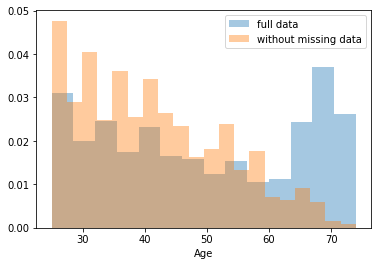

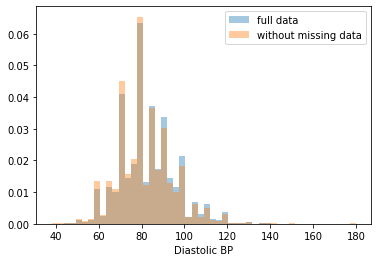

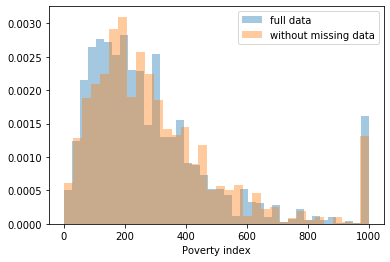

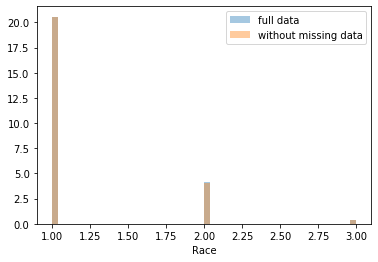

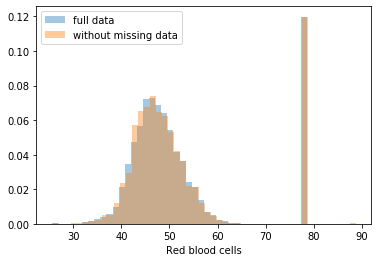

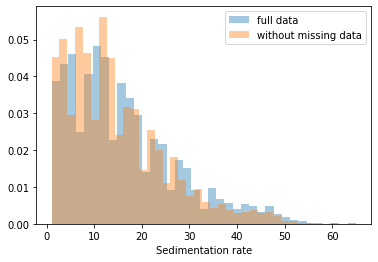

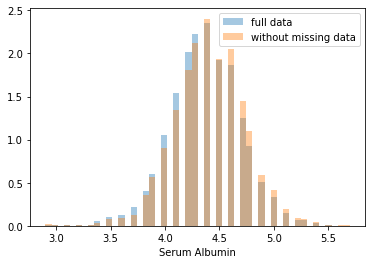

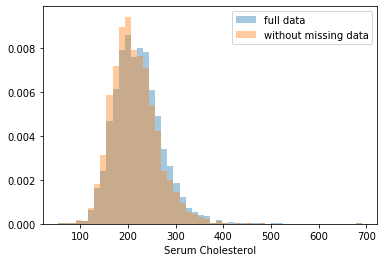

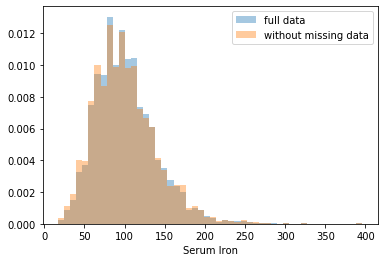

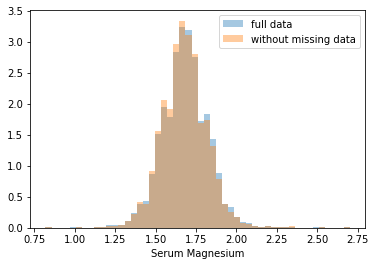

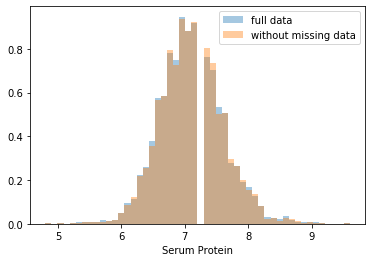

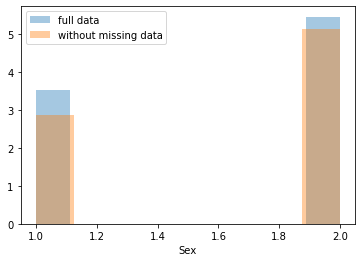

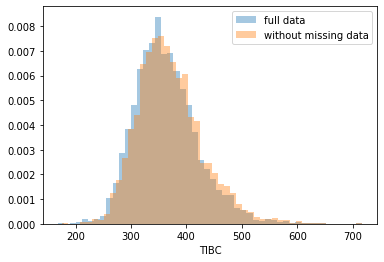

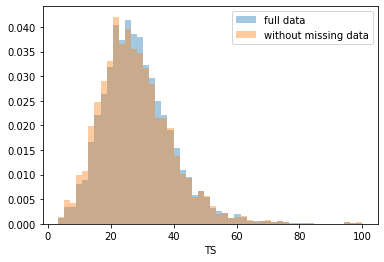

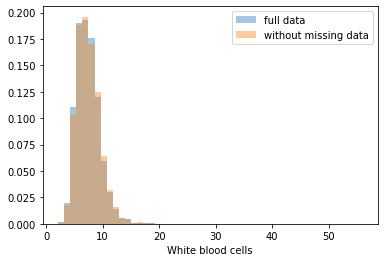

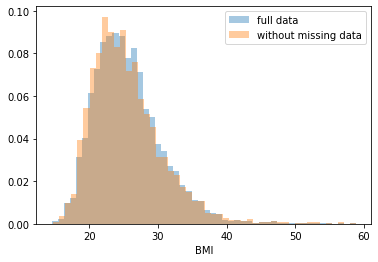

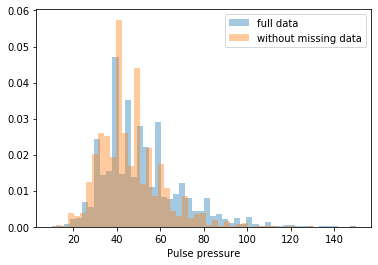

In [84]:
dropped_rows = X_train[X_train.isnull().any(axis=1)]

columns_except_Systolic_BP = [col for col in X_train.columns if col not in ['Systolic BP']]

for col in columns_except_Systolic_BP:
    sns.distplot(X_train.loc[:, col], norm_hist=True, kde=False, label='full data')
    sns.distplot(dropped_rows.loc[:, col], norm_hist=True, kde=False, label='without missing data')
    plt.legend()

    plt.show()

Most of the covariates are distributed similarly whether or not we have discarded rows with missing data. In other words missingness of the data is independent of these covariates.

If this had been true across *all* covariates, then the data would have been said to be **missing completely at random (MCAR)**.

But when considering the age covariate, we see that much more data tends to be missing for patients over 65. The reason could be that blood pressure was measured less frequently for old people to avoid placing additional burden on them.

As missingness is related to one or more covariates, the missing data is said to be **missing at random (MAR)**.

Based on the information we have, there is however no reason to believe that the _values_ of the missing data — or specifically the values of the missing systolic blood pressures — are related to the age of the patients. 
If this was the case, then this data would be said to be **missing not at random (MNAR)**.

<a name='5-1'></a>
### 5.1 Error Analysis

<a name='ex-4'></a>
### Exercise 4 - bad_subset
Using the information from the plots above, try to find a subgroup of the test data on which the model performs poorly. You should be able to easily find a subgroup of at least 250 cases on which the model has a C-Index of less than 0.69.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> Define a mask using a feature and a threshold, e.g. patients with a BMI below 20: <code>mask = X_test['BMI'] < 20 </code>. </li>
    <li> Try to find a subgroup for which the model had little data.</li>
</ul>
</p>

In [89]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def bad_subset(forest, X_test, y_test):
    # define mask to select large subset with poor performance
    # currently mask defines the entire set
    
    ### START CODE HERE (REPLACE the code after 'mask =' with your code) ###
    mask = X_test["Age"] > 65
    ### END CODE HERE ###

    X_subgroup = X_test[mask]
    y_subgroup = y_test[mask]
    subgroup_size = len(X_subgroup)

    y_subgroup_preds = forest.predict_proba(X_subgroup)[:, 1]
    performance = cindex(y_subgroup.values, y_subgroup_preds)
    
    return performance, subgroup_size

In [90]:
#### Test Your Work
performance, subgroup_size = bad_subset(best_rf, X_test, y_test)
print("Subgroup size should greater than 250, performance should be less than 0.69")
print(f"Your Subgroup size: {subgroup_size}, and your C-Index: {performance}")

Subgroup size should greater than 250, performance should be less than 0.69
Your Subgroup size: 439, and your C-Index: 0.6705465587044535


#### Expected Output
Note, your actual output will vary depending on the hyperparameters and the mask that you chose.

```Python
Your Subgroup size > 250, and your C-Index < 0.69
```

<a name='5-2'></a>
### 5.2 Imputation Approaches

Seeing that our data is not missing completely at random, we can handle the missing values by replacing them with substituted values based on the other values that we have. This is known as imputation.

The first imputation strategy that we will use is **mean substitution**: we will replace the missing values for each feature with the mean of the available values. In the next cell, use the `SimpleImputer` from `sklearn` to use mean imputation for the missing values.

In [91]:
# Impute values using the mean
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)
X_train_mean_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_mean_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

<a name='ex-5'></a>
### Exercise 5 - hyperparams
Now perform a hyperparameter grid search to find the best-performing random forest model, and report results on the test set. 

Define the parameter ranges for the hyperparameter search in the next cell, and run the cell.

In [92]:
best_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=98, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.05, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=180,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>n_estimators: try values greater than 100</li>
    <li>max_depth: try values in the range 1 to 100</li>
    <li>min_samples_leaf: try float values below .5 and/or int values greater than 2</li>
</ul>
</p>


In [95]:
# Define ranges for the random forest hyperparameter search 
hyperparams = {
    ### START CODE HERE (REPLACE array values with your code) ###

        # how many trees should be in the forest (int)
        'n_estimators': [60],

        # the maximum depth of trees in the forest (int)
        
        'max_depth': [98],
        
        # the minimum number of samples in a leaf as a fraction
        # of the total number of samples in the training set
        # Can be int (in which case that is the minimum number)
        # or float (in which case the minimum is that fraction of the
        # number of training set samples)
        'min_samples_leaf': [0.05],

    ### END CODE HERE ###
}

In [96]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
rf = RandomForestClassifier

rf_mean_imputed, best_hyperparams_mean_imputed = holdout_grid_search(rf, X_train_mean_imputed, y_train,
                                                                     X_val_mean_imputed, y_val,
                                                                     hyperparams, {'random_state': 10})

print("Performance for best hyperparameters:")

y_train_best = rf_mean_imputed.predict_proba(X_train_mean_imputed)[:, 1]
print(f"- Train C-Index: {cindex(y_train, y_train_best):.4f}")

y_val_best = rf_mean_imputed.predict_proba(X_val_mean_imputed)[:, 1]
print(f"- Val C-Index: {cindex(y_val, y_val_best):.4f}")

y_test_imp = rf_mean_imputed.predict_proba(X_test)[:, 1]
print(f"- Test C-Index: {cindex(y_test, y_test_imp):.4f}")

[1/6840] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.05}
Val C-Index: 0.7307915290561712

[2/6840] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.1}
Val C-Index: 0.7213156757625304

[3/6840] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6947098942760548

[4/6840] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.2}
Val C-Index: 0.7081767233611052

[5/6840] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.25}
Val C-Index: 0.6937599204410484

[6/6840] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6881643031317651

[7/6840] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[8/6840] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[9/6840] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[10/6840] {'n_estimators': 10, 'max_depth': 22, '

[81/6840] {'n_estimators': 10, 'max_depth': 36, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[82/6840] {'n_estimators': 10, 'max_depth': 38, 'min_samples_leaf': 0.05}
Val C-Index: 0.7307915290561712

[83/6840] {'n_estimators': 10, 'max_depth': 38, 'min_samples_leaf': 0.1}
Val C-Index: 0.7213156757625304

[84/6840] {'n_estimators': 10, 'max_depth': 38, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6947098942760548

[85/6840] {'n_estimators': 10, 'max_depth': 38, 'min_samples_leaf': 0.2}
Val C-Index: 0.7081767233611052

[86/6840] {'n_estimators': 10, 'max_depth': 38, 'min_samples_leaf': 0.25}
Val C-Index: 0.6937599204410484

[87/6840] {'n_estimators': 10, 'max_depth': 38, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6881643031317651

[88/6840] {'n_estimators': 10, 'max_depth': 38, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[89/6840] {'n_estimators': 10, 'max_depth': 38, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[90/6840] {'n_estimators': 10, 'max_dept

[159/6840] {'n_estimators': 10, 'max_depth': 54, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6881643031317651

[160/6840] {'n_estimators': 10, 'max_depth': 54, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[161/6840] {'n_estimators': 10, 'max_depth': 54, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[162/6840] {'n_estimators': 10, 'max_depth': 54, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[163/6840] {'n_estimators': 10, 'max_depth': 56, 'min_samples_leaf': 0.05}
Val C-Index: 0.7307915290561712

[164/6840] {'n_estimators': 10, 'max_depth': 56, 'min_samples_leaf': 0.1}
Val C-Index: 0.7213156757625304

[165/6840] {'n_estimators': 10, 'max_depth': 56, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6947098942760548

[166/6840] {'n_estimators': 10, 'max_depth': 56, 'min_samples_leaf': 0.2}
Val C-Index: 0.7081767233611052

[167/6840] {'n_estimators': 10, 'max_depth': 56, 'min_samples_leaf': 0.25}
Val C-Index: 0.6937599204410484

[168/6840] {'n_estimators': 10,

[236/6840] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.1}
Val C-Index: 0.7213156757625304

[237/6840] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6947098942760548

[238/6840] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.2}
Val C-Index: 0.7081767233611052

[239/6840] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.25}
Val C-Index: 0.6937599204410484

[240/6840] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6881643031317651

[241/6840] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[242/6840] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[243/6840] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[244/6840] {'n_estimators': 10, 'max_depth': 74, 'min_samples_leaf': 0.05}
Val C-Index: 0.7307915290561712

[245/6840] {'n_estimators': 10,

[312/6840] {'n_estimators': 10, 'max_depth': 88, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6881643031317651

[313/6840] {'n_estimators': 10, 'max_depth': 88, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[314/6840] {'n_estimators': 10, 'max_depth': 88, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[315/6840] {'n_estimators': 10, 'max_depth': 88, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[316/6840] {'n_estimators': 10, 'max_depth': 90, 'min_samples_leaf': 0.05}
Val C-Index: 0.7307915290561712

[317/6840] {'n_estimators': 10, 'max_depth': 90, 'min_samples_leaf': 0.1}
Val C-Index: 0.7213156757625304

[318/6840] {'n_estimators': 10, 'max_depth': 90, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6947098942760548

[319/6840] {'n_estimators': 10, 'max_depth': 90, 'min_samples_leaf': 0.2}
Val C-Index: 0.7081767233611052

[320/6840] {'n_estimators': 10, 'max_depth': 90, 'min_samples_leaf': 0.25}
Val C-Index: 0.6937599204410484

[321/6840] {'n_estimators': 10,

[389/6840] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.1}
Val C-Index: 0.7267028416703037

[390/6840] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7037753588729727

[391/6840] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.2}
Val C-Index: 0.702051292072984

[392/6840] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.25}
Val C-Index: 0.6871025038053238

[393/6840] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6801204675391226

[394/6840] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[395/6840] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[396/6840] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[397/6840] {'n_estimators': 20, 'max_depth': 28, 'min_samples_leaf': 0.05}
Val C-Index: 0.7335763094982184

[398/6840] {'n_estimators': 20, 

[468/6840] {'n_estimators': 20, 'max_depth': 42, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[469/6840] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.05}
Val C-Index: 0.7335763094982184

[470/6840] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.1}
Val C-Index: 0.7267028416703037

[471/6840] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7037753588729727

[472/6840] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.2}
Val C-Index: 0.702051292072984

[473/6840] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.25}
Val C-Index: 0.6871025038053238

[474/6840] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6801204675391226

[475/6840] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[476/6840] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[477/6840] {'n_estimators': 20, 

[546/6840] {'n_estimators': 20, 'max_depth': 60, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6801204675391226

[547/6840] {'n_estimators': 20, 'max_depth': 60, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[548/6840] {'n_estimators': 20, 'max_depth': 60, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[549/6840] {'n_estimators': 20, 'max_depth': 60, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[550/6840] {'n_estimators': 20, 'max_depth': 62, 'min_samples_leaf': 0.05}
Val C-Index: 0.7335763094982184

[551/6840] {'n_estimators': 20, 'max_depth': 62, 'min_samples_leaf': 0.1}
Val C-Index: 0.7267028416703037

[552/6840] {'n_estimators': 20, 'max_depth': 62, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7037753588729727

[553/6840] {'n_estimators': 20, 'max_depth': 62, 'min_samples_leaf': 0.2}
Val C-Index: 0.702051292072984

[554/6840] {'n_estimators': 20, 'max_depth': 62, 'min_samples_leaf': 0.25}
Val C-Index: 0.6871025038053238

[555/6840] {'n_estimators': 20, 

[624/6840] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7037753588729727

[625/6840] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.2}
Val C-Index: 0.702051292072984

[626/6840] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.25}
Val C-Index: 0.6871025038053238

[627/6840] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6801204675391226

[628/6840] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[629/6840] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[630/6840] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[631/6840] {'n_estimators': 20, 'max_depth': 80, 'min_samples_leaf': 0.05}
Val C-Index: 0.7335763094982184

[632/6840] {'n_estimators': 20, 'max_depth': 80, 'min_samples_leaf': 0.1}
Val C-Index: 0.7267028416703037

[633/6840] {'n_estimators': 20, 

[700/6840] {'n_estimators': 20, 'max_depth': 94, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[701/6840] {'n_estimators': 20, 'max_depth': 94, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[702/6840] {'n_estimators': 20, 'max_depth': 94, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[703/6840] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.05}
Val C-Index: 0.7335763094982184

[704/6840] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.1}
Val C-Index: 0.7267028416703037

[705/6840] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7037753588729727

[706/6840] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.2}
Val C-Index: 0.702051292072984

[707/6840] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.25}
Val C-Index: 0.6871025038053238

[708/6840] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6801204675391226

[709/6840] {'n_estimators': 20, 

[777/6840] {'n_estimators': 30, 'max_depth': 32, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.712342494338156

[778/6840] {'n_estimators': 30, 'max_depth': 32, 'min_samples_leaf': 0.2}
Val C-Index: 0.7058153598283751

[779/6840] {'n_estimators': 30, 'max_depth': 32, 'min_samples_leaf': 0.25}
Val C-Index: 0.6875465487179153

[780/6840] {'n_estimators': 30, 'max_depth': 32, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6844208633796486

[781/6840] {'n_estimators': 30, 'max_depth': 32, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[782/6840] {'n_estimators': 30, 'max_depth': 32, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[783/6840] {'n_estimators': 30, 'max_depth': 32, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[784/6840] {'n_estimators': 30, 'max_depth': 34, 'min_samples_leaf': 0.05}
Val C-Index: 0.7356076249785577

[785/6840] {'n_estimators': 30, 'max_depth': 34, 'min_samples_leaf': 0.1}
Val C-Index: 0.7284084518357837

[786/6840] {'n_estimators': 30, 

[854/6840] {'n_estimators': 30, 'max_depth': 48, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[855/6840] {'n_estimators': 30, 'max_depth': 48, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[856/6840] {'n_estimators': 30, 'max_depth': 50, 'min_samples_leaf': 0.05}
Val C-Index: 0.7356076249785577

[857/6840] {'n_estimators': 30, 'max_depth': 50, 'min_samples_leaf': 0.1}
Val C-Index: 0.7284084518357837

[858/6840] {'n_estimators': 30, 'max_depth': 50, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.712342494338156

[859/6840] {'n_estimators': 30, 'max_depth': 50, 'min_samples_leaf': 0.2}
Val C-Index: 0.7058153598283751

[860/6840] {'n_estimators': 30, 'max_depth': 50, 'min_samples_leaf': 0.25}
Val C-Index: 0.6875465487179153

[861/6840] {'n_estimators': 30, 'max_depth': 50, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6844208633796486

[862/6840] {'n_estimators': 30, 'max_depth': 50, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[863/6840] {'n_estimators': 30, 

[931/6840] {'n_estimators': 30, 'max_depth': 66, 'min_samples_leaf': 0.2}
Val C-Index: 0.7058153598283751

[932/6840] {'n_estimators': 30, 'max_depth': 66, 'min_samples_leaf': 0.25}
Val C-Index: 0.6875465487179153

[933/6840] {'n_estimators': 30, 'max_depth': 66, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6844208633796486

[934/6840] {'n_estimators': 30, 'max_depth': 66, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[935/6840] {'n_estimators': 30, 'max_depth': 66, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[936/6840] {'n_estimators': 30, 'max_depth': 66, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[937/6840] {'n_estimators': 30, 'max_depth': 68, 'min_samples_leaf': 0.05}
Val C-Index: 0.7356076249785577

[938/6840] {'n_estimators': 30, 'max_depth': 68, 'min_samples_leaf': 0.1}
Val C-Index: 0.7284084518357837

[939/6840] {'n_estimators': 30, 'max_depth': 68, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.712342494338156

[940/6840] {'n_estimators': 30, 

[1007/6840] {'n_estimators': 30, 'max_depth': 82, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1008/6840] {'n_estimators': 30, 'max_depth': 82, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1009/6840] {'n_estimators': 30, 'max_depth': 84, 'min_samples_leaf': 0.05}
Val C-Index: 0.7356076249785577

[1010/6840] {'n_estimators': 30, 'max_depth': 84, 'min_samples_leaf': 0.1}
Val C-Index: 0.7284084518357837

[1011/6840] {'n_estimators': 30, 'max_depth': 84, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.712342494338156

[1012/6840] {'n_estimators': 30, 'max_depth': 84, 'min_samples_leaf': 0.2}
Val C-Index: 0.7058153598283751

[1013/6840] {'n_estimators': 30, 'max_depth': 84, 'min_samples_leaf': 0.25}
Val C-Index: 0.6875465487179153

[1014/6840] {'n_estimators': 30, 'max_depth': 84, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6844208633796486

[1015/6840] {'n_estimators': 30, 'max_depth': 84, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1016/6840] {'n_estimat

[1083/6840] {'n_estimators': 40, 'max_depth': 20, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7226782096630253

[1084/6840] {'n_estimators': 40, 'max_depth': 20, 'min_samples_leaf': 0.2}
Val C-Index: 0.7156712026560182

[1085/6840] {'n_estimators': 40, 'max_depth': 20, 'min_samples_leaf': 0.25}
Val C-Index: 0.6911162789687736

[1086/6840] {'n_estimators': 40, 'max_depth': 20, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6883423553705549

[1087/6840] {'n_estimators': 40, 'max_depth': 20, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1088/6840] {'n_estimators': 40, 'max_depth': 20, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1089/6840] {'n_estimators': 40, 'max_depth': 20, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1090/6840] {'n_estimators': 40, 'max_depth': 22, 'min_samples_leaf': 0.05}
Val C-Index: 0.739073129528661

[1091/6840] {'n_estimators': 40, 'max_depth': 22, 'min_samples_leaf': 0.1}
Val C-Index: 0.7332169479674903

[1092/6840] {'n_estimat

[1160/6840] {'n_estimators': 40, 'max_depth': 36, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1161/6840] {'n_estimators': 40, 'max_depth': 36, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1162/6840] {'n_estimators': 40, 'max_depth': 38, 'min_samples_leaf': 0.05}
Val C-Index: 0.739073129528661

[1163/6840] {'n_estimators': 40, 'max_depth': 38, 'min_samples_leaf': 0.1}
Val C-Index: 0.7332169479674903

[1164/6840] {'n_estimators': 40, 'max_depth': 38, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7226782096630253

[1165/6840] {'n_estimators': 40, 'max_depth': 38, 'min_samples_leaf': 0.2}
Val C-Index: 0.7156712026560182

[1166/6840] {'n_estimators': 40, 'max_depth': 38, 'min_samples_leaf': 0.25}
Val C-Index: 0.6911162789687736

[1167/6840] {'n_estimators': 40, 'max_depth': 38, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6883423553705549

[1168/6840] {'n_estimators': 40, 'max_depth': 38, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1169/6840] {'n_estimat

[1236/6840] {'n_estimators': 40, 'max_depth': 54, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7226782096630253

[1237/6840] {'n_estimators': 40, 'max_depth': 54, 'min_samples_leaf': 0.2}
Val C-Index: 0.7156712026560182

[1238/6840] {'n_estimators': 40, 'max_depth': 54, 'min_samples_leaf': 0.25}
Val C-Index: 0.6911162789687736

[1239/6840] {'n_estimators': 40, 'max_depth': 54, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6883423553705549

[1240/6840] {'n_estimators': 40, 'max_depth': 54, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1241/6840] {'n_estimators': 40, 'max_depth': 54, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1242/6840] {'n_estimators': 40, 'max_depth': 54, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1243/6840] {'n_estimators': 40, 'max_depth': 56, 'min_samples_leaf': 0.05}
Val C-Index: 0.739073129528661

[1244/6840] {'n_estimators': 40, 'max_depth': 56, 'min_samples_leaf': 0.1}
Val C-Index: 0.7332169479674903

[1245/6840] {'n_estimat

[1313/6840] {'n_estimators': 40, 'max_depth': 70, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1314/6840] {'n_estimators': 40, 'max_depth': 70, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1315/6840] {'n_estimators': 40, 'max_depth': 72, 'min_samples_leaf': 0.05}
Val C-Index: 0.739073129528661

[1316/6840] {'n_estimators': 40, 'max_depth': 72, 'min_samples_leaf': 0.1}
Val C-Index: 0.7332169479674903

[1317/6840] {'n_estimators': 40, 'max_depth': 72, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7226782096630253

[1318/6840] {'n_estimators': 40, 'max_depth': 72, 'min_samples_leaf': 0.2}
Val C-Index: 0.7156712026560182

[1319/6840] {'n_estimators': 40, 'max_depth': 72, 'min_samples_leaf': 0.25}
Val C-Index: 0.6911162789687736

[1320/6840] {'n_estimators': 40, 'max_depth': 72, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6883423553705549

[1321/6840] {'n_estimators': 40, 'max_depth': 72, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1322/6840] {'n_estimat

[1389/6840] {'n_estimators': 40, 'max_depth': 88, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7226782096630253

[1390/6840] {'n_estimators': 40, 'max_depth': 88, 'min_samples_leaf': 0.2}
Val C-Index: 0.7156712026560182

[1391/6840] {'n_estimators': 40, 'max_depth': 88, 'min_samples_leaf': 0.25}
Val C-Index: 0.6911162789687736

[1392/6840] {'n_estimators': 40, 'max_depth': 88, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6883423553705549

[1393/6840] {'n_estimators': 40, 'max_depth': 88, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1394/6840] {'n_estimators': 40, 'max_depth': 88, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1395/6840] {'n_estimators': 40, 'max_depth': 88, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1396/6840] {'n_estimators': 40, 'max_depth': 90, 'min_samples_leaf': 0.05}
Val C-Index: 0.739073129528661

[1397/6840] {'n_estimators': 40, 'max_depth': 90, 'min_samples_leaf': 0.1}
Val C-Index: 0.7332169479674903

[1398/6840] {'n_estimat

[1466/6840] {'n_estimators': 50, 'max_depth': 24, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1467/6840] {'n_estimators': 50, 'max_depth': 24, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1468/6840] {'n_estimators': 50, 'max_depth': 26, 'min_samples_leaf': 0.05}
Val C-Index: 0.7405909162959055

[1469/6840] {'n_estimators': 50, 'max_depth': 26, 'min_samples_leaf': 0.1}
Val C-Index: 0.7339291569226494

[1470/6840] {'n_estimators': 50, 'max_depth': 26, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7250721437272414

[1471/6840] {'n_estimators': 50, 'max_depth': 26, 'min_samples_leaf': 0.2}
Val C-Index: 0.7199162285930182

[1472/6840] {'n_estimators': 50, 'max_depth': 26, 'min_samples_leaf': 0.25}
Val C-Index: 0.7004629358208534

[1473/6840] {'n_estimators': 50, 'max_depth': 26, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6908871995639891

[1474/6840] {'n_estimators': 50, 'max_depth': 26, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1475/6840] {'n_estima

[1542/6840] {'n_estimators': 50, 'max_depth': 42, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7250721437272414

[1543/6840] {'n_estimators': 50, 'max_depth': 42, 'min_samples_leaf': 0.2}
Val C-Index: 0.7199162285930182

[1544/6840] {'n_estimators': 50, 'max_depth': 42, 'min_samples_leaf': 0.25}
Val C-Index: 0.7004629358208534

[1545/6840] {'n_estimators': 50, 'max_depth': 42, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6908871995639891

[1546/6840] {'n_estimators': 50, 'max_depth': 42, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1547/6840] {'n_estimators': 50, 'max_depth': 42, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1548/6840] {'n_estimators': 50, 'max_depth': 42, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1549/6840] {'n_estimators': 50, 'max_depth': 44, 'min_samples_leaf': 0.05}
Val C-Index: 0.7405909162959055

[1550/6840] {'n_estimators': 50, 'max_depth': 44, 'min_samples_leaf': 0.1}
Val C-Index: 0.7339291569226494

[1551/6840] {'n_estima

[1619/6840] {'n_estimators': 50, 'max_depth': 58, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1620/6840] {'n_estimators': 50, 'max_depth': 58, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1621/6840] {'n_estimators': 50, 'max_depth': 60, 'min_samples_leaf': 0.05}
Val C-Index: 0.7405909162959055

[1622/6840] {'n_estimators': 50, 'max_depth': 60, 'min_samples_leaf': 0.1}
Val C-Index: 0.7339291569226494

[1623/6840] {'n_estimators': 50, 'max_depth': 60, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7250721437272414

[1624/6840] {'n_estimators': 50, 'max_depth': 60, 'min_samples_leaf': 0.2}
Val C-Index: 0.7199162285930182

[1625/6840] {'n_estimators': 50, 'max_depth': 60, 'min_samples_leaf': 0.25}
Val C-Index: 0.7004629358208534

[1626/6840] {'n_estimators': 50, 'max_depth': 60, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6908871995639891

[1627/6840] {'n_estimators': 50, 'max_depth': 60, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1628/6840] {'n_estima

[1695/6840] {'n_estimators': 50, 'max_depth': 76, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7250721437272414

[1696/6840] {'n_estimators': 50, 'max_depth': 76, 'min_samples_leaf': 0.2}
Val C-Index: 0.7199162285930182

[1697/6840] {'n_estimators': 50, 'max_depth': 76, 'min_samples_leaf': 0.25}
Val C-Index: 0.7004629358208534

[1698/6840] {'n_estimators': 50, 'max_depth': 76, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6908871995639891

[1699/6840] {'n_estimators': 50, 'max_depth': 76, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1700/6840] {'n_estimators': 50, 'max_depth': 76, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1701/6840] {'n_estimators': 50, 'max_depth': 76, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1702/6840] {'n_estimators': 50, 'max_depth': 78, 'min_samples_leaf': 0.05}
Val C-Index: 0.7405909162959055

[1703/6840] {'n_estimators': 50, 'max_depth': 78, 'min_samples_leaf': 0.1}
Val C-Index: 0.7339291569226494

[1704/6840] {'n_estima

[1772/6840] {'n_estimators': 50, 'max_depth': 92, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1773/6840] {'n_estimators': 50, 'max_depth': 92, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1774/6840] {'n_estimators': 50, 'max_depth': 94, 'min_samples_leaf': 0.05}
Val C-Index: 0.7405909162959055

[1775/6840] {'n_estimators': 50, 'max_depth': 94, 'min_samples_leaf': 0.1}
Val C-Index: 0.7339291569226494

[1776/6840] {'n_estimators': 50, 'max_depth': 94, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7250721437272414

[1777/6840] {'n_estimators': 50, 'max_depth': 94, 'min_samples_leaf': 0.2}
Val C-Index: 0.7199162285930182

[1778/6840] {'n_estimators': 50, 'max_depth': 94, 'min_samples_leaf': 0.25}
Val C-Index: 0.7004629358208534

[1779/6840] {'n_estimators': 50, 'max_depth': 94, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6908871995639891

[1780/6840] {'n_estimators': 50, 'max_depth': 94, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1781/6840] {'n_estima

[1848/6840] {'n_estimators': 60, 'max_depth': 30, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7247312388310219

[1849/6840] {'n_estimators': 60, 'max_depth': 30, 'min_samples_leaf': 0.2}
Val C-Index: 0.7180119381854739

[1850/6840] {'n_estimators': 60, 'max_depth': 30, 'min_samples_leaf': 0.25}
Val C-Index: 0.6987312692301846

[1851/6840] {'n_estimators': 60, 'max_depth': 30, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6892684441491382

[1852/6840] {'n_estimators': 60, 'max_depth': 30, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1853/6840] {'n_estimators': 60, 'max_depth': 30, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1854/6840] {'n_estimators': 60, 'max_depth': 30, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1855/6840] {'n_estimators': 60, 'max_depth': 32, 'min_samples_leaf': 0.05}
Val C-Index: 0.741027361417817

[1856/6840] {'n_estimators': 60, 'max_depth': 32, 'min_samples_leaf': 0.1}
Val C-Index: 0.7334655696911663

[1857/6840] {'n_estimat

[1924/6840] {'n_estimators': 60, 'max_depth': 46, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1925/6840] {'n_estimators': 60, 'max_depth': 46, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1926/6840] {'n_estimators': 60, 'max_depth': 46, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1927/6840] {'n_estimators': 60, 'max_depth': 48, 'min_samples_leaf': 0.05}
Val C-Index: 0.741027361417817

[1928/6840] {'n_estimators': 60, 'max_depth': 48, 'min_samples_leaf': 0.1}
Val C-Index: 0.7334655696911663

[1929/6840] {'n_estimators': 60, 'max_depth': 48, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7247312388310219

[1930/6840] {'n_estimators': 60, 'max_depth': 48, 'min_samples_leaf': 0.2}
Val C-Index: 0.7180119381854739

[1931/6840] {'n_estimators': 60, 'max_depth': 48, 'min_samples_leaf': 0.25}
Val C-Index: 0.6987312692301846

[1932/6840] {'n_estimators': 60, 'max_depth': 48, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6892684441491382

[1933/6840] {'n_estimat

[2000/6840] {'n_estimators': 60, 'max_depth': 64, 'min_samples_leaf': 0.1}
Val C-Index: 0.7334655696911663

[2001/6840] {'n_estimators': 60, 'max_depth': 64, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7247312388310219

[2002/6840] {'n_estimators': 60, 'max_depth': 64, 'min_samples_leaf': 0.2}
Val C-Index: 0.7180119381854739

[2003/6840] {'n_estimators': 60, 'max_depth': 64, 'min_samples_leaf': 0.25}
Val C-Index: 0.6987312692301846

[2004/6840] {'n_estimators': 60, 'max_depth': 64, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6892684441491382

[2005/6840] {'n_estimators': 60, 'max_depth': 64, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2006/6840] {'n_estimators': 60, 'max_depth': 64, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2007/6840] {'n_estimators': 60, 'max_depth': 64, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2008/6840] {'n_estimators': 60, 'max_depth': 66, 'min_samples_leaf': 0.05}
Val C-Index: 0.741027361417817

[2009/6840] {'n_estimat

[2076/6840] {'n_estimators': 60, 'max_depth': 80, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6892684441491382

[2077/6840] {'n_estimators': 60, 'max_depth': 80, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2078/6840] {'n_estimators': 60, 'max_depth': 80, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2079/6840] {'n_estimators': 60, 'max_depth': 80, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2080/6840] {'n_estimators': 60, 'max_depth': 82, 'min_samples_leaf': 0.05}
Val C-Index: 0.741027361417817

[2081/6840] {'n_estimators': 60, 'max_depth': 82, 'min_samples_leaf': 0.1}
Val C-Index: 0.7334655696911663

[2082/6840] {'n_estimators': 60, 'max_depth': 82, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7247312388310219

[2083/6840] {'n_estimators': 60, 'max_depth': 82, 'min_samples_leaf': 0.2}
Val C-Index: 0.7180119381854739

[2084/6840] {'n_estimators': 60, 'max_depth': 82, 'min_samples_leaf': 0.25}
Val C-Index: 0.6987312692301846

[2085/6840] {'n_estimat

[2152/6840] {'n_estimators': 60, 'max_depth': 98, 'min_samples_leaf': 0.05}
Val C-Index: 0.741027361417817

[2153/6840] {'n_estimators': 60, 'max_depth': 98, 'min_samples_leaf': 0.1}
Val C-Index: 0.7334655696911663

[2154/6840] {'n_estimators': 60, 'max_depth': 98, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7247312388310219

[2155/6840] {'n_estimators': 60, 'max_depth': 98, 'min_samples_leaf': 0.2}
Val C-Index: 0.7180119381854739

[2156/6840] {'n_estimators': 60, 'max_depth': 98, 'min_samples_leaf': 0.25}
Val C-Index: 0.6987312692301846

[2157/6840] {'n_estimators': 60, 'max_depth': 98, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6892684441491382

[2158/6840] {'n_estimators': 60, 'max_depth': 98, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2159/6840] {'n_estimators': 60, 'max_depth': 98, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2160/6840] {'n_estimators': 60, 'max_depth': 98, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2161/6840] {'n_estimat

[2228/6840] {'n_estimators': 70, 'max_depth': 34, 'min_samples_leaf': 0.25}
Val C-Index: 0.6964426465511064

[2229/6840] {'n_estimators': 70, 'max_depth': 34, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6863696668468903

[2230/6840] {'n_estimators': 70, 'max_depth': 34, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2231/6840] {'n_estimators': 70, 'max_depth': 34, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2232/6840] {'n_estimators': 70, 'max_depth': 34, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2233/6840] {'n_estimators': 70, 'max_depth': 36, 'min_samples_leaf': 0.05}
Val C-Index: 0.73978533848382

[2234/6840] {'n_estimators': 70, 'max_depth': 36, 'min_samples_leaf': 0.1}
Val C-Index: 0.7326523920884007

[2235/6840] {'n_estimators': 70, 'max_depth': 36, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7209812849726082

[2236/6840] {'n_estimators': 70, 'max_depth': 36, 'min_samples_leaf': 0.2}
Val C-Index: 0.7145507763729022

[2237/6840] {'n_estimato

[2304/6840] {'n_estimators': 70, 'max_depth': 50, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2305/6840] {'n_estimators': 70, 'max_depth': 52, 'min_samples_leaf': 0.05}
Val C-Index: 0.73978533848382

[2306/6840] {'n_estimators': 70, 'max_depth': 52, 'min_samples_leaf': 0.1}
Val C-Index: 0.7326523920884007

[2307/6840] {'n_estimators': 70, 'max_depth': 52, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7209812849726082

[2308/6840] {'n_estimators': 70, 'max_depth': 52, 'min_samples_leaf': 0.2}
Val C-Index: 0.7145507763729022

[2309/6840] {'n_estimators': 70, 'max_depth': 52, 'min_samples_leaf': 0.25}
Val C-Index: 0.6964426465511064

[2310/6840] {'n_estimators': 70, 'max_depth': 52, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6863696668468903

[2311/6840] {'n_estimators': 70, 'max_depth': 52, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2312/6840] {'n_estimators': 70, 'max_depth': 52, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2313/6840] {'n_estimato

[2380/6840] {'n_estimators': 70, 'max_depth': 68, 'min_samples_leaf': 0.2}
Val C-Index: 0.7145507763729022

[2381/6840] {'n_estimators': 70, 'max_depth': 68, 'min_samples_leaf': 0.25}
Val C-Index: 0.6964426465511064

[2382/6840] {'n_estimators': 70, 'max_depth': 68, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6863696668468903

[2383/6840] {'n_estimators': 70, 'max_depth': 68, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2384/6840] {'n_estimators': 70, 'max_depth': 68, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2385/6840] {'n_estimators': 70, 'max_depth': 68, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2386/6840] {'n_estimators': 70, 'max_depth': 70, 'min_samples_leaf': 0.05}
Val C-Index: 0.73978533848382

[2387/6840] {'n_estimators': 70, 'max_depth': 70, 'min_samples_leaf': 0.1}
Val C-Index: 0.7326523920884007

[2388/6840] {'n_estimators': 70, 'max_depth': 70, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7209812849726082

[2389/6840] {'n_estimato

[2456/6840] {'n_estimators': 70, 'max_depth': 84, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2457/6840] {'n_estimators': 70, 'max_depth': 84, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2458/6840] {'n_estimators': 70, 'max_depth': 86, 'min_samples_leaf': 0.05}
Val C-Index: 0.73978533848382

[2459/6840] {'n_estimators': 70, 'max_depth': 86, 'min_samples_leaf': 0.1}
Val C-Index: 0.7326523920884007

[2460/6840] {'n_estimators': 70, 'max_depth': 86, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7209812849726082

[2461/6840] {'n_estimators': 70, 'max_depth': 86, 'min_samples_leaf': 0.2}
Val C-Index: 0.7145507763729022

[2462/6840] {'n_estimators': 70, 'max_depth': 86, 'min_samples_leaf': 0.25}
Val C-Index: 0.6964426465511064

[2463/6840] {'n_estimators': 70, 'max_depth': 86, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6863696668468903

[2464/6840] {'n_estimators': 70, 'max_depth': 86, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2465/6840] {'n_estimato

[2532/6840] {'n_estimators': 80, 'max_depth': 22, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7196382933910049

[2533/6840] {'n_estimators': 80, 'max_depth': 22, 'min_samples_leaf': 0.2}
Val C-Index: 0.7119049635318616

[2534/6840] {'n_estimators': 80, 'max_depth': 22, 'min_samples_leaf': 0.25}
Val C-Index: 0.6953319914274361

[2535/6840] {'n_estimators': 80, 'max_depth': 22, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6856770002106227

[2536/6840] {'n_estimators': 80, 'max_depth': 22, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2537/6840] {'n_estimators': 80, 'max_depth': 22, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2538/6840] {'n_estimators': 80, 'max_depth': 22, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2539/6840] {'n_estimators': 80, 'max_depth': 24, 'min_samples_leaf': 0.05}
Val C-Index: 0.7387322246324416

[2540/6840] {'n_estimators': 80, 'max_depth': 24, 'min_samples_leaf': 0.1}
Val C-Index: 0.7301075478949666

[2541/6840] {'n_estima

[2608/6840] {'n_estimators': 80, 'max_depth': 38, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2609/6840] {'n_estimators': 80, 'max_depth': 38, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2610/6840] {'n_estimators': 80, 'max_depth': 38, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2611/6840] {'n_estimators': 80, 'max_depth': 40, 'min_samples_leaf': 0.05}
Val C-Index: 0.7387322246324416

[2612/6840] {'n_estimators': 80, 'max_depth': 40, 'min_samples_leaf': 0.1}
Val C-Index: 0.7301075478949666

[2613/6840] {'n_estimators': 80, 'max_depth': 40, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7196382933910049

[2614/6840] {'n_estimators': 80, 'max_depth': 40, 'min_samples_leaf': 0.2}
Val C-Index: 0.7119049635318616

[2615/6840] {'n_estimators': 80, 'max_depth': 40, 'min_samples_leaf': 0.25}
Val C-Index: 0.6953319914274361

[2616/6840] {'n_estimators': 80, 'max_depth': 40, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6856770002106227

[2617/6840] {'n_estima

[2684/6840] {'n_estimators': 80, 'max_depth': 56, 'min_samples_leaf': 0.1}
Val C-Index: 0.7301075478949666

[2685/6840] {'n_estimators': 80, 'max_depth': 56, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7196382933910049

[2686/6840] {'n_estimators': 80, 'max_depth': 56, 'min_samples_leaf': 0.2}
Val C-Index: 0.7119049635318616

[2687/6840] {'n_estimators': 80, 'max_depth': 56, 'min_samples_leaf': 0.25}
Val C-Index: 0.6953319914274361

[2688/6840] {'n_estimators': 80, 'max_depth': 56, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6856770002106227

[2689/6840] {'n_estimators': 80, 'max_depth': 56, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2690/6840] {'n_estimators': 80, 'max_depth': 56, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2691/6840] {'n_estimators': 80, 'max_depth': 56, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2692/6840] {'n_estimators': 80, 'max_depth': 58, 'min_samples_leaf': 0.05}
Val C-Index: 0.7387322246324416

[2693/6840] {'n_estima

[2760/6840] {'n_estimators': 80, 'max_depth': 72, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6856770002106227

[2761/6840] {'n_estimators': 80, 'max_depth': 72, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2762/6840] {'n_estimators': 80, 'max_depth': 72, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2763/6840] {'n_estimators': 80, 'max_depth': 72, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2764/6840] {'n_estimators': 80, 'max_depth': 74, 'min_samples_leaf': 0.05}
Val C-Index: 0.7387322246324416

[2765/6840] {'n_estimators': 80, 'max_depth': 74, 'min_samples_leaf': 0.1}
Val C-Index: 0.7301075478949666

[2766/6840] {'n_estimators': 80, 'max_depth': 74, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7196382933910049

[2767/6840] {'n_estimators': 80, 'max_depth': 74, 'min_samples_leaf': 0.2}
Val C-Index: 0.7119049635318616

[2768/6840] {'n_estimators': 80, 'max_depth': 74, 'min_samples_leaf': 0.25}
Val C-Index: 0.6953319914274361

[2769/6840] {'n_estima

[2836/6840] {'n_estimators': 80, 'max_depth': 90, 'min_samples_leaf': 0.05}
Val C-Index: 0.7387322246324416

[2837/6840] {'n_estimators': 80, 'max_depth': 90, 'min_samples_leaf': 0.1}
Val C-Index: 0.7301075478949666

[2838/6840] {'n_estimators': 80, 'max_depth': 90, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7196382933910049

[2839/6840] {'n_estimators': 80, 'max_depth': 90, 'min_samples_leaf': 0.2}
Val C-Index: 0.7119049635318616

[2840/6840] {'n_estimators': 80, 'max_depth': 90, 'min_samples_leaf': 0.25}
Val C-Index: 0.6953319914274361

[2841/6840] {'n_estimators': 80, 'max_depth': 90, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6856770002106227

[2842/6840] {'n_estimators': 80, 'max_depth': 90, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2843/6840] {'n_estimators': 80, 'max_depth': 90, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2844/6840] {'n_estimators': 80, 'max_depth': 90, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2845/6840] {'n_estima

[2912/6840] {'n_estimators': 90, 'max_depth': 26, 'min_samples_leaf': 0.25}
Val C-Index: 0.6964741313982095

[2913/6840] {'n_estimators': 90, 'max_depth': 26, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6863110398902156

[2914/6840] {'n_estimators': 90, 'max_depth': 26, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2915/6840] {'n_estimators': 90, 'max_depth': 26, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2916/6840] {'n_estimators': 90, 'max_depth': 26, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2917/6840] {'n_estimators': 90, 'max_depth': 28, 'min_samples_leaf': 0.05}
Val C-Index: 0.7394292340062405

[2918/6840] {'n_estimators': 90, 'max_depth': 28, 'min_samples_leaf': 0.1}
Val C-Index: 0.7311628331151108

[2919/6840] {'n_estimators': 90, 'max_depth': 28, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7218444040569854

[2920/6840] {'n_estimators': 90, 'max_depth': 28, 'min_samples_leaf': 0.2}
Val C-Index: 0.7135519467406669

[2921/6840] {'n_estima

[2988/6840] {'n_estimators': 90, 'max_depth': 42, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2989/6840] {'n_estimators': 90, 'max_depth': 44, 'min_samples_leaf': 0.05}
Val C-Index: 0.7394292340062405

[2990/6840] {'n_estimators': 90, 'max_depth': 44, 'min_samples_leaf': 0.1}
Val C-Index: 0.7311628331151108

[2991/6840] {'n_estimators': 90, 'max_depth': 44, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7218444040569854

[2992/6840] {'n_estimators': 90, 'max_depth': 44, 'min_samples_leaf': 0.2}
Val C-Index: 0.7135519467406669

[2993/6840] {'n_estimators': 90, 'max_depth': 44, 'min_samples_leaf': 0.25}
Val C-Index: 0.6964741313982095

[2994/6840] {'n_estimators': 90, 'max_depth': 44, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6863110398902156

[2995/6840] {'n_estimators': 90, 'max_depth': 44, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2996/6840] {'n_estimators': 90, 'max_depth': 44, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2997/6840] {'n_estima

[3064/6840] {'n_estimators': 90, 'max_depth': 60, 'min_samples_leaf': 0.2}
Val C-Index: 0.7135519467406669

[3065/6840] {'n_estimators': 90, 'max_depth': 60, 'min_samples_leaf': 0.25}
Val C-Index: 0.6964741313982095

[3066/6840] {'n_estimators': 90, 'max_depth': 60, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6863110398902156

[3067/6840] {'n_estimators': 90, 'max_depth': 60, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3068/6840] {'n_estimators': 90, 'max_depth': 60, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3069/6840] {'n_estimators': 90, 'max_depth': 60, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3070/6840] {'n_estimators': 90, 'max_depth': 62, 'min_samples_leaf': 0.05}
Val C-Index: 0.7394292340062405

[3071/6840] {'n_estimators': 90, 'max_depth': 62, 'min_samples_leaf': 0.1}
Val C-Index: 0.7311628331151108

[3072/6840] {'n_estimators': 90, 'max_depth': 62, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7218444040569854

[3073/6840] {'n_estima

[3140/6840] {'n_estimators': 90, 'max_depth': 76, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3141/6840] {'n_estimators': 90, 'max_depth': 76, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3142/6840] {'n_estimators': 90, 'max_depth': 78, 'min_samples_leaf': 0.05}
Val C-Index: 0.7394292340062405

[3143/6840] {'n_estimators': 90, 'max_depth': 78, 'min_samples_leaf': 0.1}
Val C-Index: 0.7311628331151108

[3144/6840] {'n_estimators': 90, 'max_depth': 78, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7218444040569854

[3145/6840] {'n_estimators': 90, 'max_depth': 78, 'min_samples_leaf': 0.2}
Val C-Index: 0.7135519467406669

[3146/6840] {'n_estimators': 90, 'max_depth': 78, 'min_samples_leaf': 0.25}
Val C-Index: 0.6964741313982095

[3147/6840] {'n_estimators': 90, 'max_depth': 78, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6863110398902156

[3148/6840] {'n_estimators': 90, 'max_depth': 78, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3149/6840] {'n_estima

[3216/6840] {'n_estimators': 90, 'max_depth': 94, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7218444040569854

[3217/6840] {'n_estimators': 90, 'max_depth': 94, 'min_samples_leaf': 0.2}
Val C-Index: 0.7135519467406669

[3218/6840] {'n_estimators': 90, 'max_depth': 94, 'min_samples_leaf': 0.25}
Val C-Index: 0.6964741313982095

[3219/6840] {'n_estimators': 90, 'max_depth': 94, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6863110398902156

[3220/6840] {'n_estimators': 90, 'max_depth': 94, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3221/6840] {'n_estimators': 90, 'max_depth': 94, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3222/6840] {'n_estimators': 90, 'max_depth': 94, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3223/6840] {'n_estimators': 90, 'max_depth': 96, 'min_samples_leaf': 0.05}
Val C-Index: 0.7394292340062405

[3224/6840] {'n_estimators': 90, 'max_depth': 96, 'min_samples_leaf': 0.1}
Val C-Index: 0.7311628331151108

[3225/6840] {'n_estima

[3291/6840] {'n_estimators': 100, 'max_depth': 30, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6878429405544373

[3292/6840] {'n_estimators': 100, 'max_depth': 30, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3293/6840] {'n_estimators': 100, 'max_depth': 30, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3294/6840] {'n_estimators': 100, 'max_depth': 30, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3295/6840] {'n_estimators': 100, 'max_depth': 32, 'min_samples_leaf': 0.05}
Val C-Index: 0.7403390375190809

[3296/6840] {'n_estimators': 100, 'max_depth': 32, 'min_samples_leaf': 0.1}
Val C-Index: 0.7316600765624627

[3297/6840] {'n_estimators': 100, 'max_depth': 32, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7227737498887173

[3298/6840] {'n_estimators': 100, 'max_depth': 32, 'min_samples_leaf': 0.2}
Val C-Index: 0.7152152152152152

[3299/6840] {'n_estimators': 100, 'max_depth': 32, 'min_samples_leaf': 0.25}
Val C-Index: 0.697695526328932

[3300/6840] {'

[3366/6840] {'n_estimators': 100, 'max_depth': 46, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3367/6840] {'n_estimators': 100, 'max_depth': 48, 'min_samples_leaf': 0.05}
Val C-Index: 0.7403390375190809

[3368/6840] {'n_estimators': 100, 'max_depth': 48, 'min_samples_leaf': 0.1}
Val C-Index: 0.7316600765624627

[3369/6840] {'n_estimators': 100, 'max_depth': 48, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7227737498887173

[3370/6840] {'n_estimators': 100, 'max_depth': 48, 'min_samples_leaf': 0.2}
Val C-Index: 0.7152152152152152

[3371/6840] {'n_estimators': 100, 'max_depth': 48, 'min_samples_leaf': 0.25}
Val C-Index: 0.697695526328932

[3372/6840] {'n_estimators': 100, 'max_depth': 48, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6878429405544373

[3373/6840] {'n_estimators': 100, 'max_depth': 48, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3374/6840] {'n_estimators': 100, 'max_depth': 48, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3375/6840] {'

[3441/6840] {'n_estimators': 100, 'max_depth': 64, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7227737498887173

[3442/6840] {'n_estimators': 100, 'max_depth': 64, 'min_samples_leaf': 0.2}
Val C-Index: 0.7152152152152152

[3443/6840] {'n_estimators': 100, 'max_depth': 64, 'min_samples_leaf': 0.25}
Val C-Index: 0.697695526328932

[3444/6840] {'n_estimators': 100, 'max_depth': 64, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6878429405544373

[3445/6840] {'n_estimators': 100, 'max_depth': 64, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3446/6840] {'n_estimators': 100, 'max_depth': 64, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3447/6840] {'n_estimators': 100, 'max_depth': 64, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3448/6840] {'n_estimators': 100, 'max_depth': 66, 'min_samples_leaf': 0.05}
Val C-Index: 0.7403390375190809

[3449/6840] {'n_estimators': 100, 'max_depth': 66, 'min_samples_leaf': 0.1}
Val C-Index: 0.7316600765624627

[3450/6840] {'

[3516/6840] {'n_estimators': 100, 'max_depth': 80, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6878429405544373

[3517/6840] {'n_estimators': 100, 'max_depth': 80, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3518/6840] {'n_estimators': 100, 'max_depth': 80, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3519/6840] {'n_estimators': 100, 'max_depth': 80, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3520/6840] {'n_estimators': 100, 'max_depth': 82, 'min_samples_leaf': 0.05}
Val C-Index: 0.7403390375190809

[3521/6840] {'n_estimators': 100, 'max_depth': 82, 'min_samples_leaf': 0.1}
Val C-Index: 0.7316600765624627

[3522/6840] {'n_estimators': 100, 'max_depth': 82, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7227737498887173

[3523/6840] {'n_estimators': 100, 'max_depth': 82, 'min_samples_leaf': 0.2}
Val C-Index: 0.7152152152152152

[3524/6840] {'n_estimators': 100, 'max_depth': 82, 'min_samples_leaf': 0.25}
Val C-Index: 0.697695526328932

[3525/6840] {'

[3591/6840] {'n_estimators': 100, 'max_depth': 96, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3592/6840] {'n_estimators': 100, 'max_depth': 98, 'min_samples_leaf': 0.05}
Val C-Index: 0.7403390375190809

[3593/6840] {'n_estimators': 100, 'max_depth': 98, 'min_samples_leaf': 0.1}
Val C-Index: 0.7316600765624627

[3594/6840] {'n_estimators': 100, 'max_depth': 98, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7227737498887173

[3595/6840] {'n_estimators': 100, 'max_depth': 98, 'min_samples_leaf': 0.2}
Val C-Index: 0.7152152152152152

[3596/6840] {'n_estimators': 100, 'max_depth': 98, 'min_samples_leaf': 0.25}
Val C-Index: 0.697695526328932

[3597/6840] {'n_estimators': 100, 'max_depth': 98, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6878429405544373

[3598/6840] {'n_estimators': 100, 'max_depth': 98, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3599/6840] {'n_estimators': 100, 'max_depth': 98, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3600/6840] {'

[3666/6840] {'n_estimators': 110, 'max_depth': 34, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7228844896957696

[3667/6840] {'n_estimators': 110, 'max_depth': 34, 'min_samples_leaf': 0.2}
Val C-Index: 0.715657088759041

[3668/6840] {'n_estimators': 110, 'max_depth': 34, 'min_samples_leaf': 0.25}
Val C-Index: 0.7000525471241307

[3669/6840] {'n_estimators': 110, 'max_depth': 34, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6896647189488838

[3670/6840] {'n_estimators': 110, 'max_depth': 34, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3671/6840] {'n_estimators': 110, 'max_depth': 34, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3672/6840] {'n_estimators': 110, 'max_depth': 34, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3673/6840] {'n_estimators': 110, 'max_depth': 36, 'min_samples_leaf': 0.05}
Val C-Index: 0.7399981326228615

[3674/6840] {'n_estimators': 110, 'max_depth': 36, 'min_samples_leaf': 0.1}
Val C-Index: 0.7313843127292151

[3675/6840] {'

[3741/6840] {'n_estimators': 110, 'max_depth': 50, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6896647189488838

[3742/6840] {'n_estimators': 110, 'max_depth': 50, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3743/6840] {'n_estimators': 110, 'max_depth': 50, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3744/6840] {'n_estimators': 110, 'max_depth': 50, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3745/6840] {'n_estimators': 110, 'max_depth': 52, 'min_samples_leaf': 0.05}
Val C-Index: 0.7399981326228615

[3746/6840] {'n_estimators': 110, 'max_depth': 52, 'min_samples_leaf': 0.1}
Val C-Index: 0.7313843127292151

[3747/6840] {'n_estimators': 110, 'max_depth': 52, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7228844896957696

[3748/6840] {'n_estimators': 110, 'max_depth': 52, 'min_samples_leaf': 0.2}
Val C-Index: 0.715657088759041

[3749/6840] {'n_estimators': 110, 'max_depth': 52, 'min_samples_leaf': 0.25}
Val C-Index: 0.7000525471241307

[3750/6840] {'

[3816/6840] {'n_estimators': 110, 'max_depth': 66, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3817/6840] {'n_estimators': 110, 'max_depth': 68, 'min_samples_leaf': 0.05}
Val C-Index: 0.7399981326228615

[3818/6840] {'n_estimators': 110, 'max_depth': 68, 'min_samples_leaf': 0.1}
Val C-Index: 0.7313843127292151

[3819/6840] {'n_estimators': 110, 'max_depth': 68, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7228844896957696

[3820/6840] {'n_estimators': 110, 'max_depth': 68, 'min_samples_leaf': 0.2}
Val C-Index: 0.715657088759041

[3821/6840] {'n_estimators': 110, 'max_depth': 68, 'min_samples_leaf': 0.25}
Val C-Index: 0.7000525471241307

[3822/6840] {'n_estimators': 110, 'max_depth': 68, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6896647189488838

[3823/6840] {'n_estimators': 110, 'max_depth': 68, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3824/6840] {'n_estimators': 110, 'max_depth': 68, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3825/6840] {'

[3891/6840] {'n_estimators': 110, 'max_depth': 84, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7228844896957696

[3892/6840] {'n_estimators': 110, 'max_depth': 84, 'min_samples_leaf': 0.2}
Val C-Index: 0.715657088759041

[3893/6840] {'n_estimators': 110, 'max_depth': 84, 'min_samples_leaf': 0.25}
Val C-Index: 0.7000525471241307

[3894/6840] {'n_estimators': 110, 'max_depth': 84, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6896647189488838

[3895/6840] {'n_estimators': 110, 'max_depth': 84, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3896/6840] {'n_estimators': 110, 'max_depth': 84, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3897/6840] {'n_estimators': 110, 'max_depth': 84, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3898/6840] {'n_estimators': 110, 'max_depth': 86, 'min_samples_leaf': 0.05}
Val C-Index: 0.7399981326228615

[3899/6840] {'n_estimators': 110, 'max_depth': 86, 'min_samples_leaf': 0.1}
Val C-Index: 0.7313843127292151

[3900/6840] {'

[3966/6840] {'n_estimators': 120, 'max_depth': 20, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6914376415461014

[3967/6840] {'n_estimators': 120, 'max_depth': 20, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3968/6840] {'n_estimators': 120, 'max_depth': 20, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3969/6840] {'n_estimators': 120, 'max_depth': 20, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3970/6840] {'n_estimators': 120, 'max_depth': 22, 'min_samples_leaf': 0.05}
Val C-Index: 0.7399351629286554

[3971/6840] {'n_estimators': 120, 'max_depth': 22, 'min_samples_leaf': 0.1}
Val C-Index: 0.7326002792380233

[3972/6840] {'n_estimators': 120, 'max_depth': 22, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7235033297940022

[3973/6840] {'n_estimators': 120, 'max_depth': 22, 'min_samples_leaf': 0.2}
Val C-Index: 0.717331214077418

[3974/6840] {'n_estimators': 120, 'max_depth': 22, 'min_samples_leaf': 0.25}
Val C-Index: 0.7008212116671987

[3975/6840] {'

[4041/6840] {'n_estimators': 120, 'max_depth': 36, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4042/6840] {'n_estimators': 120, 'max_depth': 38, 'min_samples_leaf': 0.05}
Val C-Index: 0.7399351629286554

[4043/6840] {'n_estimators': 120, 'max_depth': 38, 'min_samples_leaf': 0.1}
Val C-Index: 0.7326002792380233

[4044/6840] {'n_estimators': 120, 'max_depth': 38, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7235033297940022

[4045/6840] {'n_estimators': 120, 'max_depth': 38, 'min_samples_leaf': 0.2}
Val C-Index: 0.717331214077418

[4046/6840] {'n_estimators': 120, 'max_depth': 38, 'min_samples_leaf': 0.25}
Val C-Index: 0.7008212116671987

[4047/6840] {'n_estimators': 120, 'max_depth': 38, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6914376415461014

[4048/6840] {'n_estimators': 120, 'max_depth': 38, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4049/6840] {'n_estimators': 120, 'max_depth': 38, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4050/6840] {'

[4116/6840] {'n_estimators': 120, 'max_depth': 54, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7235033297940022

[4117/6840] {'n_estimators': 120, 'max_depth': 54, 'min_samples_leaf': 0.2}
Val C-Index: 0.717331214077418

[4118/6840] {'n_estimators': 120, 'max_depth': 54, 'min_samples_leaf': 0.25}
Val C-Index: 0.7008212116671987

[4119/6840] {'n_estimators': 120, 'max_depth': 54, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6914376415461014

[4120/6840] {'n_estimators': 120, 'max_depth': 54, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4121/6840] {'n_estimators': 120, 'max_depth': 54, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4122/6840] {'n_estimators': 120, 'max_depth': 54, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4123/6840] {'n_estimators': 120, 'max_depth': 56, 'min_samples_leaf': 0.05}
Val C-Index: 0.7399351629286554

[4124/6840] {'n_estimators': 120, 'max_depth': 56, 'min_samples_leaf': 0.1}
Val C-Index: 0.7326002792380233

[4125/6840] {'

[4191/6840] {'n_estimators': 120, 'max_depth': 70, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6914376415461014

[4192/6840] {'n_estimators': 120, 'max_depth': 70, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4193/6840] {'n_estimators': 120, 'max_depth': 70, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4194/6840] {'n_estimators': 120, 'max_depth': 70, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4195/6840] {'n_estimators': 120, 'max_depth': 72, 'min_samples_leaf': 0.05}
Val C-Index: 0.7399351629286554

[4196/6840] {'n_estimators': 120, 'max_depth': 72, 'min_samples_leaf': 0.1}
Val C-Index: 0.7326002792380233

[4197/6840] {'n_estimators': 120, 'max_depth': 72, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7235033297940022

[4198/6840] {'n_estimators': 120, 'max_depth': 72, 'min_samples_leaf': 0.2}
Val C-Index: 0.717331214077418

[4199/6840] {'n_estimators': 120, 'max_depth': 72, 'min_samples_leaf': 0.25}
Val C-Index: 0.7008212116671987

[4200/6840] {'

[4266/6840] {'n_estimators': 120, 'max_depth': 86, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4267/6840] {'n_estimators': 120, 'max_depth': 88, 'min_samples_leaf': 0.05}
Val C-Index: 0.7399351629286554

[4268/6840] {'n_estimators': 120, 'max_depth': 88, 'min_samples_leaf': 0.1}
Val C-Index: 0.7326002792380233

[4269/6840] {'n_estimators': 120, 'max_depth': 88, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7235033297940022

[4270/6840] {'n_estimators': 120, 'max_depth': 88, 'min_samples_leaf': 0.2}
Val C-Index: 0.717331214077418

[4271/6840] {'n_estimators': 120, 'max_depth': 88, 'min_samples_leaf': 0.25}
Val C-Index: 0.7008212116671987

[4272/6840] {'n_estimators': 120, 'max_depth': 88, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6914376415461014

[4273/6840] {'n_estimators': 120, 'max_depth': 88, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4274/6840] {'n_estimators': 120, 'max_depth': 88, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4275/6840] {'

[4341/6840] {'n_estimators': 130, 'max_depth': 24, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7242133673803955

[4342/6840] {'n_estimators': 130, 'max_depth': 24, 'min_samples_leaf': 0.2}
Val C-Index: 0.7178143436277926

[4343/6840] {'n_estimators': 130, 'max_depth': 24, 'min_samples_leaf': 0.25}
Val C-Index: 0.6999570068984385

[4344/6840] {'n_estimators': 130, 'max_depth': 24, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6905061243456038

[4345/6840] {'n_estimators': 130, 'max_depth': 24, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4346/6840] {'n_estimators': 130, 'max_depth': 24, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4347/6840] {'n_estimators': 130, 'max_depth': 24, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4348/6840] {'n_estimators': 130, 'max_depth': 26, 'min_samples_leaf': 0.05}
Val C-Index: 0.7396333426702191

[4349/6840] {'n_estimators': 130, 'max_depth': 26, 'min_samples_leaf': 0.1}
Val C-Index: 0.7327131904138412

[4350/6840] {

[4416/6840] {'n_estimators': 130, 'max_depth': 40, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6905061243456038

[4417/6840] {'n_estimators': 130, 'max_depth': 40, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4418/6840] {'n_estimators': 130, 'max_depth': 40, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4419/6840] {'n_estimators': 130, 'max_depth': 40, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4420/6840] {'n_estimators': 130, 'max_depth': 42, 'min_samples_leaf': 0.05}
Val C-Index: 0.7396333426702191

[4421/6840] {'n_estimators': 130, 'max_depth': 42, 'min_samples_leaf': 0.1}
Val C-Index: 0.7327131904138412

[4422/6840] {'n_estimators': 130, 'max_depth': 42, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7242133673803955

[4423/6840] {'n_estimators': 130, 'max_depth': 42, 'min_samples_leaf': 0.2}
Val C-Index: 0.7178143436277926

[4424/6840] {'n_estimators': 130, 'max_depth': 42, 'min_samples_leaf': 0.25}
Val C-Index: 0.6999570068984385

[4425/6840] {

[4491/6840] {'n_estimators': 130, 'max_depth': 56, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4492/6840] {'n_estimators': 130, 'max_depth': 58, 'min_samples_leaf': 0.05}
Val C-Index: 0.7396333426702191

[4493/6840] {'n_estimators': 130, 'max_depth': 58, 'min_samples_leaf': 0.1}
Val C-Index: 0.7327131904138412

[4494/6840] {'n_estimators': 130, 'max_depth': 58, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7242133673803955

[4495/6840] {'n_estimators': 130, 'max_depth': 58, 'min_samples_leaf': 0.2}
Val C-Index: 0.7178143436277926

[4496/6840] {'n_estimators': 130, 'max_depth': 58, 'min_samples_leaf': 0.25}
Val C-Index: 0.6999570068984385

[4497/6840] {'n_estimators': 130, 'max_depth': 58, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6905061243456038

[4498/6840] {'n_estimators': 130, 'max_depth': 58, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4499/6840] {'n_estimators': 130, 'max_depth': 58, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4500/6840] {

[4566/6840] {'n_estimators': 130, 'max_depth': 74, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7242133673803955

[4567/6840] {'n_estimators': 130, 'max_depth': 74, 'min_samples_leaf': 0.2}
Val C-Index: 0.7178143436277926

[4568/6840] {'n_estimators': 130, 'max_depth': 74, 'min_samples_leaf': 0.25}
Val C-Index: 0.6999570068984385

[4569/6840] {'n_estimators': 130, 'max_depth': 74, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6905061243456038

[4570/6840] {'n_estimators': 130, 'max_depth': 74, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4571/6840] {'n_estimators': 130, 'max_depth': 74, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4572/6840] {'n_estimators': 130, 'max_depth': 74, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4573/6840] {'n_estimators': 130, 'max_depth': 76, 'min_samples_leaf': 0.05}
Val C-Index: 0.7396333426702191

[4574/6840] {'n_estimators': 130, 'max_depth': 76, 'min_samples_leaf': 0.1}
Val C-Index: 0.7327131904138412

[4575/6840] {

[4641/6840] {'n_estimators': 130, 'max_depth': 90, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6905061243456038

[4642/6840] {'n_estimators': 130, 'max_depth': 90, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4643/6840] {'n_estimators': 130, 'max_depth': 90, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4644/6840] {'n_estimators': 130, 'max_depth': 90, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4645/6840] {'n_estimators': 130, 'max_depth': 92, 'min_samples_leaf': 0.05}
Val C-Index: 0.7396333426702191

[4646/6840] {'n_estimators': 130, 'max_depth': 92, 'min_samples_leaf': 0.1}
Val C-Index: 0.7327131904138412

[4647/6840] {'n_estimators': 130, 'max_depth': 92, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7242133673803955

[4648/6840] {'n_estimators': 130, 'max_depth': 92, 'min_samples_leaf': 0.2}
Val C-Index: 0.7178143436277926

[4649/6840] {'n_estimators': 130, 'max_depth': 92, 'min_samples_leaf': 0.25}
Val C-Index: 0.6999570068984385

[4650/6840] {

[4716/6840] {'n_estimators': 140, 'max_depth': 26, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4717/6840] {'n_estimators': 140, 'max_depth': 28, 'min_samples_leaf': 0.05}
Val C-Index: 0.7397201974208482

[4718/6840] {'n_estimators': 140, 'max_depth': 28, 'min_samples_leaf': 0.1}
Val C-Index: 0.7330584380475921

[4719/6840] {'n_estimators': 140, 'max_depth': 28, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7246932398776217

[4720/6840] {'n_estimators': 140, 'max_depth': 28, 'min_samples_leaf': 0.2}
Val C-Index: 0.7177112036114205

[4721/6840] {'n_estimators': 140, 'max_depth': 28, 'min_samples_leaf': 0.25}
Val C-Index: 0.7012663422641731

[4722/6840] {'n_estimators': 140, 'max_depth': 28, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6917980887612124

[4723/6840] {'n_estimators': 140, 'max_depth': 28, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4724/6840] {'n_estimators': 140, 'max_depth': 28, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4725/6840] {

[4791/6840] {'n_estimators': 140, 'max_depth': 44, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7246932398776217

[4792/6840] {'n_estimators': 140, 'max_depth': 44, 'min_samples_leaf': 0.2}
Val C-Index: 0.7177112036114205

[4793/6840] {'n_estimators': 140, 'max_depth': 44, 'min_samples_leaf': 0.25}
Val C-Index: 0.7012663422641731

[4794/6840] {'n_estimators': 140, 'max_depth': 44, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6917980887612124

[4795/6840] {'n_estimators': 140, 'max_depth': 44, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4796/6840] {'n_estimators': 140, 'max_depth': 44, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4797/6840] {'n_estimators': 140, 'max_depth': 44, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4798/6840] {'n_estimators': 140, 'max_depth': 46, 'min_samples_leaf': 0.05}
Val C-Index: 0.7397201974208482

[4799/6840] {'n_estimators': 140, 'max_depth': 46, 'min_samples_leaf': 0.1}
Val C-Index: 0.7330584380475921

[4800/6840] {

[4866/6840] {'n_estimators': 140, 'max_depth': 60, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6917980887612124

[4867/6840] {'n_estimators': 140, 'max_depth': 60, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4868/6840] {'n_estimators': 140, 'max_depth': 60, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4869/6840] {'n_estimators': 140, 'max_depth': 60, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4870/6840] {'n_estimators': 140, 'max_depth': 62, 'min_samples_leaf': 0.05}
Val C-Index: 0.7397201974208482

[4871/6840] {'n_estimators': 140, 'max_depth': 62, 'min_samples_leaf': 0.1}
Val C-Index: 0.7330584380475921

[4872/6840] {'n_estimators': 140, 'max_depth': 62, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7246932398776217

[4873/6840] {'n_estimators': 140, 'max_depth': 62, 'min_samples_leaf': 0.2}
Val C-Index: 0.7177112036114205

[4874/6840] {'n_estimators': 140, 'max_depth': 62, 'min_samples_leaf': 0.25}
Val C-Index: 0.7012663422641731

[4875/6840] {

[4941/6840] {'n_estimators': 140, 'max_depth': 76, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4942/6840] {'n_estimators': 140, 'max_depth': 78, 'min_samples_leaf': 0.05}
Val C-Index: 0.7397201974208482

[4943/6840] {'n_estimators': 140, 'max_depth': 78, 'min_samples_leaf': 0.1}
Val C-Index: 0.7330584380475921

[4944/6840] {'n_estimators': 140, 'max_depth': 78, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7246932398776217

[4945/6840] {'n_estimators': 140, 'max_depth': 78, 'min_samples_leaf': 0.2}
Val C-Index: 0.7177112036114205

[4946/6840] {'n_estimators': 140, 'max_depth': 78, 'min_samples_leaf': 0.25}
Val C-Index: 0.7012663422641731

[4947/6840] {'n_estimators': 140, 'max_depth': 78, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6917980887612124

[4948/6840] {'n_estimators': 140, 'max_depth': 78, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4949/6840] {'n_estimators': 140, 'max_depth': 78, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4950/6840] {

[5016/6840] {'n_estimators': 140, 'max_depth': 94, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7246932398776217

[5017/6840] {'n_estimators': 140, 'max_depth': 94, 'min_samples_leaf': 0.2}
Val C-Index: 0.7177112036114205

[5018/6840] {'n_estimators': 140, 'max_depth': 94, 'min_samples_leaf': 0.25}
Val C-Index: 0.7012663422641731

[5019/6840] {'n_estimators': 140, 'max_depth': 94, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6917980887612124

[5020/6840] {'n_estimators': 140, 'max_depth': 94, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5021/6840] {'n_estimators': 140, 'max_depth': 94, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5022/6840] {'n_estimators': 140, 'max_depth': 94, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5023/6840] {'n_estimators': 140, 'max_depth': 96, 'min_samples_leaf': 0.05}
Val C-Index: 0.7397201974208482

[5024/6840] {'n_estimators': 140, 'max_depth': 96, 'min_samples_leaf': 0.1}
Val C-Index: 0.7330584380475921

[5025/6840] {

[5091/6840] {'n_estimators': 150, 'max_depth': 30, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.692489669713097

[5092/6840] {'n_estimators': 150, 'max_depth': 30, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5093/6840] {'n_estimators': 150, 'max_depth': 30, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5094/6840] {'n_estimators': 150, 'max_depth': 30, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5095/6840] {'n_estimators': 150, 'max_depth': 32, 'min_samples_leaf': 0.05}
Val C-Index: 0.7389341619276544

[5096/6840] {'n_estimators': 150, 'max_depth': 32, 'min_samples_leaf': 0.1}
Val C-Index: 0.7327566177891558

[5097/6840] {'n_estimators': 150, 'max_depth': 32, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7248930058040687

[5098/6840] {'n_estimators': 150, 'max_depth': 32, 'min_samples_leaf': 0.2}
Val C-Index: 0.7171683614199883

[5099/6840] {'n_estimators': 150, 'max_depth': 32, 'min_samples_leaf': 0.25}
Val C-Index: 0.7015269065160605

[5100/6840] {'

[5166/6840] {'n_estimators': 150, 'max_depth': 46, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5167/6840] {'n_estimators': 150, 'max_depth': 48, 'min_samples_leaf': 0.05}
Val C-Index: 0.7389341619276544

[5168/6840] {'n_estimators': 150, 'max_depth': 48, 'min_samples_leaf': 0.1}
Val C-Index: 0.7327566177891558

[5169/6840] {'n_estimators': 150, 'max_depth': 48, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7248930058040687

[5170/6840] {'n_estimators': 150, 'max_depth': 48, 'min_samples_leaf': 0.2}
Val C-Index: 0.7171683614199883

[5171/6840] {'n_estimators': 150, 'max_depth': 48, 'min_samples_leaf': 0.25}
Val C-Index: 0.7015269065160605

[5172/6840] {'n_estimators': 150, 'max_depth': 48, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.692489669713097

[5173/6840] {'n_estimators': 150, 'max_depth': 48, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5174/6840] {'n_estimators': 150, 'max_depth': 48, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5175/6840] {'

[5241/6840] {'n_estimators': 150, 'max_depth': 64, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7248930058040687

[5242/6840] {'n_estimators': 150, 'max_depth': 64, 'min_samples_leaf': 0.2}
Val C-Index: 0.7171683614199883

[5243/6840] {'n_estimators': 150, 'max_depth': 64, 'min_samples_leaf': 0.25}
Val C-Index: 0.7015269065160605

[5244/6840] {'n_estimators': 150, 'max_depth': 64, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.692489669713097

[5245/6840] {'n_estimators': 150, 'max_depth': 64, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5246/6840] {'n_estimators': 150, 'max_depth': 64, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5247/6840] {'n_estimators': 150, 'max_depth': 64, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5248/6840] {'n_estimators': 150, 'max_depth': 66, 'min_samples_leaf': 0.05}
Val C-Index: 0.7389341619276544

[5249/6840] {'n_estimators': 150, 'max_depth': 66, 'min_samples_leaf': 0.1}
Val C-Index: 0.7327566177891558

[5250/6840] {'

[5316/6840] {'n_estimators': 150, 'max_depth': 80, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.692489669713097

[5317/6840] {'n_estimators': 150, 'max_depth': 80, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5318/6840] {'n_estimators': 150, 'max_depth': 80, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5319/6840] {'n_estimators': 150, 'max_depth': 80, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5320/6840] {'n_estimators': 150, 'max_depth': 82, 'min_samples_leaf': 0.05}
Val C-Index: 0.7389341619276544

[5321/6840] {'n_estimators': 150, 'max_depth': 82, 'min_samples_leaf': 0.1}
Val C-Index: 0.7327566177891558

[5322/6840] {'n_estimators': 150, 'max_depth': 82, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7248930058040687

[5323/6840] {'n_estimators': 150, 'max_depth': 82, 'min_samples_leaf': 0.2}
Val C-Index: 0.7171683614199883

[5324/6840] {'n_estimators': 150, 'max_depth': 82, 'min_samples_leaf': 0.25}
Val C-Index: 0.7015269065160605

[5325/6840] {'

[5391/6840] {'n_estimators': 150, 'max_depth': 96, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5392/6840] {'n_estimators': 150, 'max_depth': 98, 'min_samples_leaf': 0.05}
Val C-Index: 0.7389341619276544

[5393/6840] {'n_estimators': 150, 'max_depth': 98, 'min_samples_leaf': 0.1}
Val C-Index: 0.7327566177891558

[5394/6840] {'n_estimators': 150, 'max_depth': 98, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7248930058040687

[5395/6840] {'n_estimators': 150, 'max_depth': 98, 'min_samples_leaf': 0.2}
Val C-Index: 0.7171683614199883

[5396/6840] {'n_estimators': 150, 'max_depth': 98, 'min_samples_leaf': 0.25}
Val C-Index: 0.7015269065160605

[5397/6840] {'n_estimators': 150, 'max_depth': 98, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.692489669713097

[5398/6840] {'n_estimators': 150, 'max_depth': 98, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5399/6840] {'n_estimators': 150, 'max_depth': 98, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5400/6840] {'

[5467/6840] {'n_estimators': 160, 'max_depth': 34, 'min_samples_leaf': 0.2}
Val C-Index: 0.7190335671897494

[5468/6840] {'n_estimators': 160, 'max_depth': 34, 'min_samples_leaf': 0.25}
Val C-Index: 0.7029621812702073

[5469/6840] {'n_estimators': 160, 'max_depth': 34, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.693451586076315

[5470/6840] {'n_estimators': 160, 'max_depth': 34, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5471/6840] {'n_estimators': 160, 'max_depth': 34, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5472/6840] {'n_estimators': 160, 'max_depth': 34, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5473/6840] {'n_estimators': 160, 'max_depth': 36, 'min_samples_leaf': 0.05}
Val C-Index: 0.7397049978394881

[5474/6840] {'n_estimators': 160, 'max_depth': 36, 'min_samples_leaf': 0.1}
Val C-Index: 0.733451455794189

[5475/6840] {'n_estimators': 160, 'max_depth': 36, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.72637170793353

[5476/6840] {'n_e

[5542/6840] {'n_estimators': 160, 'max_depth': 50, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5543/6840] {'n_estimators': 160, 'max_depth': 50, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5544/6840] {'n_estimators': 160, 'max_depth': 50, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5545/6840] {'n_estimators': 160, 'max_depth': 52, 'min_samples_leaf': 0.05}
Val C-Index: 0.7397049978394881

[5546/6840] {'n_estimators': 160, 'max_depth': 52, 'min_samples_leaf': 0.1}
Val C-Index: 0.733451455794189

[5547/6840] {'n_estimators': 160, 'max_depth': 52, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.72637170793353

[5548/6840] {'n_estimators': 160, 'max_depth': 52, 'min_samples_leaf': 0.2}
Val C-Index: 0.7190335671897494

[5549/6840] {'n_estimators': 160, 'max_depth': 52, 'min_samples_leaf': 0.25}
Val C-Index: 0.7029621812702073

[5550/6840] {'n_estimators': 160, 'max_depth': 52, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.693451586076315

[5551/6840] {'n_e

[5618/6840] {'n_estimators': 160, 'max_depth': 68, 'min_samples_leaf': 0.1}
Val C-Index: 0.733451455794189

[5619/6840] {'n_estimators': 160, 'max_depth': 68, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.72637170793353

[5620/6840] {'n_estimators': 160, 'max_depth': 68, 'min_samples_leaf': 0.2}
Val C-Index: 0.7190335671897494

[5621/6840] {'n_estimators': 160, 'max_depth': 68, 'min_samples_leaf': 0.25}
Val C-Index: 0.7029621812702073

[5622/6840] {'n_estimators': 160, 'max_depth': 68, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.693451586076315

[5623/6840] {'n_estimators': 160, 'max_depth': 68, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5624/6840] {'n_estimators': 160, 'max_depth': 68, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5625/6840] {'n_estimators': 160, 'max_depth': 68, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5626/6840] {'n_estimators': 160, 'max_depth': 70, 'min_samples_leaf': 0.05}
Val C-Index: 0.7397049978394881

[5627/6840] {'n_e

[5693/6840] {'n_estimators': 160, 'max_depth': 84, 'min_samples_leaf': 0.25}
Val C-Index: 0.7029621812702073

[5694/6840] {'n_estimators': 160, 'max_depth': 84, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.693451586076315

[5695/6840] {'n_estimators': 160, 'max_depth': 84, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5696/6840] {'n_estimators': 160, 'max_depth': 84, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5697/6840] {'n_estimators': 160, 'max_depth': 84, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5698/6840] {'n_estimators': 160, 'max_depth': 86, 'min_samples_leaf': 0.05}
Val C-Index: 0.7397049978394881

[5699/6840] {'n_estimators': 160, 'max_depth': 86, 'min_samples_leaf': 0.1}
Val C-Index: 0.733451455794189

[5700/6840] {'n_estimators': 160, 'max_depth': 86, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.72637170793353

[5701/6840] {'n_estimators': 160, 'max_depth': 86, 'min_samples_leaf': 0.2}
Val C-Index: 0.7190335671897494

[5702/6840] {'n_e

[5768/6840] {'n_estimators': 170, 'max_depth': 20, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5769/6840] {'n_estimators': 170, 'max_depth': 20, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5770/6840] {'n_estimators': 170, 'max_depth': 22, 'min_samples_leaf': 0.05}
Val C-Index: 0.739913449240998

[5771/6840] {'n_estimators': 170, 'max_depth': 22, 'min_samples_leaf': 0.1}
Val C-Index: 0.7336143084516187

[5772/6840] {'n_estimators': 170, 'max_depth': 22, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7272163703833986

[5773/6840] {'n_estimators': 170, 'max_depth': 22, 'min_samples_leaf': 0.2}
Val C-Index: 0.7191529924718645

[5774/6840] {'n_estimators': 170, 'max_depth': 22, 'min_samples_leaf': 0.25}
Val C-Index: 0.7033172000634039

[5775/6840] {'n_estimators': 170, 'max_depth': 22, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6937881482350029

[5776/6840] {'n_estimators': 170, 'max_depth': 22, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5777/6840] {'

[5844/6840] {'n_estimators': 170, 'max_depth': 38, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7272163703833986

[5845/6840] {'n_estimators': 170, 'max_depth': 38, 'min_samples_leaf': 0.2}
Val C-Index: 0.7191529924718645

[5846/6840] {'n_estimators': 170, 'max_depth': 38, 'min_samples_leaf': 0.25}
Val C-Index: 0.7033172000634039

[5847/6840] {'n_estimators': 170, 'max_depth': 38, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6937881482350029

[5848/6840] {'n_estimators': 170, 'max_depth': 38, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5849/6840] {'n_estimators': 170, 'max_depth': 38, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5850/6840] {'n_estimators': 170, 'max_depth': 38, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5851/6840] {'n_estimators': 170, 'max_depth': 40, 'min_samples_leaf': 0.05}
Val C-Index: 0.739913449240998

[5852/6840] {'n_estimators': 170, 'max_depth': 40, 'min_samples_leaf': 0.1}
Val C-Index: 0.7336143084516187

[5853/6840] {'

[5919/6840] {'n_estimators': 170, 'max_depth': 54, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6937881482350029

[5920/6840] {'n_estimators': 170, 'max_depth': 54, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5921/6840] {'n_estimators': 170, 'max_depth': 54, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5922/6840] {'n_estimators': 170, 'max_depth': 54, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5923/6840] {'n_estimators': 170, 'max_depth': 56, 'min_samples_leaf': 0.05}
Val C-Index: 0.739913449240998

[5924/6840] {'n_estimators': 170, 'max_depth': 56, 'min_samples_leaf': 0.1}
Val C-Index: 0.7336143084516187

[5925/6840] {'n_estimators': 170, 'max_depth': 56, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7272163703833986

[5926/6840] {'n_estimators': 170, 'max_depth': 56, 'min_samples_leaf': 0.2}
Val C-Index: 0.7191529924718645

[5927/6840] {'n_estimators': 170, 'max_depth': 56, 'min_samples_leaf': 0.25}
Val C-Index: 0.7033172000634039

[5928/6840] {'

[5994/6840] {'n_estimators': 170, 'max_depth': 70, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5995/6840] {'n_estimators': 170, 'max_depth': 72, 'min_samples_leaf': 0.05}
Val C-Index: 0.739913449240998

[5996/6840] {'n_estimators': 170, 'max_depth': 72, 'min_samples_leaf': 0.1}
Val C-Index: 0.7336143084516187

[5997/6840] {'n_estimators': 170, 'max_depth': 72, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7272163703833986

[5998/6840] {'n_estimators': 170, 'max_depth': 72, 'min_samples_leaf': 0.2}
Val C-Index: 0.7191529924718645

[5999/6840] {'n_estimators': 170, 'max_depth': 72, 'min_samples_leaf': 0.25}
Val C-Index: 0.7033172000634039

[6000/6840] {'n_estimators': 170, 'max_depth': 72, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6937881482350029

[6001/6840] {'n_estimators': 170, 'max_depth': 72, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6002/6840] {'n_estimators': 170, 'max_depth': 72, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6003/6840] {'

[6069/6840] {'n_estimators': 170, 'max_depth': 88, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7272163703833986

[6070/6840] {'n_estimators': 170, 'max_depth': 88, 'min_samples_leaf': 0.2}
Val C-Index: 0.7191529924718645

[6071/6840] {'n_estimators': 170, 'max_depth': 88, 'min_samples_leaf': 0.25}
Val C-Index: 0.7033172000634039

[6072/6840] {'n_estimators': 170, 'max_depth': 88, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6937881482350029

[6073/6840] {'n_estimators': 170, 'max_depth': 88, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6074/6840] {'n_estimators': 170, 'max_depth': 88, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6075/6840] {'n_estimators': 170, 'max_depth': 88, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6076/6840] {'n_estimators': 170, 'max_depth': 90, 'min_samples_leaf': 0.05}
Val C-Index: 0.739913449240998

[6077/6840] {'n_estimators': 170, 'max_depth': 90, 'min_samples_leaf': 0.1}
Val C-Index: 0.7336143084516187

[6078/6840] {'

[6144/6840] {'n_estimators': 180, 'max_depth': 24, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6944656152899104

[6145/6840] {'n_estimators': 180, 'max_depth': 24, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6146/6840] {'n_estimators': 180, 'max_depth': 24, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6147/6840] {'n_estimators': 180, 'max_depth': 24, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6148/6840] {'n_estimators': 180, 'max_depth': 26, 'min_samples_leaf': 0.05}
Val C-Index: 0.7396919696268937

[6149/6840] {'n_estimators': 180, 'max_depth': 26, 'min_samples_leaf': 0.1}
Val C-Index: 0.7332625467115705

[6150/6840] {'n_estimators': 180, 'max_depth': 26, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7271295156327694

[6151/6840] {'n_estimators': 180, 'max_depth': 26, 'min_samples_leaf': 0.2}
Val C-Index: 0.7196154940189647

[6152/6840] {'n_estimators': 180, 'max_depth': 26, 'min_samples_leaf': 0.25}
Val C-Index: 0.7043160296956392

[6153/6840] {

[6219/6840] {'n_estimators': 180, 'max_depth': 40, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6220/6840] {'n_estimators': 180, 'max_depth': 42, 'min_samples_leaf': 0.05}
Val C-Index: 0.7396919696268937

[6221/6840] {'n_estimators': 180, 'max_depth': 42, 'min_samples_leaf': 0.1}
Val C-Index: 0.7332625467115705

[6222/6840] {'n_estimators': 180, 'max_depth': 42, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7271295156327694

[6223/6840] {'n_estimators': 180, 'max_depth': 42, 'min_samples_leaf': 0.2}
Val C-Index: 0.7196154940189647

[6224/6840] {'n_estimators': 180, 'max_depth': 42, 'min_samples_leaf': 0.25}
Val C-Index: 0.7043160296956392

[6225/6840] {'n_estimators': 180, 'max_depth': 42, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6944656152899104

[6226/6840] {'n_estimators': 180, 'max_depth': 42, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6227/6840] {'n_estimators': 180, 'max_depth': 42, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6228/6840] {

[6294/6840] {'n_estimators': 180, 'max_depth': 58, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7271295156327694

[6295/6840] {'n_estimators': 180, 'max_depth': 58, 'min_samples_leaf': 0.2}
Val C-Index: 0.7196154940189647

[6296/6840] {'n_estimators': 180, 'max_depth': 58, 'min_samples_leaf': 0.25}
Val C-Index: 0.7043160296956392

[6297/6840] {'n_estimators': 180, 'max_depth': 58, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6944656152899104

[6298/6840] {'n_estimators': 180, 'max_depth': 58, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6299/6840] {'n_estimators': 180, 'max_depth': 58, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6300/6840] {'n_estimators': 180, 'max_depth': 58, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6301/6840] {'n_estimators': 180, 'max_depth': 60, 'min_samples_leaf': 0.05}
Val C-Index: 0.7396919696268937

[6302/6840] {'n_estimators': 180, 'max_depth': 60, 'min_samples_leaf': 0.1}
Val C-Index: 0.7332625467115705

[6303/6840] {

[6369/6840] {'n_estimators': 180, 'max_depth': 74, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6944656152899104

[6370/6840] {'n_estimators': 180, 'max_depth': 74, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6371/6840] {'n_estimators': 180, 'max_depth': 74, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6372/6840] {'n_estimators': 180, 'max_depth': 74, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6373/6840] {'n_estimators': 180, 'max_depth': 76, 'min_samples_leaf': 0.05}
Val C-Index: 0.7396919696268937

[6374/6840] {'n_estimators': 180, 'max_depth': 76, 'min_samples_leaf': 0.1}
Val C-Index: 0.7332625467115705

[6375/6840] {'n_estimators': 180, 'max_depth': 76, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7271295156327694

[6376/6840] {'n_estimators': 180, 'max_depth': 76, 'min_samples_leaf': 0.2}
Val C-Index: 0.7196154940189647

[6377/6840] {'n_estimators': 180, 'max_depth': 76, 'min_samples_leaf': 0.25}
Val C-Index: 0.7043160296956392

[6378/6840] {

[6444/6840] {'n_estimators': 180, 'max_depth': 90, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6445/6840] {'n_estimators': 180, 'max_depth': 92, 'min_samples_leaf': 0.05}
Val C-Index: 0.7396919696268937

[6446/6840] {'n_estimators': 180, 'max_depth': 92, 'min_samples_leaf': 0.1}
Val C-Index: 0.7332625467115705

[6447/6840] {'n_estimators': 180, 'max_depth': 92, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7271295156327694

[6448/6840] {'n_estimators': 180, 'max_depth': 92, 'min_samples_leaf': 0.2}
Val C-Index: 0.7196154940189647

[6449/6840] {'n_estimators': 180, 'max_depth': 92, 'min_samples_leaf': 0.25}
Val C-Index: 0.7043160296956392

[6450/6840] {'n_estimators': 180, 'max_depth': 92, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6944656152899104

[6451/6840] {'n_estimators': 180, 'max_depth': 92, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6452/6840] {'n_estimators': 180, 'max_depth': 92, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6453/6840] {

[6519/6840] {'n_estimators': 190, 'max_depth': 28, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.726908036018665

[6520/6840] {'n_estimators': 190, 'max_depth': 28, 'min_samples_leaf': 0.2}
Val C-Index: 0.7188989423262742

[6521/6840] {'n_estimators': 190, 'max_depth': 28, 'min_samples_leaf': 0.25}
Val C-Index: 0.7034995950397251

[6522/6840] {'n_estimators': 190, 'max_depth': 28, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.693707807590671

[6523/6840] {'n_estimators': 190, 'max_depth': 28, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6524/6840] {'n_estimators': 190, 'max_depth': 28, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6525/6840] {'n_estimators': 190, 'max_depth': 28, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6526/6840] {'n_estimators': 190, 'max_depth': 30, 'min_samples_leaf': 0.05}
Val C-Index: 0.7393141514616569

[6527/6840] {'n_estimators': 190, 'max_depth': 30, 'min_samples_leaf': 0.1}
Val C-Index: 0.733043238466232

[6528/6840] {'n_

[6594/6840] {'n_estimators': 190, 'max_depth': 44, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.693707807590671

[6595/6840] {'n_estimators': 190, 'max_depth': 44, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6596/6840] {'n_estimators': 190, 'max_depth': 44, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6597/6840] {'n_estimators': 190, 'max_depth': 44, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6598/6840] {'n_estimators': 190, 'max_depth': 46, 'min_samples_leaf': 0.05}
Val C-Index: 0.7393141514616569

[6599/6840] {'n_estimators': 190, 'max_depth': 46, 'min_samples_leaf': 0.1}
Val C-Index: 0.733043238466232

[6600/6840] {'n_estimators': 190, 'max_depth': 46, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.726908036018665

[6601/6840] {'n_estimators': 190, 'max_depth': 46, 'min_samples_leaf': 0.2}
Val C-Index: 0.7188989423262742

[6602/6840] {'n_estimators': 190, 'max_depth': 46, 'min_samples_leaf': 0.25}
Val C-Index: 0.7034995950397251

[6603/6840] {'n_

[6669/6840] {'n_estimators': 190, 'max_depth': 60, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6670/6840] {'n_estimators': 190, 'max_depth': 62, 'min_samples_leaf': 0.05}
Val C-Index: 0.7393141514616569

[6671/6840] {'n_estimators': 190, 'max_depth': 62, 'min_samples_leaf': 0.1}
Val C-Index: 0.733043238466232

[6672/6840] {'n_estimators': 190, 'max_depth': 62, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.726908036018665

[6673/6840] {'n_estimators': 190, 'max_depth': 62, 'min_samples_leaf': 0.2}
Val C-Index: 0.7188989423262742

[6674/6840] {'n_estimators': 190, 'max_depth': 62, 'min_samples_leaf': 0.25}
Val C-Index: 0.7034995950397251

[6675/6840] {'n_estimators': 190, 'max_depth': 62, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.693707807590671

[6676/6840] {'n_estimators': 190, 'max_depth': 62, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6677/6840] {'n_estimators': 190, 'max_depth': 62, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6678/6840] {'n_

[6745/6840] {'n_estimators': 190, 'max_depth': 78, 'min_samples_leaf': 0.2}
Val C-Index: 0.7188989423262742

[6746/6840] {'n_estimators': 190, 'max_depth': 78, 'min_samples_leaf': 0.25}
Val C-Index: 0.7034995950397251

[6747/6840] {'n_estimators': 190, 'max_depth': 78, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.693707807590671

[6748/6840] {'n_estimators': 190, 'max_depth': 78, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6749/6840] {'n_estimators': 190, 'max_depth': 78, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6750/6840] {'n_estimators': 190, 'max_depth': 78, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6751/6840] {'n_estimators': 190, 'max_depth': 80, 'min_samples_leaf': 0.05}
Val C-Index: 0.7393141514616569

[6752/6840] {'n_estimators': 190, 'max_depth': 80, 'min_samples_leaf': 0.1}
Val C-Index: 0.733043238466232

[6753/6840] {'n_estimators': 190, 'max_depth': 80, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.726908036018665

[6754/6840] {'n_

[6820/6840] {'n_estimators': 190, 'max_depth': 94, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6821/6840] {'n_estimators': 190, 'max_depth': 94, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6822/6840] {'n_estimators': 190, 'max_depth': 94, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6823/6840] {'n_estimators': 190, 'max_depth': 96, 'min_samples_leaf': 0.05}
Val C-Index: 0.7393141514616569

[6824/6840] {'n_estimators': 190, 'max_depth': 96, 'min_samples_leaf': 0.1}
Val C-Index: 0.733043238466232

[6825/6840] {'n_estimators': 190, 'max_depth': 96, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.726908036018665

[6826/6840] {'n_estimators': 190, 'max_depth': 96, 'min_samples_leaf': 0.2}
Val C-Index: 0.7188989423262742

[6827/6840] {'n_estimators': 190, 'max_depth': 96, 'min_samples_leaf': 0.25}
Val C-Index: 0.7034995950397251

[6828/6840] {'n_estimators': 190, 'max_depth': 96, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.693707807590671

[6829/6840] {'n_

#### Expected output
Note, your actual C-Index values will vary depending on the hyperparameters that you choose.

```
C-Index >= 0.74
```

- Try to get a good C-Index, similar these numbers below:

```Python
Performance for best hyperparameters:
- Train C-Index: 0.8109
- Val C-Index: 0.7495
- Test C-Index: 0.7805
```

Next, we will apply another imputation strategy, known as **multivariate feature imputation**, using scikit-learn's `IterativeImputer` class (see the [documentation](https://scikit-learn.org/stable/modules/impute.html#iterative-imputer)).

With this strategy, for each feature that is missing values, a regression model is trained to predict observed values based on all of the other features, and the missing values are inferred using this model.
As a single iteration across all features may not be enough to impute all missing values, several iterations may be performed, hence the name of the class `IterativeImputer`.

In the next cell, use `IterativeImputer` to perform multivariate feature imputation.

> Note that the first time the cell is run, `imputer.fit(X_train)` may fail with the message `LinAlgError: SVD did not converge`: simply re-run the cell.

In [97]:
# Impute using regression on other covariates
imputer = IterativeImputer(random_state=0, sample_posterior=False, max_iter=1, min_value=0)
imputer.fit(X_train)
X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

In [116]:
best_hyperparams_mean_imputed

{'n_estimators': 60,
 'max_depth': 98,
 'min_samples_leaf': 0.05,
 'random_state': 10}

In [99]:
best_hyperparams

{'n_estimators': 180,
 'max_depth': 98,
 'min_samples_leaf': 0.05,
 'random_state': 10}

<a name='ex-6'></a>
### Exercise 6 - hyperparams

Perform a hyperparameter grid search to find the best-performing random forest model, and report results on the test set. Define the parameter ranges for the hyperparameter search in the next cell, and run the cell.

#### Target performance

Try to get a text c-index of at least 0.74 or higher.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>n_estimators: try values greater than 100</li>
    <li>max_depth: try values in the range 1 to 100</li>
    <li>min_samples_leaf: try float values below .5 and/or int values greater than 2</li>
</ul>
</p>


In [112]:
# Define ranges for the random forest hyperparameter search 
hyperparams = {
    ### START CODE HERE (REPLACE array values with your code) ###

        # how many trees should be in the forest (int)
        'n_estimators': [50],

        # the maximum depth of trees in the forest (int)
        
        'max_depth': [4],
        
        # the minimum number of samples in a leaf as a fraction
        # of the total number of samples in the training set
        # Can be int (in which case that is the minimum number)
        # or float (in which case the minimum is that fraction of the
        # number of training set samples)
        'min_samples_leaf': [0.05],

    ### END CODE HERE ###
}

In [113]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
rf = RandomForestClassifier

rf_imputed, best_hyperparams_imputed = holdout_grid_search(rf, X_train_imputed, y_train,
                                                           X_val_imputed, y_val,
                                                           hyperparams, {'random_state': 10})

print("Performance for best hyperparameters:")

y_train_best = rf_imputed.predict_proba(X_train_imputed)[:, 1]
print(f"- Train C-Index: {cindex(y_train, y_train_best):.4f}")

y_val_best = rf_imputed.predict_proba(X_val_imputed)[:, 1]
print(f"- Val C-Index: {cindex(y_val, y_val_best):.4f}")

y_test_imp = rf_imputed.predict_proba(X_test)[:, 1]
print(f"- Test C-Index: {cindex(y_test, y_test_imp):.4f}")

[1/8379] {'n_estimators': 10, 'max_depth': 2, 'min_samples_leaf': 0.05}
Val C-Index: 0.7121655277837491

[2/8379] {'n_estimators': 10, 'max_depth': 2, 'min_samples_leaf': 0.1}
Val C-Index: 0.7120873585081828

[3/8379] {'n_estimators': 10, 'max_depth': 2, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6936470092652305

[4/8379] {'n_estimators': 10, 'max_depth': 2, 'min_samples_leaf': 0.2}
Val C-Index: 0.7022771144246198

[5/8379] {'n_estimators': 10, 'max_depth': 2, 'min_samples_leaf': 0.25}
Val C-Index: 0.6924473280221654

[6/8379] {'n_estimators': 10, 'max_depth': 2, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6881643031317651

[7/8379] {'n_estimators': 10, 'max_depth': 2, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[8/8379] {'n_estimators': 10, 'max_depth': 2, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[9/8379] {'n_estimators': 10, 'max_depth': 2, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[10/8379] {'n_estimators': 10, 'max_depth': 4, 'min_sample

[82/8379] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.05}
Val C-Index: 0.728830783060718

[83/8379] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.1}
Val C-Index: 0.7131697858378986

[84/8379] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6937240928564139

[85/8379] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.2}
Val C-Index: 0.7022771144246198

[86/8379] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.25}
Val C-Index: 0.6924473280221654

[87/8379] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6881643031317651

[88/8379] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[89/8379] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[90/8379] {'n_estimators': 10, 'max_depth': 20, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[91/8379] {'n_estimators': 10, 'max_depth

[159/8379] {'n_estimators': 10, 'max_depth': 36, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6881643031317651

[160/8379] {'n_estimators': 10, 'max_depth': 36, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[161/8379] {'n_estimators': 10, 'max_depth': 36, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[162/8379] {'n_estimators': 10, 'max_depth': 36, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[163/8379] {'n_estimators': 10, 'max_depth': 38, 'min_samples_leaf': 0.05}
Val C-Index: 0.728830783060718

[164/8379] {'n_estimators': 10, 'max_depth': 38, 'min_samples_leaf': 0.1}
Val C-Index: 0.7131697858378986

[165/8379] {'n_estimators': 10, 'max_depth': 38, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6937240928564139

[166/8379] {'n_estimators': 10, 'max_depth': 38, 'min_samples_leaf': 0.2}
Val C-Index: 0.7022771144246198

[167/8379] {'n_estimators': 10, 'max_depth': 38, 'min_samples_leaf': 0.25}
Val C-Index: 0.6924473280221654

[168/8379] {'n_estimators': 10, 

[237/8379] {'n_estimators': 10, 'max_depth': 54, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6937240928564139

[238/8379] {'n_estimators': 10, 'max_depth': 54, 'min_samples_leaf': 0.2}
Val C-Index: 0.7022771144246198

[239/8379] {'n_estimators': 10, 'max_depth': 54, 'min_samples_leaf': 0.25}
Val C-Index: 0.6924473280221654

[240/8379] {'n_estimators': 10, 'max_depth': 54, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6881643031317651

[241/8379] {'n_estimators': 10, 'max_depth': 54, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[242/8379] {'n_estimators': 10, 'max_depth': 54, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[243/8379] {'n_estimators': 10, 'max_depth': 54, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[244/8379] {'n_estimators': 10, 'max_depth': 56, 'min_samples_leaf': 0.05}
Val C-Index: 0.728830783060718

[245/8379] {'n_estimators': 10, 'max_depth': 56, 'min_samples_leaf': 0.1}
Val C-Index: 0.7131697858378986

[246/8379] {'n_estimators': 10, 

[316/8379] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.05}
Val C-Index: 0.728830783060718

[317/8379] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.1}
Val C-Index: 0.7131697858378986

[318/8379] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6937240928564139

[319/8379] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.2}
Val C-Index: 0.7022771144246198

[320/8379] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.25}
Val C-Index: 0.6924473280221654

[321/8379] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6881643031317651

[322/8379] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[323/8379] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[324/8379] {'n_estimators': 10, 'max_depth': 72, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[325/8379] {'n_estimators': 10, 

[393/8379] {'n_estimators': 10, 'max_depth': 88, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6881643031317651

[394/8379] {'n_estimators': 10, 'max_depth': 88, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[395/8379] {'n_estimators': 10, 'max_depth': 88, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[396/8379] {'n_estimators': 10, 'max_depth': 88, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[397/8379] {'n_estimators': 10, 'max_depth': 90, 'min_samples_leaf': 0.05}
Val C-Index: 0.728830783060718

[398/8379] {'n_estimators': 10, 'max_depth': 90, 'min_samples_leaf': 0.1}
Val C-Index: 0.7131697858378986

[399/8379] {'n_estimators': 10, 'max_depth': 90, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.6937240928564139

[400/8379] {'n_estimators': 10, 'max_depth': 90, 'min_samples_leaf': 0.2}
Val C-Index: 0.7022771144246198

[401/8379] {'n_estimators': 10, 'max_depth': 90, 'min_samples_leaf': 0.25}
Val C-Index: 0.6924473280221654

[402/8379] {'n_estimators': 10, 

[471/8379] {'n_estimators': 20, 'max_depth': 8, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7016213610573697

[472/8379] {'n_estimators': 20, 'max_depth': 8, 'min_samples_leaf': 0.2}
Val C-Index: 0.7010730904440232

[473/8379] {'n_estimators': 20, 'max_depth': 8, 'min_samples_leaf': 0.25}
Val C-Index: 0.688126304178365

[474/8379] {'n_estimators': 20, 'max_depth': 8, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6801204675391226

[475/8379] {'n_estimators': 20, 'max_depth': 8, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[476/8379] {'n_estimators': 20, 'max_depth': 8, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[477/8379] {'n_estimators': 20, 'max_depth': 8, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[478/8379] {'n_estimators': 20, 'max_depth': 10, 'min_samples_leaf': 0.05}
Val C-Index: 0.7323114871921813

[479/8379] {'n_estimators': 20, 'max_depth': 10, 'min_samples_leaf': 0.1}
Val C-Index: 0.72125487743709

[480/8379] {'n_estimators': 20, 'max_dept

[550/8379] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.05}
Val C-Index: 0.7323114871921813

[551/8379] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.1}
Val C-Index: 0.72125487743709

[552/8379] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7016213610573697

[553/8379] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.2}
Val C-Index: 0.7010730904440232

[554/8379] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.25}
Val C-Index: 0.688126304178365

[555/8379] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6801204675391226

[556/8379] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[557/8379] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[558/8379] {'n_estimators': 20, 'max_depth': 26, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[559/8379] {'n_estimators': 20, 'm

[628/8379] {'n_estimators': 20, 'max_depth': 42, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[629/8379] {'n_estimators': 20, 'max_depth': 42, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[630/8379] {'n_estimators': 20, 'max_depth': 42, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[631/8379] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.05}
Val C-Index: 0.7323114871921813

[632/8379] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.1}
Val C-Index: 0.72125487743709

[633/8379] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7016213610573697

[634/8379] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.2}
Val C-Index: 0.7010730904440232

[635/8379] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.25}
Val C-Index: 0.688126304178365

[636/8379] {'n_estimators': 20, 'max_depth': 44, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6801204675391226

[637/8379] {'n_estimators': 20, 'm

[705/8379] {'n_estimators': 20, 'max_depth': 60, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7016213610573697

[706/8379] {'n_estimators': 20, 'max_depth': 60, 'min_samples_leaf': 0.2}
Val C-Index: 0.7010730904440232

[707/8379] {'n_estimators': 20, 'max_depth': 60, 'min_samples_leaf': 0.25}
Val C-Index: 0.688126304178365

[708/8379] {'n_estimators': 20, 'max_depth': 60, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6801204675391226

[709/8379] {'n_estimators': 20, 'max_depth': 60, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[710/8379] {'n_estimators': 20, 'max_depth': 60, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[711/8379] {'n_estimators': 20, 'max_depth': 60, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[712/8379] {'n_estimators': 20, 'max_depth': 62, 'min_samples_leaf': 0.05}
Val C-Index: 0.7323114871921813

[713/8379] {'n_estimators': 20, 'max_depth': 62, 'min_samples_leaf': 0.1}
Val C-Index: 0.72125487743709

[714/8379] {'n_estimators': 20, 'm

[784/8379] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.05}
Val C-Index: 0.7323114871921813

[785/8379] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.1}
Val C-Index: 0.72125487743709

[786/8379] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7016213610573697

[787/8379] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.2}
Val C-Index: 0.7010730904440232

[788/8379] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.25}
Val C-Index: 0.688126304178365

[789/8379] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6801204675391226

[790/8379] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[791/8379] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[792/8379] {'n_estimators': 20, 'max_depth': 78, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[793/8379] {'n_estimators': 20, 'm

[863/8379] {'n_estimators': 20, 'max_depth': 94, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[864/8379] {'n_estimators': 20, 'max_depth': 94, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[865/8379] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.05}
Val C-Index: 0.7323114871921813

[866/8379] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.1}
Val C-Index: 0.72125487743709

[867/8379] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7016213610573697

[868/8379] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.2}
Val C-Index: 0.7010730904440232

[869/8379] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.25}
Val C-Index: 0.688126304178365

[870/8379] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6801204675391226

[871/8379] {'n_estimators': 20, 'max_depth': 96, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[872/8379] {'n_estimators': 20, 'm

Val C-Index: 0.7031706326717173

[941/8379] {'n_estimators': 30, 'max_depth': 14, 'min_samples_leaf': 0.25}
Val C-Index: 0.6888070282864209

[942/8379] {'n_estimators': 30, 'max_depth': 14, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6844208633796486

[943/8379] {'n_estimators': 30, 'max_depth': 14, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[944/8379] {'n_estimators': 30, 'max_depth': 14, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[945/8379] {'n_estimators': 30, 'max_depth': 14, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[946/8379] {'n_estimators': 30, 'max_depth': 16, 'min_samples_leaf': 0.05}
Val C-Index: 0.7332972886118222

[947/8379] {'n_estimators': 30, 'max_depth': 16, 'min_samples_leaf': 0.1}
Val C-Index: 0.7242361667524357

[948/8379] {'n_estimators': 30, 'max_depth': 16, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7069900703306343

[949/8379] {'n_estimators': 30, 'max_depth': 16, 'min_samples_leaf': 0.2}
Val C-Index: 0.7031706326717173

[1018/8379] {'n_estimators': 30, 'max_depth': 32, 'min_samples_leaf': 0.05}
Val C-Index: 0.7332972886118222

[1019/8379] {'n_estimators': 30, 'max_depth': 32, 'min_samples_leaf': 0.1}
Val C-Index: 0.7242361667524357

[1020/8379] {'n_estimators': 30, 'max_depth': 32, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7069900703306343

[1021/8379] {'n_estimators': 30, 'max_depth': 32, 'min_samples_leaf': 0.2}
Val C-Index: 0.7031706326717173

[1022/8379] {'n_estimators': 30, 'max_depth': 32, 'min_samples_leaf': 0.25}
Val C-Index: 0.6888070282864209

[1023/8379] {'n_estimators': 30, 'max_depth': 32, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6844208633796486

[1024/8379] {'n_estimators': 30, 'max_depth': 32, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1025/8379] {'n_estimators': 30, 'max_depth': 32, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1026/8379] {'n_estimators': 30, 'max_depth': 32, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1027/8379] {'n_estima

[1095/8379] {'n_estimators': 30, 'max_depth': 48, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6844208633796486

[1096/8379] {'n_estimators': 30, 'max_depth': 48, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1097/8379] {'n_estimators': 30, 'max_depth': 48, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1098/8379] {'n_estimators': 30, 'max_depth': 48, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1099/8379] {'n_estimators': 30, 'max_depth': 50, 'min_samples_leaf': 0.05}
Val C-Index: 0.7332972886118222

[1100/8379] {'n_estimators': 30, 'max_depth': 50, 'min_samples_leaf': 0.1}
Val C-Index: 0.7242361667524357

[1101/8379] {'n_estimators': 30, 'max_depth': 50, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7069900703306343

[1102/8379] {'n_estimators': 30, 'max_depth': 50, 'min_samples_leaf': 0.2}
Val C-Index: 0.7031706326717173

[1103/8379] {'n_estimators': 30, 'max_depth': 50, 'min_samples_leaf': 0.25}
Val C-Index: 0.6888070282864209

[1104/8379] {'n_estima

[1171/8379] {'n_estimators': 30, 'max_depth': 66, 'min_samples_leaf': 0.05}
Val C-Index: 0.7332972886118222

[1172/8379] {'n_estimators': 30, 'max_depth': 66, 'min_samples_leaf': 0.1}
Val C-Index: 0.7242361667524357

[1173/8379] {'n_estimators': 30, 'max_depth': 66, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7069900703306343

[1174/8379] {'n_estimators': 30, 'max_depth': 66, 'min_samples_leaf': 0.2}
Val C-Index: 0.7031706326717173

[1175/8379] {'n_estimators': 30, 'max_depth': 66, 'min_samples_leaf': 0.25}
Val C-Index: 0.6888070282864209

[1176/8379] {'n_estimators': 30, 'max_depth': 66, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6844208633796486

[1177/8379] {'n_estimators': 30, 'max_depth': 66, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1178/8379] {'n_estimators': 30, 'max_depth': 66, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1179/8379] {'n_estimators': 30, 'max_depth': 66, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1180/8379] {'n_estima

[1247/8379] {'n_estimators': 30, 'max_depth': 82, 'min_samples_leaf': 0.25}
Val C-Index: 0.6888070282864209

[1248/8379] {'n_estimators': 30, 'max_depth': 82, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6844208633796486

[1249/8379] {'n_estimators': 30, 'max_depth': 82, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1250/8379] {'n_estimators': 30, 'max_depth': 82, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1251/8379] {'n_estimators': 30, 'max_depth': 82, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1252/8379] {'n_estimators': 30, 'max_depth': 84, 'min_samples_leaf': 0.05}
Val C-Index: 0.7332972886118222

[1253/8379] {'n_estimators': 30, 'max_depth': 84, 'min_samples_leaf': 0.1}
Val C-Index: 0.7242361667524357

[1254/8379] {'n_estimators': 30, 'max_depth': 84, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7069900703306343

[1255/8379] {'n_estimators': 30, 'max_depth': 84, 'min_samples_leaf': 0.2}
Val C-Index: 0.7031706326717173

[1256/8379] {'n_estima

[1324/8379] {'n_estimators': 40, 'max_depth': 2, 'min_samples_leaf': 0.05}
Val C-Index: 0.730600448604787

[1325/8379] {'n_estimators': 40, 'max_depth': 2, 'min_samples_leaf': 0.1}
Val C-Index: 0.7269927194005286

[1326/8379] {'n_estimators': 40, 'max_depth': 2, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.71741915451243

[1327/8379] {'n_estimators': 40, 'max_depth': 2, 'min_samples_leaf': 0.2}
Val C-Index: 0.7116802268646086

[1328/8379] {'n_estimators': 40, 'max_depth': 2, 'min_samples_leaf': 0.25}
Val C-Index: 0.6907699456506398

[1329/8379] {'n_estimators': 40, 'max_depth': 2, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6883423553705549

[1330/8379] {'n_estimators': 40, 'max_depth': 2, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1331/8379] {'n_estimators': 40, 'max_depth': 2, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1332/8379] {'n_estimators': 40, 'max_depth': 2, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1333/8379] {'n_estimators': 40, '

[1400/8379] {'n_estimators': 40, 'max_depth': 18, 'min_samples_leaf': 0.25}
Val C-Index: 0.6907699456506398

[1401/8379] {'n_estimators': 40, 'max_depth': 18, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6883423553705549

[1402/8379] {'n_estimators': 40, 'max_depth': 18, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1403/8379] {'n_estimators': 40, 'max_depth': 18, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1404/8379] {'n_estimators': 40, 'max_depth': 18, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1405/8379] {'n_estimators': 40, 'max_depth': 20, 'min_samples_leaf': 0.05}
Val C-Index: 0.7360158423065147

[1406/8379] {'n_estimators': 40, 'max_depth': 20, 'min_samples_leaf': 0.1}
Val C-Index: 0.7276951571962418

[1407/8379] {'n_estimators': 40, 'max_depth': 20, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7172519591174689

[1408/8379] {'n_estimators': 40, 'max_depth': 20, 'min_samples_leaf': 0.2}
Val C-Index: 0.7116802268646086

[1409/8379] {'n_estima

[1477/8379] {'n_estimators': 40, 'max_depth': 36, 'min_samples_leaf': 0.05}
Val C-Index: 0.7360158423065147

[1478/8379] {'n_estimators': 40, 'max_depth': 36, 'min_samples_leaf': 0.1}
Val C-Index: 0.7276951571962418

[1479/8379] {'n_estimators': 40, 'max_depth': 36, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7172519591174689

[1480/8379] {'n_estimators': 40, 'max_depth': 36, 'min_samples_leaf': 0.2}
Val C-Index: 0.7116802268646086

[1481/8379] {'n_estimators': 40, 'max_depth': 36, 'min_samples_leaf': 0.25}
Val C-Index: 0.6907699456506398

[1482/8379] {'n_estimators': 40, 'max_depth': 36, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6883423553705549

[1483/8379] {'n_estimators': 40, 'max_depth': 36, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1484/8379] {'n_estimators': 40, 'max_depth': 36, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1485/8379] {'n_estimators': 40, 'max_depth': 36, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1486/8379] {'n_estima

[1553/8379] {'n_estimators': 40, 'max_depth': 52, 'min_samples_leaf': 0.25}
Val C-Index: 0.6907699456506398

[1554/8379] {'n_estimators': 40, 'max_depth': 52, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6883423553705549

[1555/8379] {'n_estimators': 40, 'max_depth': 52, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1556/8379] {'n_estimators': 40, 'max_depth': 52, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1557/8379] {'n_estimators': 40, 'max_depth': 52, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1558/8379] {'n_estimators': 40, 'max_depth': 54, 'min_samples_leaf': 0.05}
Val C-Index: 0.7360158423065147

[1559/8379] {'n_estimators': 40, 'max_depth': 54, 'min_samples_leaf': 0.1}
Val C-Index: 0.7276951571962418

[1560/8379] {'n_estimators': 40, 'max_depth': 54, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7172519591174689

[1561/8379] {'n_estimators': 40, 'max_depth': 54, 'min_samples_leaf': 0.2}
Val C-Index: 0.7116802268646086

[1562/8379] {'n_estima

[1630/8379] {'n_estimators': 40, 'max_depth': 70, 'min_samples_leaf': 0.05}
Val C-Index: 0.7360158423065147

[1631/8379] {'n_estimators': 40, 'max_depth': 70, 'min_samples_leaf': 0.1}
Val C-Index: 0.7276951571962418

[1632/8379] {'n_estimators': 40, 'max_depth': 70, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7172519591174689

[1633/8379] {'n_estimators': 40, 'max_depth': 70, 'min_samples_leaf': 0.2}
Val C-Index: 0.7116802268646086

[1634/8379] {'n_estimators': 40, 'max_depth': 70, 'min_samples_leaf': 0.25}
Val C-Index: 0.6907699456506398

[1635/8379] {'n_estimators': 40, 'max_depth': 70, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6883423553705549

[1636/8379] {'n_estimators': 40, 'max_depth': 70, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1637/8379] {'n_estimators': 40, 'max_depth': 70, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1638/8379] {'n_estimators': 40, 'max_depth': 70, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1639/8379] {'n_estima

[1706/8379] {'n_estimators': 40, 'max_depth': 86, 'min_samples_leaf': 0.25}
Val C-Index: 0.6907699456506398

[1707/8379] {'n_estimators': 40, 'max_depth': 86, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6883423553705549

[1708/8379] {'n_estimators': 40, 'max_depth': 86, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1709/8379] {'n_estimators': 40, 'max_depth': 86, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1710/8379] {'n_estimators': 40, 'max_depth': 86, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1711/8379] {'n_estimators': 40, 'max_depth': 88, 'min_samples_leaf': 0.05}
Val C-Index: 0.7360158423065147

[1712/8379] {'n_estimators': 40, 'max_depth': 88, 'min_samples_leaf': 0.1}
Val C-Index: 0.7276951571962418

[1713/8379] {'n_estimators': 40, 'max_depth': 88, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7172519591174689

[1714/8379] {'n_estimators': 40, 'max_depth': 88, 'min_samples_leaf': 0.2}
Val C-Index: 0.7116802268646086

[1715/8379] {'n_estima

[1783/8379] {'n_estimators': 50, 'max_depth': 6, 'min_samples_leaf': 0.05}
Val C-Index: 0.7372339801840886

[1784/8379] {'n_estimators': 50, 'max_depth': 6, 'min_samples_leaf': 0.1}
Val C-Index: 0.7284594790017783

[1785/8379] {'n_estimators': 50, 'max_depth': 6, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7187697458847133

[1786/8379] {'n_estimators': 50, 'max_depth': 6, 'min_samples_leaf': 0.2}
Val C-Index: 0.7138168537300859

[1787/8379] {'n_estimators': 50, 'max_depth': 6, 'min_samples_leaf': 0.25}
Val C-Index: 0.6993859369130518

[1788/8379] {'n_estimators': 50, 'max_depth': 6, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6908871995639891

[1789/8379] {'n_estimators': 50, 'max_depth': 6, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1790/8379] {'n_estimators': 50, 'max_depth': 6, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1791/8379] {'n_estimators': 50, 'max_depth': 6, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1792/8379] {'n_estimators': 50

[1859/8379] {'n_estimators': 50, 'max_depth': 22, 'min_samples_leaf': 0.25}
Val C-Index: 0.6993859369130518

[1860/8379] {'n_estimators': 50, 'max_depth': 22, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6908871995639891

[1861/8379] {'n_estimators': 50, 'max_depth': 22, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1862/8379] {'n_estimators': 50, 'max_depth': 22, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1863/8379] {'n_estimators': 50, 'max_depth': 22, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1864/8379] {'n_estimators': 50, 'max_depth': 24, 'min_samples_leaf': 0.05}
Val C-Index: 0.737023357413813

[1865/8379] {'n_estimators': 50, 'max_depth': 24, 'min_samples_leaf': 0.1}
Val C-Index: 0.7284594790017783

[1866/8379] {'n_estimators': 50, 'max_depth': 24, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7187697458847133

[1867/8379] {'n_estimators': 50, 'max_depth': 24, 'min_samples_leaf': 0.2}
Val C-Index: 0.7138168537300859

[1868/8379] {'n_estimat

[1936/8379] {'n_estimators': 50, 'max_depth': 40, 'min_samples_leaf': 0.05}
Val C-Index: 0.737023357413813

[1937/8379] {'n_estimators': 50, 'max_depth': 40, 'min_samples_leaf': 0.1}
Val C-Index: 0.7284594790017783

[1938/8379] {'n_estimators': 50, 'max_depth': 40, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7187697458847133

[1939/8379] {'n_estimators': 50, 'max_depth': 40, 'min_samples_leaf': 0.2}
Val C-Index: 0.7138168537300859

[1940/8379] {'n_estimators': 50, 'max_depth': 40, 'min_samples_leaf': 0.25}
Val C-Index: 0.6993859369130518

[1941/8379] {'n_estimators': 50, 'max_depth': 40, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6908871995639891

[1942/8379] {'n_estimators': 50, 'max_depth': 40, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[1943/8379] {'n_estimators': 50, 'max_depth': 40, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[1944/8379] {'n_estimators': 50, 'max_depth': 40, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[1945/8379] {'n_estimat

[2012/8379] {'n_estimators': 50, 'max_depth': 56, 'min_samples_leaf': 0.25}
Val C-Index: 0.6993859369130518

[2013/8379] {'n_estimators': 50, 'max_depth': 56, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6908871995639891

[2014/8379] {'n_estimators': 50, 'max_depth': 56, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2015/8379] {'n_estimators': 50, 'max_depth': 56, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2016/8379] {'n_estimators': 50, 'max_depth': 56, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2017/8379] {'n_estimators': 50, 'max_depth': 58, 'min_samples_leaf': 0.05}
Val C-Index: 0.737023357413813

[2018/8379] {'n_estimators': 50, 'max_depth': 58, 'min_samples_leaf': 0.1}
Val C-Index: 0.7284594790017783

[2019/8379] {'n_estimators': 50, 'max_depth': 58, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7187697458847133

[2020/8379] {'n_estimators': 50, 'max_depth': 58, 'min_samples_leaf': 0.2}
Val C-Index: 0.7138168537300859

[2021/8379] {'n_estimat

[2089/8379] {'n_estimators': 50, 'max_depth': 74, 'min_samples_leaf': 0.05}
Val C-Index: 0.737023357413813

[2090/8379] {'n_estimators': 50, 'max_depth': 74, 'min_samples_leaf': 0.1}
Val C-Index: 0.7284594790017783

[2091/8379] {'n_estimators': 50, 'max_depth': 74, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7187697458847133

[2092/8379] {'n_estimators': 50, 'max_depth': 74, 'min_samples_leaf': 0.2}
Val C-Index: 0.7138168537300859

[2093/8379] {'n_estimators': 50, 'max_depth': 74, 'min_samples_leaf': 0.25}
Val C-Index: 0.6993859369130518

[2094/8379] {'n_estimators': 50, 'max_depth': 74, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6908871995639891

[2095/8379] {'n_estimators': 50, 'max_depth': 74, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2096/8379] {'n_estimators': 50, 'max_depth': 74, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2097/8379] {'n_estimators': 50, 'max_depth': 74, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2098/8379] {'n_estimat

[2165/8379] {'n_estimators': 50, 'max_depth': 90, 'min_samples_leaf': 0.25}
Val C-Index: 0.6993859369130518

[2166/8379] {'n_estimators': 50, 'max_depth': 90, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6908871995639891

[2167/8379] {'n_estimators': 50, 'max_depth': 90, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2168/8379] {'n_estimators': 50, 'max_depth': 90, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2169/8379] {'n_estimators': 50, 'max_depth': 90, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2170/8379] {'n_estimators': 50, 'max_depth': 92, 'min_samples_leaf': 0.05}
Val C-Index: 0.737023357413813

[2171/8379] {'n_estimators': 50, 'max_depth': 92, 'min_samples_leaf': 0.1}
Val C-Index: 0.7284594790017783

[2172/8379] {'n_estimators': 50, 'max_depth': 92, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7187697458847133

[2173/8379] {'n_estimators': 50, 'max_depth': 92, 'min_samples_leaf': 0.2}
Val C-Index: 0.7138168537300859

[2174/8379] {'n_estimat

[2242/8379] {'n_estimators': 60, 'max_depth': 10, 'min_samples_leaf': 0.05}
Val C-Index: 0.7373859759976896

[2243/8379] {'n_estimators': 60, 'max_depth': 10, 'min_samples_leaf': 0.1}
Val C-Index: 0.7265530172254684

[2244/8379] {'n_estimators': 60, 'max_depth': 10, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7164398671990863

[2245/8379] {'n_estimators': 60, 'max_depth': 10, 'min_samples_leaf': 0.2}
Val C-Index: 0.7107780231424483

[2246/8379] {'n_estimators': 60, 'max_depth': 10, 'min_samples_leaf': 0.25}
Val C-Index: 0.6967542379689885

[2247/8379] {'n_estimators': 60, 'max_depth': 10, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6882272728259713

[2248/8379] {'n_estimators': 60, 'max_depth': 10, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2249/8379] {'n_estimators': 60, 'max_depth': 10, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2250/8379] {'n_estimators': 60, 'max_depth': 10, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2251/8379] {'n_estima

[2318/8379] {'n_estimators': 60, 'max_depth': 26, 'min_samples_leaf': 0.25}
Val C-Index: 0.6967542379689885

[2319/8379] {'n_estimators': 60, 'max_depth': 26, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6882272728259713

[2320/8379] {'n_estimators': 60, 'max_depth': 26, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2321/8379] {'n_estimators': 60, 'max_depth': 26, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2322/8379] {'n_estimators': 60, 'max_depth': 26, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2323/8379] {'n_estimators': 60, 'max_depth': 28, 'min_samples_leaf': 0.05}
Val C-Index: 0.7373859759976896

[2324/8379] {'n_estimators': 60, 'max_depth': 28, 'min_samples_leaf': 0.1}
Val C-Index: 0.7265530172254684

[2325/8379] {'n_estimators': 60, 'max_depth': 28, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7164398671990863

[2326/8379] {'n_estimators': 60, 'max_depth': 28, 'min_samples_leaf': 0.2}
Val C-Index: 0.7107780231424483

[2327/8379] {'n_estima

[2395/8379] {'n_estimators': 60, 'max_depth': 44, 'min_samples_leaf': 0.05}
Val C-Index: 0.7373859759976896

[2396/8379] {'n_estimators': 60, 'max_depth': 44, 'min_samples_leaf': 0.1}
Val C-Index: 0.7265530172254684

[2397/8379] {'n_estimators': 60, 'max_depth': 44, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7164398671990863

[2398/8379] {'n_estimators': 60, 'max_depth': 44, 'min_samples_leaf': 0.2}
Val C-Index: 0.7107780231424483

[2399/8379] {'n_estimators': 60, 'max_depth': 44, 'min_samples_leaf': 0.25}
Val C-Index: 0.6967542379689885

[2400/8379] {'n_estimators': 60, 'max_depth': 44, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6882272728259713

[2401/8379] {'n_estimators': 60, 'max_depth': 44, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2402/8379] {'n_estimators': 60, 'max_depth': 44, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2403/8379] {'n_estimators': 60, 'max_depth': 44, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2404/8379] {'n_estima

[2471/8379] {'n_estimators': 60, 'max_depth': 60, 'min_samples_leaf': 0.25}
Val C-Index: 0.6967542379689885

[2472/8379] {'n_estimators': 60, 'max_depth': 60, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6882272728259713

[2473/8379] {'n_estimators': 60, 'max_depth': 60, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2474/8379] {'n_estimators': 60, 'max_depth': 60, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2475/8379] {'n_estimators': 60, 'max_depth': 60, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2476/8379] {'n_estimators': 60, 'max_depth': 62, 'min_samples_leaf': 0.05}
Val C-Index: 0.7373859759976896

[2477/8379] {'n_estimators': 60, 'max_depth': 62, 'min_samples_leaf': 0.1}
Val C-Index: 0.7265530172254684

[2478/8379] {'n_estimators': 60, 'max_depth': 62, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7164398671990863

[2479/8379] {'n_estimators': 60, 'max_depth': 62, 'min_samples_leaf': 0.2}
Val C-Index: 0.7107780231424483

[2480/8379] {'n_estima

[2547/8379] {'n_estimators': 60, 'max_depth': 76, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2548/8379] {'n_estimators': 60, 'max_depth': 78, 'min_samples_leaf': 0.05}
Val C-Index: 0.7373859759976896

[2549/8379] {'n_estimators': 60, 'max_depth': 78, 'min_samples_leaf': 0.1}
Val C-Index: 0.7265530172254684

[2550/8379] {'n_estimators': 60, 'max_depth': 78, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7164398671990863

[2551/8379] {'n_estimators': 60, 'max_depth': 78, 'min_samples_leaf': 0.2}
Val C-Index: 0.7107780231424483

[2552/8379] {'n_estimators': 60, 'max_depth': 78, 'min_samples_leaf': 0.25}
Val C-Index: 0.6967542379689885

[2553/8379] {'n_estimators': 60, 'max_depth': 78, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6882272728259713

[2554/8379] {'n_estimators': 60, 'max_depth': 78, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2555/8379] {'n_estimators': 60, 'max_depth': 78, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2556/8379] {'n_estima

[2623/8379] {'n_estimators': 60, 'max_depth': 94, 'min_samples_leaf': 0.2}
Val C-Index: 0.7107780231424483

[2624/8379] {'n_estimators': 60, 'max_depth': 94, 'min_samples_leaf': 0.25}
Val C-Index: 0.6967542379689885

[2625/8379] {'n_estimators': 60, 'max_depth': 94, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6882272728259713

[2626/8379] {'n_estimators': 60, 'max_depth': 94, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2627/8379] {'n_estimators': 60, 'max_depth': 94, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2628/8379] {'n_estimators': 60, 'max_depth': 94, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2629/8379] {'n_estimators': 60, 'max_depth': 96, 'min_samples_leaf': 0.05}
Val C-Index: 0.7373859759976896

[2630/8379] {'n_estimators': 60, 'max_depth': 96, 'min_samples_leaf': 0.1}
Val C-Index: 0.7265530172254684

[2631/8379] {'n_estimators': 60, 'max_depth': 96, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7164398671990863

[2632/8379] {'n_estima

[2699/8379] {'n_estimators': 70, 'max_depth': 12, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2700/8379] {'n_estimators': 70, 'max_depth': 12, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2701/8379] {'n_estimators': 70, 'max_depth': 14, 'min_samples_leaf': 0.05}
Val C-Index: 0.7358529896490851

[2702/8379] {'n_estimators': 70, 'max_depth': 14, 'min_samples_leaf': 0.1}
Val C-Index: 0.7255997863373135

[2703/8379] {'n_estimators': 70, 'max_depth': 14, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7137755977235369

[2704/8379] {'n_estimators': 70, 'max_depth': 14, 'min_samples_leaf': 0.2}
Val C-Index: 0.709363376391576

[2705/8379] {'n_estimators': 70, 'max_depth': 14, 'min_samples_leaf': 0.25}
Val C-Index: 0.6943852746455783

[2706/8379] {'n_estimators': 70, 'max_depth': 14, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.686035276056968

[2707/8379] {'n_estimators': 70, 'max_depth': 14, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2708/8379] {'n_estimato

[2775/8379] {'n_estimators': 70, 'max_depth': 30, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7137755977235369

[2776/8379] {'n_estimators': 70, 'max_depth': 30, 'min_samples_leaf': 0.2}
Val C-Index: 0.709363376391576

[2777/8379] {'n_estimators': 70, 'max_depth': 30, 'min_samples_leaf': 0.25}
Val C-Index: 0.6943852746455783

[2778/8379] {'n_estimators': 70, 'max_depth': 30, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.686035276056968

[2779/8379] {'n_estimators': 70, 'max_depth': 30, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2780/8379] {'n_estimators': 70, 'max_depth': 30, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2781/8379] {'n_estimators': 70, 'max_depth': 30, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2782/8379] {'n_estimators': 70, 'max_depth': 32, 'min_samples_leaf': 0.05}
Val C-Index: 0.7358529896490851

[2783/8379] {'n_estimators': 70, 'max_depth': 32, 'min_samples_leaf': 0.1}
Val C-Index: 0.7255997863373135

[2784/8379] {'n_estimato

[2851/8379] {'n_estimators': 70, 'max_depth': 46, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2852/8379] {'n_estimators': 70, 'max_depth': 46, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2853/8379] {'n_estimators': 70, 'max_depth': 46, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2854/8379] {'n_estimators': 70, 'max_depth': 48, 'min_samples_leaf': 0.05}
Val C-Index: 0.7358529896490851

[2855/8379] {'n_estimators': 70, 'max_depth': 48, 'min_samples_leaf': 0.1}
Val C-Index: 0.7255997863373135

[2856/8379] {'n_estimators': 70, 'max_depth': 48, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7137755977235369

[2857/8379] {'n_estimators': 70, 'max_depth': 48, 'min_samples_leaf': 0.2}
Val C-Index: 0.709363376391576

[2858/8379] {'n_estimators': 70, 'max_depth': 48, 'min_samples_leaf': 0.25}
Val C-Index: 0.6943852746455783

[2859/8379] {'n_estimators': 70, 'max_depth': 48, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.686035276056968

[2860/8379] {'n_estimato

[2927/8379] {'n_estimators': 70, 'max_depth': 64, 'min_samples_leaf': 0.1}
Val C-Index: 0.7255997863373135

[2928/8379] {'n_estimators': 70, 'max_depth': 64, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7137755977235369

[2929/8379] {'n_estimators': 70, 'max_depth': 64, 'min_samples_leaf': 0.2}
Val C-Index: 0.709363376391576

[2930/8379] {'n_estimators': 70, 'max_depth': 64, 'min_samples_leaf': 0.25}
Val C-Index: 0.6943852746455783

[2931/8379] {'n_estimators': 70, 'max_depth': 64, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.686035276056968

[2932/8379] {'n_estimators': 70, 'max_depth': 64, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[2933/8379] {'n_estimators': 70, 'max_depth': 64, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[2934/8379] {'n_estimators': 70, 'max_depth': 64, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[2935/8379] {'n_estimators': 70, 'max_depth': 66, 'min_samples_leaf': 0.05}
Val C-Index: 0.7358529896490851

[2936/8379] {'n_estimato

[3003/8379] {'n_estimators': 70, 'max_depth': 80, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.686035276056968

[3004/8379] {'n_estimators': 70, 'max_depth': 80, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3005/8379] {'n_estimators': 70, 'max_depth': 80, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3006/8379] {'n_estimators': 70, 'max_depth': 80, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3007/8379] {'n_estimators': 70, 'max_depth': 82, 'min_samples_leaf': 0.05}
Val C-Index: 0.7358529896490851

[3008/8379] {'n_estimators': 70, 'max_depth': 82, 'min_samples_leaf': 0.1}
Val C-Index: 0.7255997863373135

[3009/8379] {'n_estimators': 70, 'max_depth': 82, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7137755977235369

[3010/8379] {'n_estimators': 70, 'max_depth': 82, 'min_samples_leaf': 0.2}
Val C-Index: 0.709363376391576

[3011/8379] {'n_estimators': 70, 'max_depth': 82, 'min_samples_leaf': 0.25}
Val C-Index: 0.6943852746455783

[3012/8379] {'n_estimato

[3079/8379] {'n_estimators': 70, 'max_depth': 98, 'min_samples_leaf': 0.05}
Val C-Index: 0.7358529896490851

[3080/8379] {'n_estimators': 70, 'max_depth': 98, 'min_samples_leaf': 0.1}
Val C-Index: 0.7255997863373135

[3081/8379] {'n_estimators': 70, 'max_depth': 98, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7137755977235369

[3082/8379] {'n_estimators': 70, 'max_depth': 98, 'min_samples_leaf': 0.2}
Val C-Index: 0.709363376391576

[3083/8379] {'n_estimators': 70, 'max_depth': 98, 'min_samples_leaf': 0.25}
Val C-Index: 0.6943852746455783

[3084/8379] {'n_estimators': 70, 'max_depth': 98, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.686035276056968

[3085/8379] {'n_estimators': 70, 'max_depth': 98, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3086/8379] {'n_estimators': 70, 'max_depth': 98, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3087/8379] {'n_estimators': 70, 'max_depth': 98, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3088/8379] {'n_estimato

[3155/8379] {'n_estimators': 80, 'max_depth': 16, 'min_samples_leaf': 0.25}
Val C-Index: 0.6933907877508745

[3156/8379] {'n_estimators': 80, 'max_depth': 16, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6855076334468959

[3157/8379] {'n_estimators': 80, 'max_depth': 16, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3158/8379] {'n_estimators': 80, 'max_depth': 16, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3159/8379] {'n_estimators': 80, 'max_depth': 16, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3160/8379] {'n_estimators': 80, 'max_depth': 18, 'min_samples_leaf': 0.05}
Val C-Index: 0.7343352028818406

[3161/8379] {'n_estimators': 80, 'max_depth': 18, 'min_samples_leaf': 0.1}
Val C-Index: 0.7243099932904705

[3162/8379] {'n_estimators': 80, 'max_depth': 18, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7138537669991032

[3163/8379] {'n_estimators': 80, 'max_depth': 18, 'min_samples_leaf': 0.2}
Val C-Index: 0.7078618748900745

[3164/8379] {'n_estima

[3231/8379] {'n_estimators': 80, 'max_depth': 32, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3232/8379] {'n_estimators': 80, 'max_depth': 34, 'min_samples_leaf': 0.05}
Val C-Index: 0.7343352028818406

[3233/8379] {'n_estimators': 80, 'max_depth': 34, 'min_samples_leaf': 0.1}
Val C-Index: 0.7243099932904705

[3234/8379] {'n_estimators': 80, 'max_depth': 34, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7138537669991032

[3235/8379] {'n_estimators': 80, 'max_depth': 34, 'min_samples_leaf': 0.2}
Val C-Index: 0.7078618748900745

[3236/8379] {'n_estimators': 80, 'max_depth': 34, 'min_samples_leaf': 0.25}
Val C-Index: 0.6933907877508745

[3237/8379] {'n_estimators': 80, 'max_depth': 34, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6855076334468959

[3238/8379] {'n_estimators': 80, 'max_depth': 34, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3239/8379] {'n_estimators': 80, 'max_depth': 34, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3240/8379] {'n_estima

[3307/8379] {'n_estimators': 80, 'max_depth': 50, 'min_samples_leaf': 0.2}
Val C-Index: 0.7078618748900745

[3308/8379] {'n_estimators': 80, 'max_depth': 50, 'min_samples_leaf': 0.25}
Val C-Index: 0.6933907877508745

[3309/8379] {'n_estimators': 80, 'max_depth': 50, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6855076334468959

[3310/8379] {'n_estimators': 80, 'max_depth': 50, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3311/8379] {'n_estimators': 80, 'max_depth': 50, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3312/8379] {'n_estimators': 80, 'max_depth': 50, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3313/8379] {'n_estimators': 80, 'max_depth': 52, 'min_samples_leaf': 0.05}
Val C-Index: 0.7343352028818406

[3314/8379] {'n_estimators': 80, 'max_depth': 52, 'min_samples_leaf': 0.1}
Val C-Index: 0.7243099932904705

[3315/8379] {'n_estimators': 80, 'max_depth': 52, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7138537669991032

[3316/8379] {'n_estima

[3383/8379] {'n_estimators': 80, 'max_depth': 66, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3384/8379] {'n_estimators': 80, 'max_depth': 66, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3385/8379] {'n_estimators': 80, 'max_depth': 68, 'min_samples_leaf': 0.05}
Val C-Index: 0.7343352028818406

[3386/8379] {'n_estimators': 80, 'max_depth': 68, 'min_samples_leaf': 0.1}
Val C-Index: 0.7243099932904705

[3387/8379] {'n_estimators': 80, 'max_depth': 68, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7138537669991032

[3388/8379] {'n_estimators': 80, 'max_depth': 68, 'min_samples_leaf': 0.2}
Val C-Index: 0.7078618748900745

[3389/8379] {'n_estimators': 80, 'max_depth': 68, 'min_samples_leaf': 0.25}
Val C-Index: 0.6933907877508745

[3390/8379] {'n_estimators': 80, 'max_depth': 68, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6855076334468959

[3391/8379] {'n_estimators': 80, 'max_depth': 68, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3392/8379] {'n_estima

[3459/8379] {'n_estimators': 80, 'max_depth': 84, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7138537669991032

[3460/8379] {'n_estimators': 80, 'max_depth': 84, 'min_samples_leaf': 0.2}
Val C-Index: 0.7078618748900745

[3461/8379] {'n_estimators': 80, 'max_depth': 84, 'min_samples_leaf': 0.25}
Val C-Index: 0.6933907877508745

[3462/8379] {'n_estimators': 80, 'max_depth': 84, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6855076334468959

[3463/8379] {'n_estimators': 80, 'max_depth': 84, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3464/8379] {'n_estimators': 80, 'max_depth': 84, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3465/8379] {'n_estimators': 80, 'max_depth': 84, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3466/8379] {'n_estimators': 80, 'max_depth': 86, 'min_samples_leaf': 0.05}
Val C-Index: 0.7343352028818406

[3467/8379] {'n_estimators': 80, 'max_depth': 86, 'min_samples_leaf': 0.1}
Val C-Index: 0.7243099932904705

[3468/8379] {'n_estima

[3535/8379] {'n_estimators': 90, 'max_depth': 2, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3536/8379] {'n_estimators': 90, 'max_depth': 2, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3537/8379] {'n_estimators': 90, 'max_depth': 2, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3538/8379] {'n_estimators': 90, 'max_depth': 4, 'min_samples_leaf': 0.05}
Val C-Index: 0.7340138403045128

[3539/8379] {'n_estimators': 90, 'max_depth': 4, 'min_samples_leaf': 0.1}
Val C-Index: 0.7244402754164142

[3540/8379] {'n_estimators': 90, 'max_depth': 4, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7149752789666022

[3541/8379] {'n_estimators': 90, 'max_depth': 4, 'min_samples_leaf': 0.2}
Val C-Index: 0.709595712849509

[3542/8379] {'n_estimators': 90, 'max_depth': 4, 'min_samples_leaf': 0.25}
Val C-Index: 0.6944395588647215

[3543/8379] {'n_estimators': 90, 'max_depth': 4, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6860461329007966

[3544/8379] {'n_estimators': 90,

[3612/8379] {'n_estimators': 90, 'max_depth': 20, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7149752789666022

[3613/8379] {'n_estimators': 90, 'max_depth': 20, 'min_samples_leaf': 0.2}
Val C-Index: 0.709595712849509

[3614/8379] {'n_estimators': 90, 'max_depth': 20, 'min_samples_leaf': 0.25}
Val C-Index: 0.6944395588647215

[3615/8379] {'n_estimators': 90, 'max_depth': 20, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6860461329007966

[3616/8379] {'n_estimators': 90, 'max_depth': 20, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3617/8379] {'n_estimators': 90, 'max_depth': 20, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3618/8379] {'n_estimators': 90, 'max_depth': 20, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3619/8379] {'n_estimators': 90, 'max_depth': 22, 'min_samples_leaf': 0.05}
Val C-Index: 0.7351364379563946

[3620/8379] {'n_estimators': 90, 'max_depth': 22, 'min_samples_leaf': 0.1}
Val C-Index: 0.7244250758350541

[3621/8379] {'n_estimat

[3688/8379] {'n_estimators': 90, 'max_depth': 36, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3689/8379] {'n_estimators': 90, 'max_depth': 36, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3690/8379] {'n_estimators': 90, 'max_depth': 36, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3691/8379] {'n_estimators': 90, 'max_depth': 38, 'min_samples_leaf': 0.05}
Val C-Index: 0.7351364379563946

[3692/8379] {'n_estimators': 90, 'max_depth': 38, 'min_samples_leaf': 0.1}
Val C-Index: 0.7244250758350541

[3693/8379] {'n_estimators': 90, 'max_depth': 38, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7149752789666022

[3694/8379] {'n_estimators': 90, 'max_depth': 38, 'min_samples_leaf': 0.2}
Val C-Index: 0.709595712849509

[3695/8379] {'n_estimators': 90, 'max_depth': 38, 'min_samples_leaf': 0.25}
Val C-Index: 0.6944395588647215

[3696/8379] {'n_estimators': 90, 'max_depth': 38, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6860461329007966

[3697/8379] {'n_estimat

[3764/8379] {'n_estimators': 90, 'max_depth': 54, 'min_samples_leaf': 0.1}
Val C-Index: 0.7244250758350541

[3765/8379] {'n_estimators': 90, 'max_depth': 54, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7149752789666022

[3766/8379] {'n_estimators': 90, 'max_depth': 54, 'min_samples_leaf': 0.2}
Val C-Index: 0.709595712849509

[3767/8379] {'n_estimators': 90, 'max_depth': 54, 'min_samples_leaf': 0.25}
Val C-Index: 0.6944395588647215

[3768/8379] {'n_estimators': 90, 'max_depth': 54, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6860461329007966

[3769/8379] {'n_estimators': 90, 'max_depth': 54, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3770/8379] {'n_estimators': 90, 'max_depth': 54, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3771/8379] {'n_estimators': 90, 'max_depth': 54, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3772/8379] {'n_estimators': 90, 'max_depth': 56, 'min_samples_leaf': 0.05}
Val C-Index: 0.7351364379563946

[3773/8379] {'n_estimat

[3840/8379] {'n_estimators': 90, 'max_depth': 70, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6860461329007966

[3841/8379] {'n_estimators': 90, 'max_depth': 70, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3842/8379] {'n_estimators': 90, 'max_depth': 70, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3843/8379] {'n_estimators': 90, 'max_depth': 70, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3844/8379] {'n_estimators': 90, 'max_depth': 72, 'min_samples_leaf': 0.05}
Val C-Index: 0.7351364379563946

[3845/8379] {'n_estimators': 90, 'max_depth': 72, 'min_samples_leaf': 0.1}
Val C-Index: 0.7244250758350541

[3846/8379] {'n_estimators': 90, 'max_depth': 72, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7149752789666022

[3847/8379] {'n_estimators': 90, 'max_depth': 72, 'min_samples_leaf': 0.2}
Val C-Index: 0.709595712849509

[3848/8379] {'n_estimators': 90, 'max_depth': 72, 'min_samples_leaf': 0.25}
Val C-Index: 0.6944395588647215

[3849/8379] {'n_estimat

[3916/8379] {'n_estimators': 90, 'max_depth': 88, 'min_samples_leaf': 0.05}
Val C-Index: 0.7351364379563946

[3917/8379] {'n_estimators': 90, 'max_depth': 88, 'min_samples_leaf': 0.1}
Val C-Index: 0.7244250758350541

[3918/8379] {'n_estimators': 90, 'max_depth': 88, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7149752789666022

[3919/8379] {'n_estimators': 90, 'max_depth': 88, 'min_samples_leaf': 0.2}
Val C-Index: 0.709595712849509

[3920/8379] {'n_estimators': 90, 'max_depth': 88, 'min_samples_leaf': 0.25}
Val C-Index: 0.6944395588647215

[3921/8379] {'n_estimators': 90, 'max_depth': 88, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6860461329007966

[3922/8379] {'n_estimators': 90, 'max_depth': 88, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3923/8379] {'n_estimators': 90, 'max_depth': 88, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3924/8379] {'n_estimators': 90, 'max_depth': 88, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3925/8379] {'n_estimat

[3992/8379] {'n_estimators': 100, 'max_depth': 6, 'min_samples_leaf': 0.25}
Val C-Index: 0.6954025609123223

[3993/8379] {'n_estimators': 100, 'max_depth': 6, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6872262718249703

[3994/8379] {'n_estimators': 100, 'max_depth': 6, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[3995/8379] {'n_estimators': 100, 'max_depth': 6, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[3996/8379] {'n_estimators': 100, 'max_depth': 6, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[3997/8379] {'n_estimators': 100, 'max_depth': 8, 'min_samples_leaf': 0.05}
Val C-Index: 0.7358334473301935

[3998/8379] {'n_estimators': 100, 'max_depth': 8, 'min_samples_leaf': 0.1}
Val C-Index: 0.7250091740330352

[3999/8379] {'n_estimators': 100, 'max_depth': 8, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7153118411252901

[4000/8379] {'n_estimators': 100, 'max_depth': 8, 'min_samples_leaf': 0.2}
Val C-Index: 0.7105999709036586

[4001/8379] {'n_estima

[4067/8379] {'n_estimators': 100, 'max_depth': 22, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4068/8379] {'n_estimators': 100, 'max_depth': 22, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4069/8379] {'n_estimators': 100, 'max_depth': 24, 'min_samples_leaf': 0.05}
Val C-Index: 0.7358334473301935

[4070/8379] {'n_estimators': 100, 'max_depth': 24, 'min_samples_leaf': 0.1}
Val C-Index: 0.7250091740330352

[4071/8379] {'n_estimators': 100, 'max_depth': 24, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7153118411252901

[4072/8379] {'n_estimators': 100, 'max_depth': 24, 'min_samples_leaf': 0.2}
Val C-Index: 0.7105999709036586

[4073/8379] {'n_estimators': 100, 'max_depth': 24, 'min_samples_leaf': 0.25}
Val C-Index: 0.6954025609123223

[4074/8379] {'n_estimators': 100, 'max_depth': 24, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6872262718249703

[4075/8379] {'n_estimators': 100, 'max_depth': 24, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4076/8379] {

[4142/8379] {'n_estimators': 100, 'max_depth': 40, 'min_samples_leaf': 0.1}
Val C-Index: 0.7250091740330352

[4143/8379] {'n_estimators': 100, 'max_depth': 40, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7153118411252901

[4144/8379] {'n_estimators': 100, 'max_depth': 40, 'min_samples_leaf': 0.2}
Val C-Index: 0.7105999709036586

[4145/8379] {'n_estimators': 100, 'max_depth': 40, 'min_samples_leaf': 0.25}
Val C-Index: 0.6954025609123223

[4146/8379] {'n_estimators': 100, 'max_depth': 40, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6872262718249703

[4147/8379] {'n_estimators': 100, 'max_depth': 40, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4148/8379] {'n_estimators': 100, 'max_depth': 40, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4149/8379] {'n_estimators': 100, 'max_depth': 40, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4150/8379] {'n_estimators': 100, 'max_depth': 42, 'min_samples_leaf': 0.05}
Val C-Index: 0.7358334473301935

[4151/8379] {

[4217/8379] {'n_estimators': 100, 'max_depth': 56, 'min_samples_leaf': 0.25}
Val C-Index: 0.6954025609123223

[4218/8379] {'n_estimators': 100, 'max_depth': 56, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6872262718249703

[4219/8379] {'n_estimators': 100, 'max_depth': 56, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4220/8379] {'n_estimators': 100, 'max_depth': 56, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4221/8379] {'n_estimators': 100, 'max_depth': 56, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4222/8379] {'n_estimators': 100, 'max_depth': 58, 'min_samples_leaf': 0.05}
Val C-Index: 0.7358334473301935

[4223/8379] {'n_estimators': 100, 'max_depth': 58, 'min_samples_leaf': 0.1}
Val C-Index: 0.7250091740330352

[4224/8379] {'n_estimators': 100, 'max_depth': 58, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7153118411252901

[4225/8379] {'n_estimators': 100, 'max_depth': 58, 'min_samples_leaf': 0.2}
Val C-Index: 0.7105999709036586

[4226/8379] {

[4292/8379] {'n_estimators': 100, 'max_depth': 72, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4293/8379] {'n_estimators': 100, 'max_depth': 72, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4294/8379] {'n_estimators': 100, 'max_depth': 74, 'min_samples_leaf': 0.05}
Val C-Index: 0.7358334473301935

[4295/8379] {'n_estimators': 100, 'max_depth': 74, 'min_samples_leaf': 0.1}
Val C-Index: 0.7250091740330352

[4296/8379] {'n_estimators': 100, 'max_depth': 74, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7153118411252901

[4297/8379] {'n_estimators': 100, 'max_depth': 74, 'min_samples_leaf': 0.2}
Val C-Index: 0.7105999709036586

[4298/8379] {'n_estimators': 100, 'max_depth': 74, 'min_samples_leaf': 0.25}
Val C-Index: 0.6954025609123223

[4299/8379] {'n_estimators': 100, 'max_depth': 74, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6872262718249703

[4300/8379] {'n_estimators': 100, 'max_depth': 74, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4301/8379] {

[4367/8379] {'n_estimators': 100, 'max_depth': 90, 'min_samples_leaf': 0.1}
Val C-Index: 0.7250091740330352

[4368/8379] {'n_estimators': 100, 'max_depth': 90, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7153118411252901

[4369/8379] {'n_estimators': 100, 'max_depth': 90, 'min_samples_leaf': 0.2}
Val C-Index: 0.7105999709036586

[4370/8379] {'n_estimators': 100, 'max_depth': 90, 'min_samples_leaf': 0.25}
Val C-Index: 0.6954025609123223

[4371/8379] {'n_estimators': 100, 'max_depth': 90, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6872262718249703

[4372/8379] {'n_estimators': 100, 'max_depth': 90, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4373/8379] {'n_estimators': 100, 'max_depth': 90, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4374/8379] {'n_estimators': 100, 'max_depth': 90, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4375/8379] {'n_estimators': 100, 'max_depth': 92, 'min_samples_leaf': 0.05}
Val C-Index: 0.7358334473301935

[4376/8379] {

[4442/8379] {'n_estimators': 110, 'max_depth': 8, 'min_samples_leaf': 0.25}
Val C-Index: 0.6982188262014726

[4443/8379] {'n_estimators': 110, 'max_depth': 8, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6891891891891891

[4444/8379] {'n_estimators': 110, 'max_depth': 8, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4445/8379] {'n_estimators': 110, 'max_depth': 8, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4446/8379] {'n_estimators': 110, 'max_depth': 8, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4447/8379] {'n_estimators': 110, 'max_depth': 10, 'min_samples_leaf': 0.05}
Val C-Index: 0.735548998021883

[4448/8379] {'n_estimators': 110, 'max_depth': 10, 'min_samples_leaf': 0.1}
Val C-Index: 0.7252892806038143

[4449/8379] {'n_estimators': 110, 'max_depth': 10, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7159643374393917

[4450/8379] {'n_estimators': 110, 'max_depth': 10, 'min_samples_leaf': 0.2}
Val C-Index: 0.7116118287484882

[4451/8379] {'n_est

[4517/8379] {'n_estimators': 110, 'max_depth': 24, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4518/8379] {'n_estimators': 110, 'max_depth': 24, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4519/8379] {'n_estimators': 110, 'max_depth': 26, 'min_samples_leaf': 0.05}
Val C-Index: 0.735548998021883

[4520/8379] {'n_estimators': 110, 'max_depth': 26, 'min_samples_leaf': 0.1}
Val C-Index: 0.7252892806038143

[4521/8379] {'n_estimators': 110, 'max_depth': 26, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7159643374393917

[4522/8379] {'n_estimators': 110, 'max_depth': 26, 'min_samples_leaf': 0.2}
Val C-Index: 0.7116118287484882

[4523/8379] {'n_estimators': 110, 'max_depth': 26, 'min_samples_leaf': 0.25}
Val C-Index: 0.6982188262014726

[4524/8379] {'n_estimators': 110, 'max_depth': 26, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6891891891891891

[4525/8379] {'n_estimators': 110, 'max_depth': 26, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4526/8379] {'

[4593/8379] {'n_estimators': 110, 'max_depth': 42, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7159643374393917

[4594/8379] {'n_estimators': 110, 'max_depth': 42, 'min_samples_leaf': 0.2}
Val C-Index: 0.7116118287484882

[4595/8379] {'n_estimators': 110, 'max_depth': 42, 'min_samples_leaf': 0.25}
Val C-Index: 0.6982188262014726

[4596/8379] {'n_estimators': 110, 'max_depth': 42, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6891891891891891

[4597/8379] {'n_estimators': 110, 'max_depth': 42, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4598/8379] {'n_estimators': 110, 'max_depth': 42, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4599/8379] {'n_estimators': 110, 'max_depth': 42, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4600/8379] {'n_estimators': 110, 'max_depth': 44, 'min_samples_leaf': 0.05}
Val C-Index: 0.735548998021883

[4601/8379] {'n_estimators': 110, 'max_depth': 44, 'min_samples_leaf': 0.1}
Val C-Index: 0.7252892806038143

[4602/8379] {'

[4668/8379] {'n_estimators': 110, 'max_depth': 58, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6891891891891891

[4669/8379] {'n_estimators': 110, 'max_depth': 58, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4670/8379] {'n_estimators': 110, 'max_depth': 58, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4671/8379] {'n_estimators': 110, 'max_depth': 58, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4672/8379] {'n_estimators': 110, 'max_depth': 60, 'min_samples_leaf': 0.05}
Val C-Index: 0.735548998021883

[4673/8379] {'n_estimators': 110, 'max_depth': 60, 'min_samples_leaf': 0.1}
Val C-Index: 0.7252892806038143

[4674/8379] {'n_estimators': 110, 'max_depth': 60, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7159643374393917

[4675/8379] {'n_estimators': 110, 'max_depth': 60, 'min_samples_leaf': 0.2}
Val C-Index: 0.7116118287484882

[4676/8379] {'n_estimators': 110, 'max_depth': 60, 'min_samples_leaf': 0.25}
Val C-Index: 0.6982188262014726

[4677/8379] {'

[4743/8379] {'n_estimators': 110, 'max_depth': 74, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4744/8379] {'n_estimators': 110, 'max_depth': 76, 'min_samples_leaf': 0.05}
Val C-Index: 0.735548998021883

[4745/8379] {'n_estimators': 110, 'max_depth': 76, 'min_samples_leaf': 0.1}
Val C-Index: 0.7252892806038143

[4746/8379] {'n_estimators': 110, 'max_depth': 76, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7159643374393917

[4747/8379] {'n_estimators': 110, 'max_depth': 76, 'min_samples_leaf': 0.2}
Val C-Index: 0.7116118287484882

[4748/8379] {'n_estimators': 110, 'max_depth': 76, 'min_samples_leaf': 0.25}
Val C-Index: 0.6982188262014726

[4749/8379] {'n_estimators': 110, 'max_depth': 76, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6891891891891891

[4750/8379] {'n_estimators': 110, 'max_depth': 76, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4751/8379] {'n_estimators': 110, 'max_depth': 76, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4752/8379] {'

[4818/8379] {'n_estimators': 110, 'max_depth': 92, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7159643374393917

[4819/8379] {'n_estimators': 110, 'max_depth': 92, 'min_samples_leaf': 0.2}
Val C-Index: 0.7116118287484882

[4820/8379] {'n_estimators': 110, 'max_depth': 92, 'min_samples_leaf': 0.25}
Val C-Index: 0.6982188262014726

[4821/8379] {'n_estimators': 110, 'max_depth': 92, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6891891891891891

[4822/8379] {'n_estimators': 110, 'max_depth': 92, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4823/8379] {'n_estimators': 110, 'max_depth': 92, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4824/8379] {'n_estimators': 110, 'max_depth': 92, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4825/8379] {'n_estimators': 110, 'max_depth': 94, 'min_samples_leaf': 0.05}
Val C-Index: 0.735548998021883

[4826/8379] {'n_estimators': 110, 'max_depth': 94, 'min_samples_leaf': 0.1}
Val C-Index: 0.7252892806038143

[4827/8379] {'

[4893/8379] {'n_estimators': 120, 'max_depth': 10, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6908665715607147

[4894/8379] {'n_estimators': 120, 'max_depth': 10, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4895/8379] {'n_estimators': 120, 'max_depth': 10, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4896/8379] {'n_estimators': 120, 'max_depth': 10, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4897/8379] {'n_estimators': 120, 'max_depth': 12, 'min_samples_leaf': 0.05}
Val C-Index: 0.7358747033367424

[4898/8379] {'n_estimators': 120, 'max_depth': 12, 'min_samples_leaf': 0.1}
Val C-Index: 0.7256888124567084

[4899/8379] {'n_estimators': 120, 'max_depth': 12, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7155126927361201

[4900/8379] {'n_estimators': 120, 'max_depth': 12, 'min_samples_leaf': 0.2}
Val C-Index: 0.7124847189923111

[4901/8379] {'n_estimators': 120, 'max_depth': 12, 'min_samples_leaf': 0.25}
Val C-Index: 0.6983002525301875

[4902/8379] {

[4968/8379] {'n_estimators': 120, 'max_depth': 26, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[4969/8379] {'n_estimators': 120, 'max_depth': 28, 'min_samples_leaf': 0.05}
Val C-Index: 0.7358747033367424

[4970/8379] {'n_estimators': 120, 'max_depth': 28, 'min_samples_leaf': 0.1}
Val C-Index: 0.7256888124567084

[4971/8379] {'n_estimators': 120, 'max_depth': 28, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7155126927361201

[4972/8379] {'n_estimators': 120, 'max_depth': 28, 'min_samples_leaf': 0.2}
Val C-Index: 0.7124847189923111

[4973/8379] {'n_estimators': 120, 'max_depth': 28, 'min_samples_leaf': 0.25}
Val C-Index: 0.6983002525301875

[4974/8379] {'n_estimators': 120, 'max_depth': 28, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6908665715607147

[4975/8379] {'n_estimators': 120, 'max_depth': 28, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[4976/8379] {'n_estimators': 120, 'max_depth': 28, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[4977/8379] {

[5043/8379] {'n_estimators': 120, 'max_depth': 44, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7155126927361201

[5044/8379] {'n_estimators': 120, 'max_depth': 44, 'min_samples_leaf': 0.2}
Val C-Index: 0.7124847189923111

[5045/8379] {'n_estimators': 120, 'max_depth': 44, 'min_samples_leaf': 0.25}
Val C-Index: 0.6983002525301875

[5046/8379] {'n_estimators': 120, 'max_depth': 44, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6908665715607147

[5047/8379] {'n_estimators': 120, 'max_depth': 44, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5048/8379] {'n_estimators': 120, 'max_depth': 44, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5049/8379] {'n_estimators': 120, 'max_depth': 44, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5050/8379] {'n_estimators': 120, 'max_depth': 46, 'min_samples_leaf': 0.05}
Val C-Index: 0.7358747033367424

[5051/8379] {'n_estimators': 120, 'max_depth': 46, 'min_samples_leaf': 0.1}
Val C-Index: 0.7256888124567084

[5052/8379] {

[5118/8379] {'n_estimators': 120, 'max_depth': 60, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6908665715607147

[5119/8379] {'n_estimators': 120, 'max_depth': 60, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5120/8379] {'n_estimators': 120, 'max_depth': 60, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5121/8379] {'n_estimators': 120, 'max_depth': 60, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5122/8379] {'n_estimators': 120, 'max_depth': 62, 'min_samples_leaf': 0.05}
Val C-Index: 0.7358747033367424

[5123/8379] {'n_estimators': 120, 'max_depth': 62, 'min_samples_leaf': 0.1}
Val C-Index: 0.7256888124567084

[5124/8379] {'n_estimators': 120, 'max_depth': 62, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7155126927361201

[5125/8379] {'n_estimators': 120, 'max_depth': 62, 'min_samples_leaf': 0.2}
Val C-Index: 0.7124847189923111

[5126/8379] {'n_estimators': 120, 'max_depth': 62, 'min_samples_leaf': 0.25}
Val C-Index: 0.6983002525301875

[5127/8379] {

[5193/8379] {'n_estimators': 120, 'max_depth': 76, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5194/8379] {'n_estimators': 120, 'max_depth': 78, 'min_samples_leaf': 0.05}
Val C-Index: 0.7358747033367424

[5195/8379] {'n_estimators': 120, 'max_depth': 78, 'min_samples_leaf': 0.1}
Val C-Index: 0.7256888124567084

[5196/8379] {'n_estimators': 120, 'max_depth': 78, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7155126927361201

[5197/8379] {'n_estimators': 120, 'max_depth': 78, 'min_samples_leaf': 0.2}
Val C-Index: 0.7124847189923111

[5198/8379] {'n_estimators': 120, 'max_depth': 78, 'min_samples_leaf': 0.25}
Val C-Index: 0.6983002525301875

[5199/8379] {'n_estimators': 120, 'max_depth': 78, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6908665715607147

[5200/8379] {'n_estimators': 120, 'max_depth': 78, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5201/8379] {'n_estimators': 120, 'max_depth': 78, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5202/8379] {

[5268/8379] {'n_estimators': 120, 'max_depth': 94, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7155126927361201

[5269/8379] {'n_estimators': 120, 'max_depth': 94, 'min_samples_leaf': 0.2}
Val C-Index: 0.7124847189923111

[5270/8379] {'n_estimators': 120, 'max_depth': 94, 'min_samples_leaf': 0.25}
Val C-Index: 0.6983002525301875

[5271/8379] {'n_estimators': 120, 'max_depth': 94, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6908665715607147

[5272/8379] {'n_estimators': 120, 'max_depth': 94, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5273/8379] {'n_estimators': 120, 'max_depth': 94, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5274/8379] {'n_estimators': 120, 'max_depth': 94, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5275/8379] {'n_estimators': 120, 'max_depth': 96, 'min_samples_leaf': 0.05}
Val C-Index: 0.7358747033367424

[5276/8379] {'n_estimators': 120, 'max_depth': 96, 'min_samples_leaf': 0.1}
Val C-Index: 0.7256888124567084

[5277/8379] {

[5343/8379] {'n_estimators': 130, 'max_depth': 12, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6900110522670175

[5344/8379] {'n_estimators': 130, 'max_depth': 12, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5345/8379] {'n_estimators': 130, 'max_depth': 12, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5346/8379] {'n_estimators': 130, 'max_depth': 12, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5347/8379] {'n_estimators': 130, 'max_depth': 14, 'min_samples_leaf': 0.05}
Val C-Index: 0.7354968851715056

[5348/8379] {'n_estimators': 130, 'max_depth': 14, 'min_samples_leaf': 0.1}
Val C-Index: 0.7251741980592306

[5349/8379] {'n_estimators': 130, 'max_depth': 14, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7166917459759108

[5350/8379] {'n_estimators': 130, 'max_depth': 14, 'min_samples_leaf': 0.2}
Val C-Index: 0.7129092215860112

[5351/8379] {'n_estimators': 130, 'max_depth': 14, 'min_samples_leaf': 0.25}
Val C-Index: 0.6973947917548785

[5352/8379] {

[5418/8379] {'n_estimators': 130, 'max_depth': 28, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5419/8379] {'n_estimators': 130, 'max_depth': 30, 'min_samples_leaf': 0.05}
Val C-Index: 0.7354968851715056

[5420/8379] {'n_estimators': 130, 'max_depth': 30, 'min_samples_leaf': 0.1}
Val C-Index: 0.7251741980592306

[5421/8379] {'n_estimators': 130, 'max_depth': 30, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7166917459759108

[5422/8379] {'n_estimators': 130, 'max_depth': 30, 'min_samples_leaf': 0.2}
Val C-Index: 0.7129092215860112

[5423/8379] {'n_estimators': 130, 'max_depth': 30, 'min_samples_leaf': 0.25}
Val C-Index: 0.6973947917548785

[5424/8379] {'n_estimators': 130, 'max_depth': 30, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6900110522670175

[5425/8379] {'n_estimators': 130, 'max_depth': 30, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5426/8379] {'n_estimators': 130, 'max_depth': 30, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5427/8379] {

[5493/8379] {'n_estimators': 130, 'max_depth': 46, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7166917459759108

[5494/8379] {'n_estimators': 130, 'max_depth': 46, 'min_samples_leaf': 0.2}
Val C-Index: 0.7129092215860112

[5495/8379] {'n_estimators': 130, 'max_depth': 46, 'min_samples_leaf': 0.25}
Val C-Index: 0.6973947917548785

[5496/8379] {'n_estimators': 130, 'max_depth': 46, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6900110522670175

[5497/8379] {'n_estimators': 130, 'max_depth': 46, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5498/8379] {'n_estimators': 130, 'max_depth': 46, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5499/8379] {'n_estimators': 130, 'max_depth': 46, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5500/8379] {'n_estimators': 130, 'max_depth': 48, 'min_samples_leaf': 0.05}
Val C-Index: 0.7354968851715056

[5501/8379] {'n_estimators': 130, 'max_depth': 48, 'min_samples_leaf': 0.1}
Val C-Index: 0.7251741980592306

[5502/8379] {

[5568/8379] {'n_estimators': 130, 'max_depth': 62, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6900110522670175

[5569/8379] {'n_estimators': 130, 'max_depth': 62, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5570/8379] {'n_estimators': 130, 'max_depth': 62, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5571/8379] {'n_estimators': 130, 'max_depth': 62, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5572/8379] {'n_estimators': 130, 'max_depth': 64, 'min_samples_leaf': 0.05}
Val C-Index: 0.7354968851715056

[5573/8379] {'n_estimators': 130, 'max_depth': 64, 'min_samples_leaf': 0.1}
Val C-Index: 0.7251741980592306

[5574/8379] {'n_estimators': 130, 'max_depth': 64, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7166917459759108

[5575/8379] {'n_estimators': 130, 'max_depth': 64, 'min_samples_leaf': 0.2}
Val C-Index: 0.7129092215860112

[5576/8379] {'n_estimators': 130, 'max_depth': 64, 'min_samples_leaf': 0.25}
Val C-Index: 0.6973947917548785

[5577/8379] {

[5643/8379] {'n_estimators': 130, 'max_depth': 78, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5644/8379] {'n_estimators': 130, 'max_depth': 80, 'min_samples_leaf': 0.05}
Val C-Index: 0.7354968851715056

[5645/8379] {'n_estimators': 130, 'max_depth': 80, 'min_samples_leaf': 0.1}
Val C-Index: 0.7251741980592306

[5646/8379] {'n_estimators': 130, 'max_depth': 80, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7166917459759108

[5647/8379] {'n_estimators': 130, 'max_depth': 80, 'min_samples_leaf': 0.2}
Val C-Index: 0.7129092215860112

[5648/8379] {'n_estimators': 130, 'max_depth': 80, 'min_samples_leaf': 0.25}
Val C-Index: 0.6973947917548785

[5649/8379] {'n_estimators': 130, 'max_depth': 80, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6900110522670175

[5650/8379] {'n_estimators': 130, 'max_depth': 80, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5651/8379] {'n_estimators': 130, 'max_depth': 80, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5652/8379] {

[5718/8379] {'n_estimators': 130, 'max_depth': 96, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7166917459759108

[5719/8379] {'n_estimators': 130, 'max_depth': 96, 'min_samples_leaf': 0.2}
Val C-Index: 0.7129092215860112

[5720/8379] {'n_estimators': 130, 'max_depth': 96, 'min_samples_leaf': 0.25}
Val C-Index: 0.6973947917548785

[5721/8379] {'n_estimators': 130, 'max_depth': 96, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6900110522670175

[5722/8379] {'n_estimators': 130, 'max_depth': 96, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5723/8379] {'n_estimators': 130, 'max_depth': 96, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5724/8379] {'n_estimators': 130, 'max_depth': 96, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5725/8379] {'n_estimators': 130, 'max_depth': 98, 'min_samples_leaf': 0.05}
Val C-Index: 0.7354968851715056

[5726/8379] {'n_estimators': 130, 'max_depth': 98, 'min_samples_leaf': 0.1}
Val C-Index: 0.7251741980592306

[5727/8379] {

[5793/8379] {'n_estimators': 140, 'max_depth': 14, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6911987909818712

[5794/8379] {'n_estimators': 140, 'max_depth': 14, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5795/8379] {'n_estimators': 140, 'max_depth': 14, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5796/8379] {'n_estimators': 140, 'max_depth': 14, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5797/8379] {'n_estimators': 140, 'max_depth': 16, 'min_samples_leaf': 0.05}
Val C-Index: 0.7353405466203731

[5798/8379] {'n_estimators': 140, 'max_depth': 16, 'min_samples_leaf': 0.1}
Val C-Index: 0.7261578281101058

[5799/8379] {'n_estimators': 140, 'max_depth': 16, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7173127574429092

[5800/8379] {'n_estimators': 140, 'max_depth': 16, 'min_samples_leaf': 0.2}
Val C-Index: 0.7133728088174943

[5801/8379] {'n_estimators': 140, 'max_depth': 16, 'min_samples_leaf': 0.25}
Val C-Index: 0.6985608167820749

[5802/8379] {

[5868/8379] {'n_estimators': 140, 'max_depth': 30, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5869/8379] {'n_estimators': 140, 'max_depth': 32, 'min_samples_leaf': 0.05}
Val C-Index: 0.7353405466203731

[5870/8379] {'n_estimators': 140, 'max_depth': 32, 'min_samples_leaf': 0.1}
Val C-Index: 0.7261578281101058

[5871/8379] {'n_estimators': 140, 'max_depth': 32, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7173127574429092

[5872/8379] {'n_estimators': 140, 'max_depth': 32, 'min_samples_leaf': 0.2}
Val C-Index: 0.7133728088174943

[5873/8379] {'n_estimators': 140, 'max_depth': 32, 'min_samples_leaf': 0.25}
Val C-Index: 0.6985608167820749

[5874/8379] {'n_estimators': 140, 'max_depth': 32, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6911987909818712

[5875/8379] {'n_estimators': 140, 'max_depth': 32, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5876/8379] {'n_estimators': 140, 'max_depth': 32, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5877/8379] {

[5943/8379] {'n_estimators': 140, 'max_depth': 48, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7173127574429092

[5944/8379] {'n_estimators': 140, 'max_depth': 48, 'min_samples_leaf': 0.2}
Val C-Index: 0.7133728088174943

[5945/8379] {'n_estimators': 140, 'max_depth': 48, 'min_samples_leaf': 0.25}
Val C-Index: 0.6985608167820749

[5946/8379] {'n_estimators': 140, 'max_depth': 48, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6911987909818712

[5947/8379] {'n_estimators': 140, 'max_depth': 48, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[5948/8379] {'n_estimators': 140, 'max_depth': 48, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[5949/8379] {'n_estimators': 140, 'max_depth': 48, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[5950/8379] {'n_estimators': 140, 'max_depth': 50, 'min_samples_leaf': 0.05}
Val C-Index: 0.7353405466203731

[5951/8379] {'n_estimators': 140, 'max_depth': 50, 'min_samples_leaf': 0.1}
Val C-Index: 0.7261578281101058

[5952/8379] {

[6018/8379] {'n_estimators': 140, 'max_depth': 64, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6911987909818712

[6019/8379] {'n_estimators': 140, 'max_depth': 64, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6020/8379] {'n_estimators': 140, 'max_depth': 64, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6021/8379] {'n_estimators': 140, 'max_depth': 64, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6022/8379] {'n_estimators': 140, 'max_depth': 66, 'min_samples_leaf': 0.05}
Val C-Index: 0.7353405466203731

[6023/8379] {'n_estimators': 140, 'max_depth': 66, 'min_samples_leaf': 0.1}
Val C-Index: 0.7261578281101058

[6024/8379] {'n_estimators': 140, 'max_depth': 66, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7173127574429092

[6025/8379] {'n_estimators': 140, 'max_depth': 66, 'min_samples_leaf': 0.2}
Val C-Index: 0.7133728088174943

[6026/8379] {'n_estimators': 140, 'max_depth': 66, 'min_samples_leaf': 0.25}
Val C-Index: 0.6985608167820749

[6027/8379] {

[6093/8379] {'n_estimators': 140, 'max_depth': 80, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6094/8379] {'n_estimators': 140, 'max_depth': 82, 'min_samples_leaf': 0.05}
Val C-Index: 0.7353405466203731

[6095/8379] {'n_estimators': 140, 'max_depth': 82, 'min_samples_leaf': 0.1}
Val C-Index: 0.7261578281101058

[6096/8379] {'n_estimators': 140, 'max_depth': 82, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7173127574429092

[6097/8379] {'n_estimators': 140, 'max_depth': 82, 'min_samples_leaf': 0.2}
Val C-Index: 0.7133728088174943

[6098/8379] {'n_estimators': 140, 'max_depth': 82, 'min_samples_leaf': 0.25}
Val C-Index: 0.6985608167820749

[6099/8379] {'n_estimators': 140, 'max_depth': 82, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6911987909818712

[6100/8379] {'n_estimators': 140, 'max_depth': 82, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6101/8379] {'n_estimators': 140, 'max_depth': 82, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6102/8379] {

[6168/8379] {'n_estimators': 140, 'max_depth': 98, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7173127574429092

[6169/8379] {'n_estimators': 140, 'max_depth': 98, 'min_samples_leaf': 0.2}
Val C-Index: 0.7133728088174943

[6170/8379] {'n_estimators': 140, 'max_depth': 98, 'min_samples_leaf': 0.25}
Val C-Index: 0.6985608167820749

[6171/8379] {'n_estimators': 140, 'max_depth': 98, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6911987909818712

[6172/8379] {'n_estimators': 140, 'max_depth': 98, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6173/8379] {'n_estimators': 140, 'max_depth': 98, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6174/8379] {'n_estimators': 140, 'max_depth': 98, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6175/8379] {'n_estimators': 150, 'max_depth': 2, 'min_samples_leaf': 0.05}
Val C-Index: 0.7259819472400817

[6176/8379] {'n_estimators': 150, 'max_depth': 2, 'min_samples_leaf': 0.1}
Val C-Index: 0.7243197644499163

[6177/8379] {'n

[6243/8379] {'n_estimators': 150, 'max_depth': 16, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6917524900171321

[6244/8379] {'n_estimators': 150, 'max_depth': 16, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6245/8379] {'n_estimators': 150, 'max_depth': 16, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6246/8379] {'n_estimators': 150, 'max_depth': 16, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6247/8379] {'n_estimators': 150, 'max_depth': 18, 'min_samples_leaf': 0.05}
Val C-Index: 0.7350756396309541

[6248/8379] {'n_estimators': 150, 'max_depth': 18, 'min_samples_leaf': 0.1}
Val C-Index: 0.7257756672073374

[6249/8379] {'n_estimators': 150, 'max_depth': 18, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7167938003079001

[6250/8379] {'n_estimators': 150, 'max_depth': 18, 'min_samples_leaf': 0.2}
Val C-Index: 0.7128581944200165

[6251/8379] {'n_estimators': 150, 'max_depth': 18, 'min_samples_leaf': 0.25}
Val C-Index: 0.6983979641246453

[6252/8379] {

[6318/8379] {'n_estimators': 150, 'max_depth': 32, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6319/8379] {'n_estimators': 150, 'max_depth': 34, 'min_samples_leaf': 0.05}
Val C-Index: 0.7350756396309541

[6320/8379] {'n_estimators': 150, 'max_depth': 34, 'min_samples_leaf': 0.1}
Val C-Index: 0.7257756672073374

[6321/8379] {'n_estimators': 150, 'max_depth': 34, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7167938003079001

[6322/8379] {'n_estimators': 150, 'max_depth': 34, 'min_samples_leaf': 0.2}
Val C-Index: 0.7128581944200165

[6323/8379] {'n_estimators': 150, 'max_depth': 34, 'min_samples_leaf': 0.25}
Val C-Index: 0.6983979641246453

[6324/8379] {'n_estimators': 150, 'max_depth': 34, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6917524900171321

[6325/8379] {'n_estimators': 150, 'max_depth': 34, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6326/8379] {'n_estimators': 150, 'max_depth': 34, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6327/8379] {

[6393/8379] {'n_estimators': 150, 'max_depth': 50, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7167938003079001

[6394/8379] {'n_estimators': 150, 'max_depth': 50, 'min_samples_leaf': 0.2}
Val C-Index: 0.7128581944200165

[6395/8379] {'n_estimators': 150, 'max_depth': 50, 'min_samples_leaf': 0.25}
Val C-Index: 0.6983979641246453

[6396/8379] {'n_estimators': 150, 'max_depth': 50, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6917524900171321

[6397/8379] {'n_estimators': 150, 'max_depth': 50, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6398/8379] {'n_estimators': 150, 'max_depth': 50, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6399/8379] {'n_estimators': 150, 'max_depth': 50, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6400/8379] {'n_estimators': 150, 'max_depth': 52, 'min_samples_leaf': 0.05}
Val C-Index: 0.7350756396309541

[6401/8379] {'n_estimators': 150, 'max_depth': 52, 'min_samples_leaf': 0.1}
Val C-Index: 0.7257756672073374

[6402/8379] {

[6468/8379] {'n_estimators': 150, 'max_depth': 66, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6917524900171321

[6469/8379] {'n_estimators': 150, 'max_depth': 66, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6470/8379] {'n_estimators': 150, 'max_depth': 66, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6471/8379] {'n_estimators': 150, 'max_depth': 66, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6472/8379] {'n_estimators': 150, 'max_depth': 68, 'min_samples_leaf': 0.05}
Val C-Index: 0.7350756396309541

[6473/8379] {'n_estimators': 150, 'max_depth': 68, 'min_samples_leaf': 0.1}
Val C-Index: 0.7257756672073374

[6474/8379] {'n_estimators': 150, 'max_depth': 68, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7167938003079001

[6475/8379] {'n_estimators': 150, 'max_depth': 68, 'min_samples_leaf': 0.2}
Val C-Index: 0.7128581944200165

[6476/8379] {'n_estimators': 150, 'max_depth': 68, 'min_samples_leaf': 0.25}
Val C-Index: 0.6983979641246453

[6477/8379] {

[6543/8379] {'n_estimators': 150, 'max_depth': 82, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6544/8379] {'n_estimators': 150, 'max_depth': 84, 'min_samples_leaf': 0.05}
Val C-Index: 0.7350756396309541

[6545/8379] {'n_estimators': 150, 'max_depth': 84, 'min_samples_leaf': 0.1}
Val C-Index: 0.7257756672073374

[6546/8379] {'n_estimators': 150, 'max_depth': 84, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7167938003079001

[6547/8379] {'n_estimators': 150, 'max_depth': 84, 'min_samples_leaf': 0.2}
Val C-Index: 0.7128581944200165

[6548/8379] {'n_estimators': 150, 'max_depth': 84, 'min_samples_leaf': 0.25}
Val C-Index: 0.6983979641246453

[6549/8379] {'n_estimators': 150, 'max_depth': 84, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6917524900171321

[6550/8379] {'n_estimators': 150, 'max_depth': 84, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6551/8379] {'n_estimators': 150, 'max_depth': 84, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6552/8379] {

[6618/8379] {'n_estimators': 160, 'max_depth': 2, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7185287239517174

[6619/8379] {'n_estimators': 160, 'max_depth': 2, 'min_samples_leaf': 0.2}
Val C-Index: 0.7146669446018686

[6620/8379] {'n_estimators': 160, 'max_depth': 2, 'min_samples_leaf': 0.25}
Val C-Index: 0.7000395189115363

[6621/8379] {'n_estimators': 160, 'max_depth': 2, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6928012611309792

[6622/8379] {'n_estimators': 160, 'max_depth': 2, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6623/8379] {'n_estimators': 160, 'max_depth': 2, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6624/8379] {'n_estimators': 160, 'max_depth': 2, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6625/8379] {'n_estimators': 160, 'max_depth': 4, 'min_samples_leaf': 0.05}
Val C-Index: 0.7343026323503546

[6626/8379] {'n_estimators': 160, 'max_depth': 4, 'min_samples_leaf': 0.1}
Val C-Index: 0.7266268437635032

[6627/8379] {'n_estima

[6693/8379] {'n_estimators': 160, 'max_depth': 18, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6928012611309792

[6694/8379] {'n_estimators': 160, 'max_depth': 18, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6695/8379] {'n_estimators': 160, 'max_depth': 18, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6696/8379] {'n_estimators': 160, 'max_depth': 18, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6697/8379] {'n_estimators': 160, 'max_depth': 20, 'min_samples_leaf': 0.05}
Val C-Index: 0.7359811004062631

[6698/8379] {'n_estimators': 160, 'max_depth': 20, 'min_samples_leaf': 0.1}
Val C-Index: 0.7266246723947375

[6699/8379] {'n_estimators': 160, 'max_depth': 20, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.718163933999075

[6700/8379] {'n_estimators': 160, 'max_depth': 20, 'min_samples_leaf': 0.2}
Val C-Index: 0.7146669446018686

[6701/8379] {'n_estimators': 160, 'max_depth': 20, 'min_samples_leaf': 0.25}
Val C-Index: 0.7000395189115363

[6702/8379] {'

[6768/8379] {'n_estimators': 160, 'max_depth': 34, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6769/8379] {'n_estimators': 160, 'max_depth': 36, 'min_samples_leaf': 0.05}
Val C-Index: 0.7359811004062631

[6770/8379] {'n_estimators': 160, 'max_depth': 36, 'min_samples_leaf': 0.1}
Val C-Index: 0.7266246723947375

[6771/8379] {'n_estimators': 160, 'max_depth': 36, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.718163933999075

[6772/8379] {'n_estimators': 160, 'max_depth': 36, 'min_samples_leaf': 0.2}
Val C-Index: 0.7146669446018686

[6773/8379] {'n_estimators': 160, 'max_depth': 36, 'min_samples_leaf': 0.25}
Val C-Index: 0.7000395189115363

[6774/8379] {'n_estimators': 160, 'max_depth': 36, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6928012611309792

[6775/8379] {'n_estimators': 160, 'max_depth': 36, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6776/8379] {'n_estimators': 160, 'max_depth': 36, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6777/8379] {'

[6843/8379] {'n_estimators': 160, 'max_depth': 52, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.718163933999075

[6844/8379] {'n_estimators': 160, 'max_depth': 52, 'min_samples_leaf': 0.2}
Val C-Index: 0.7146669446018686

[6845/8379] {'n_estimators': 160, 'max_depth': 52, 'min_samples_leaf': 0.25}
Val C-Index: 0.7000395189115363

[6846/8379] {'n_estimators': 160, 'max_depth': 52, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6928012611309792

[6847/8379] {'n_estimators': 160, 'max_depth': 52, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6848/8379] {'n_estimators': 160, 'max_depth': 52, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6849/8379] {'n_estimators': 160, 'max_depth': 52, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6850/8379] {'n_estimators': 160, 'max_depth': 54, 'min_samples_leaf': 0.05}
Val C-Index: 0.7359811004062631

[6851/8379] {'n_estimators': 160, 'max_depth': 54, 'min_samples_leaf': 0.1}
Val C-Index: 0.7266246723947375

[6852/8379] {'

[6918/8379] {'n_estimators': 160, 'max_depth': 68, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6928012611309792

[6919/8379] {'n_estimators': 160, 'max_depth': 68, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[6920/8379] {'n_estimators': 160, 'max_depth': 68, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[6921/8379] {'n_estimators': 160, 'max_depth': 68, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6922/8379] {'n_estimators': 160, 'max_depth': 70, 'min_samples_leaf': 0.05}
Val C-Index: 0.7359811004062631

[6923/8379] {'n_estimators': 160, 'max_depth': 70, 'min_samples_leaf': 0.1}
Val C-Index: 0.7266246723947375

[6924/8379] {'n_estimators': 160, 'max_depth': 70, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.718163933999075

[6925/8379] {'n_estimators': 160, 'max_depth': 70, 'min_samples_leaf': 0.2}
Val C-Index: 0.7146669446018686

[6926/8379] {'n_estimators': 160, 'max_depth': 70, 'min_samples_leaf': 0.25}
Val C-Index: 0.7000395189115363

[6927/8379] {'

[6993/8379] {'n_estimators': 160, 'max_depth': 84, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[6994/8379] {'n_estimators': 160, 'max_depth': 86, 'min_samples_leaf': 0.05}
Val C-Index: 0.7359811004062631

[6995/8379] {'n_estimators': 160, 'max_depth': 86, 'min_samples_leaf': 0.1}
Val C-Index: 0.7266246723947375

[6996/8379] {'n_estimators': 160, 'max_depth': 86, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.718163933999075

[6997/8379] {'n_estimators': 160, 'max_depth': 86, 'min_samples_leaf': 0.2}
Val C-Index: 0.7146669446018686

[6998/8379] {'n_estimators': 160, 'max_depth': 86, 'min_samples_leaf': 0.25}
Val C-Index: 0.7000395189115363

[6999/8379] {'n_estimators': 160, 'max_depth': 86, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6928012611309792

[7000/8379] {'n_estimators': 160, 'max_depth': 86, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[7001/8379] {'n_estimators': 160, 'max_depth': 86, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[7002/8379] {'

[7069/8379] {'n_estimators': 170, 'max_depth': 4, 'min_samples_leaf': 0.2}
Val C-Index: 0.7149969926542594

[7070/8379] {'n_estimators': 170, 'max_depth': 4, 'min_samples_leaf': 0.25}
Val C-Index: 0.7004466505551105

[7071/8379] {'n_estimators': 170, 'max_depth': 4, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6933245610035198

[7072/8379] {'n_estimators': 170, 'max_depth': 4, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[7073/8379] {'n_estimators': 170, 'max_depth': 4, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[7074/8379] {'n_estimators': 170, 'max_depth': 4, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[7075/8379] {'n_estimators': 170, 'max_depth': 6, 'min_samples_leaf': 0.05}
Val C-Index: 0.7363567472027341

[7076/8379] {'n_estimators': 170, 'max_depth': 6, 'min_samples_leaf': 0.1}
Val C-Index: 0.7272521979680331

[7077/8379] {'n_estimators': 170, 'max_depth': 6, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7188544292665767

[7078/8379] {'n_estima

[7144/8379] {'n_estimators': 170, 'max_depth': 20, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[7145/8379] {'n_estimators': 170, 'max_depth': 20, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[7146/8379] {'n_estimators': 170, 'max_depth': 20, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[7147/8379] {'n_estimators': 170, 'max_depth': 22, 'min_samples_leaf': 0.05}
Val C-Index: 0.7366520533548733

[7148/8379] {'n_estimators': 170, 'max_depth': 22, 'min_samples_leaf': 0.1}
Val C-Index: 0.7272521979680331

[7149/8379] {'n_estimators': 170, 'max_depth': 22, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7188544292665767

[7150/8379] {'n_estimators': 170, 'max_depth': 22, 'min_samples_leaf': 0.2}
Val C-Index: 0.7149969926542594

[7151/8379] {'n_estimators': 170, 'max_depth': 22, 'min_samples_leaf': 0.25}
Val C-Index: 0.7004466505551105

[7152/8379] {'n_estimators': 170, 'max_depth': 22, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6933245610035198

[7153/8379] {

[7219/8379] {'n_estimators': 170, 'max_depth': 38, 'min_samples_leaf': 0.05}
Val C-Index: 0.7366520533548733

[7220/8379] {'n_estimators': 170, 'max_depth': 38, 'min_samples_leaf': 0.1}
Val C-Index: 0.7272521979680331

[7221/8379] {'n_estimators': 170, 'max_depth': 38, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7188544292665767

[7222/8379] {'n_estimators': 170, 'max_depth': 38, 'min_samples_leaf': 0.2}
Val C-Index: 0.7149969926542594

[7223/8379] {'n_estimators': 170, 'max_depth': 38, 'min_samples_leaf': 0.25}
Val C-Index: 0.7004466505551105

[7224/8379] {'n_estimators': 170, 'max_depth': 38, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6933245610035198

[7225/8379] {'n_estimators': 170, 'max_depth': 38, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[7226/8379] {'n_estimators': 170, 'max_depth': 38, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[7227/8379] {'n_estimators': 170, 'max_depth': 38, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[7228/8379] {

[7294/8379] {'n_estimators': 170, 'max_depth': 54, 'min_samples_leaf': 0.2}
Val C-Index: 0.7149969926542594

[7295/8379] {'n_estimators': 170, 'max_depth': 54, 'min_samples_leaf': 0.25}
Val C-Index: 0.7004466505551105

[7296/8379] {'n_estimators': 170, 'max_depth': 54, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6933245610035198

[7297/8379] {'n_estimators': 170, 'max_depth': 54, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[7298/8379] {'n_estimators': 170, 'max_depth': 54, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[7299/8379] {'n_estimators': 170, 'max_depth': 54, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[7300/8379] {'n_estimators': 170, 'max_depth': 56, 'min_samples_leaf': 0.05}
Val C-Index: 0.7366520533548733

[7301/8379] {'n_estimators': 170, 'max_depth': 56, 'min_samples_leaf': 0.1}
Val C-Index: 0.7272521979680331

[7302/8379] {'n_estimators': 170, 'max_depth': 56, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7188544292665767

[7303/8379] {

[7369/8379] {'n_estimators': 170, 'max_depth': 70, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[7370/8379] {'n_estimators': 170, 'max_depth': 70, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[7371/8379] {'n_estimators': 170, 'max_depth': 70, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[7372/8379] {'n_estimators': 170, 'max_depth': 72, 'min_samples_leaf': 0.05}
Val C-Index: 0.7366520533548733

[7373/8379] {'n_estimators': 170, 'max_depth': 72, 'min_samples_leaf': 0.1}
Val C-Index: 0.7272521979680331

[7374/8379] {'n_estimators': 170, 'max_depth': 72, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7188544292665767

[7375/8379] {'n_estimators': 170, 'max_depth': 72, 'min_samples_leaf': 0.2}
Val C-Index: 0.7149969926542594

[7376/8379] {'n_estimators': 170, 'max_depth': 72, 'min_samples_leaf': 0.25}
Val C-Index: 0.7004466505551105

[7377/8379] {'n_estimators': 170, 'max_depth': 72, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6933245610035198

[7378/8379] {

[7444/8379] {'n_estimators': 170, 'max_depth': 88, 'min_samples_leaf': 0.05}
Val C-Index: 0.7366520533548733

[7445/8379] {'n_estimators': 170, 'max_depth': 88, 'min_samples_leaf': 0.1}
Val C-Index: 0.7272521979680331

[7446/8379] {'n_estimators': 170, 'max_depth': 88, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7188544292665767

[7447/8379] {'n_estimators': 170, 'max_depth': 88, 'min_samples_leaf': 0.2}
Val C-Index: 0.7149969926542594

[7448/8379] {'n_estimators': 170, 'max_depth': 88, 'min_samples_leaf': 0.25}
Val C-Index: 0.7004466505551105

[7449/8379] {'n_estimators': 170, 'max_depth': 88, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6933245610035198

[7450/8379] {'n_estimators': 170, 'max_depth': 88, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[7451/8379] {'n_estimators': 170, 'max_depth': 88, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[7452/8379] {'n_estimators': 170, 'max_depth': 88, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[7453/8379] {

[7519/8379] {'n_estimators': 180, 'max_depth': 6, 'min_samples_leaf': 0.2}
Val C-Index: 0.7151620166804549

[7520/8379] {'n_estimators': 180, 'max_depth': 6, 'min_samples_leaf': 0.25}
Val C-Index: 0.7011306317163151

[7521/8379] {'n_estimators': 180, 'max_depth': 6, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6940237417460845

[7522/8379] {'n_estimators': 180, 'max_depth': 6, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[7523/8379] {'n_estimators': 180, 'max_depth': 6, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[7524/8379] {'n_estimators': 180, 'max_depth': 6, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[7525/8379] {'n_estimators': 180, 'max_depth': 8, 'min_samples_leaf': 0.05}
Val C-Index: 0.7365456562853526

[7526/8379] {'n_estimators': 180, 'max_depth': 8, 'min_samples_leaf': 0.1}
Val C-Index: 0.7269330067594709

[7527/8379] {'n_estimators': 180, 'max_depth': 8, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7188913425355942

[7528/8379] {'n_estima

[7594/8379] {'n_estimators': 180, 'max_depth': 22, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[7595/8379] {'n_estimators': 180, 'max_depth': 22, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[7596/8379] {'n_estimators': 180, 'max_depth': 22, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[7597/8379] {'n_estimators': 180, 'max_depth': 24, 'min_samples_leaf': 0.05}
Val C-Index: 0.7365456562853526

[7598/8379] {'n_estimators': 180, 'max_depth': 24, 'min_samples_leaf': 0.1}
Val C-Index: 0.7269330067594709

[7599/8379] {'n_estimators': 180, 'max_depth': 24, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7188913425355942

[7600/8379] {'n_estimators': 180, 'max_depth': 24, 'min_samples_leaf': 0.2}
Val C-Index: 0.7151620166804549

[7601/8379] {'n_estimators': 180, 'max_depth': 24, 'min_samples_leaf': 0.25}
Val C-Index: 0.7011306317163151

[7602/8379] {'n_estimators': 180, 'max_depth': 24, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6940237417460845

[7603/8379] {

[7669/8379] {'n_estimators': 180, 'max_depth': 40, 'min_samples_leaf': 0.05}
Val C-Index: 0.7365456562853526

[7670/8379] {'n_estimators': 180, 'max_depth': 40, 'min_samples_leaf': 0.1}
Val C-Index: 0.7269330067594709

[7671/8379] {'n_estimators': 180, 'max_depth': 40, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7188913425355942

[7672/8379] {'n_estimators': 180, 'max_depth': 40, 'min_samples_leaf': 0.2}
Val C-Index: 0.7151620166804549

[7673/8379] {'n_estimators': 180, 'max_depth': 40, 'min_samples_leaf': 0.25}
Val C-Index: 0.7011306317163151

[7674/8379] {'n_estimators': 180, 'max_depth': 40, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6940237417460845

[7675/8379] {'n_estimators': 180, 'max_depth': 40, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[7676/8379] {'n_estimators': 180, 'max_depth': 40, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[7677/8379] {'n_estimators': 180, 'max_depth': 40, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[7678/8379] {

[7744/8379] {'n_estimators': 180, 'max_depth': 56, 'min_samples_leaf': 0.2}
Val C-Index: 0.7151620166804549

[7745/8379] {'n_estimators': 180, 'max_depth': 56, 'min_samples_leaf': 0.25}
Val C-Index: 0.7011306317163151

[7746/8379] {'n_estimators': 180, 'max_depth': 56, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6940237417460845

[7747/8379] {'n_estimators': 180, 'max_depth': 56, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[7748/8379] {'n_estimators': 180, 'max_depth': 56, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[7749/8379] {'n_estimators': 180, 'max_depth': 56, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[7750/8379] {'n_estimators': 180, 'max_depth': 58, 'min_samples_leaf': 0.05}
Val C-Index: 0.7365456562853526

[7751/8379] {'n_estimators': 180, 'max_depth': 58, 'min_samples_leaf': 0.1}
Val C-Index: 0.7269330067594709

[7752/8379] {'n_estimators': 180, 'max_depth': 58, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7188913425355942

[7753/8379] {

[7819/8379] {'n_estimators': 180, 'max_depth': 72, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[7820/8379] {'n_estimators': 180, 'max_depth': 72, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[7821/8379] {'n_estimators': 180, 'max_depth': 72, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[7822/8379] {'n_estimators': 180, 'max_depth': 74, 'min_samples_leaf': 0.05}
Val C-Index: 0.7365456562853526

[7823/8379] {'n_estimators': 180, 'max_depth': 74, 'min_samples_leaf': 0.1}
Val C-Index: 0.7269330067594709

[7824/8379] {'n_estimators': 180, 'max_depth': 74, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7188913425355942

[7825/8379] {'n_estimators': 180, 'max_depth': 74, 'min_samples_leaf': 0.2}
Val C-Index: 0.7151620166804549

[7826/8379] {'n_estimators': 180, 'max_depth': 74, 'min_samples_leaf': 0.25}
Val C-Index: 0.7011306317163151

[7827/8379] {'n_estimators': 180, 'max_depth': 74, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6940237417460845

[7828/8379] {

[7894/8379] {'n_estimators': 180, 'max_depth': 90, 'min_samples_leaf': 0.05}
Val C-Index: 0.7365456562853526

[7895/8379] {'n_estimators': 180, 'max_depth': 90, 'min_samples_leaf': 0.1}
Val C-Index: 0.7269330067594709

[7896/8379] {'n_estimators': 180, 'max_depth': 90, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.7188913425355942

[7897/8379] {'n_estimators': 180, 'max_depth': 90, 'min_samples_leaf': 0.2}
Val C-Index: 0.7151620166804549

[7898/8379] {'n_estimators': 180, 'max_depth': 90, 'min_samples_leaf': 0.25}
Val C-Index: 0.7011306317163151

[7899/8379] {'n_estimators': 180, 'max_depth': 90, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6940237417460845

[7900/8379] {'n_estimators': 180, 'max_depth': 90, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[7901/8379] {'n_estimators': 180, 'max_depth': 90, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[7902/8379] {'n_estimators': 180, 'max_depth': 90, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[7903/8379] {

[7969/8379] {'n_estimators': 190, 'max_depth': 8, 'min_samples_leaf': 0.2}
Val C-Index: 0.7145670616386451

[7970/8379] {'n_estimators': 190, 'max_depth': 8, 'min_samples_leaf': 0.25}
Val C-Index: 0.7008201259828157

[7971/8379] {'n_estimators': 190, 'max_depth': 8, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6927762903901733

[7972/8379] {'n_estimators': 190, 'max_depth': 8, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[7973/8379] {'n_estimators': 190, 'max_depth': 8, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[7974/8379] {'n_estimators': 190, 'max_depth': 8, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[7975/8379] {'n_estimators': 190, 'max_depth': 10, 'min_samples_leaf': 0.05}
Val C-Index: 0.7364175455281746

[7976/8379] {'n_estimators': 190, 'max_depth': 10, 'min_samples_leaf': 0.1}
Val C-Index: 0.7264900475312622

[7977/8379] {'n_estimators': 190, 'max_depth': 10, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.71847661110134

[7978/8379] {'n_estim

[8044/8379] {'n_estimators': 190, 'max_depth': 24, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[8045/8379] {'n_estimators': 190, 'max_depth': 24, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[8046/8379] {'n_estimators': 190, 'max_depth': 24, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[8047/8379] {'n_estimators': 190, 'max_depth': 26, 'min_samples_leaf': 0.05}
Val C-Index: 0.7364175455281746

[8048/8379] {'n_estimators': 190, 'max_depth': 26, 'min_samples_leaf': 0.1}
Val C-Index: 0.7264900475312622

[8049/8379] {'n_estimators': 190, 'max_depth': 26, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.71847661110134

[8050/8379] {'n_estimators': 190, 'max_depth': 26, 'min_samples_leaf': 0.2}
Val C-Index: 0.7145670616386451

[8051/8379] {'n_estimators': 190, 'max_depth': 26, 'min_samples_leaf': 0.25}
Val C-Index: 0.7008201259828157

[8052/8379] {'n_estimators': 190, 'max_depth': 26, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6927762903901733

[8053/8379] {'n

[8120/8379] {'n_estimators': 190, 'max_depth': 42, 'min_samples_leaf': 0.1}
Val C-Index: 0.7264900475312622

[8121/8379] {'n_estimators': 190, 'max_depth': 42, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.71847661110134

[8122/8379] {'n_estimators': 190, 'max_depth': 42, 'min_samples_leaf': 0.2}
Val C-Index: 0.7145670616386451

[8123/8379] {'n_estimators': 190, 'max_depth': 42, 'min_samples_leaf': 0.25}
Val C-Index: 0.7008201259828157

[8124/8379] {'n_estimators': 190, 'max_depth': 42, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6927762903901733

[8125/8379] {'n_estimators': 190, 'max_depth': 42, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[8126/8379] {'n_estimators': 190, 'max_depth': 42, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[8127/8379] {'n_estimators': 190, 'max_depth': 42, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[8128/8379] {'n_estimators': 190, 'max_depth': 44, 'min_samples_leaf': 0.05}
Val C-Index: 0.7364175455281746

[8129/8379] {'n

[8195/8379] {'n_estimators': 190, 'max_depth': 58, 'min_samples_leaf': 0.25}
Val C-Index: 0.7008201259828157

[8196/8379] {'n_estimators': 190, 'max_depth': 58, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6927762903901733

[8197/8379] {'n_estimators': 190, 'max_depth': 58, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[8198/8379] {'n_estimators': 190, 'max_depth': 58, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[8199/8379] {'n_estimators': 190, 'max_depth': 58, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[8200/8379] {'n_estimators': 190, 'max_depth': 60, 'min_samples_leaf': 0.05}
Val C-Index: 0.7364175455281746

[8201/8379] {'n_estimators': 190, 'max_depth': 60, 'min_samples_leaf': 0.1}
Val C-Index: 0.7264900475312622

[8202/8379] {'n_estimators': 190, 'max_depth': 60, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.71847661110134

[8203/8379] {'n_estimators': 190, 'max_depth': 60, 'min_samples_leaf': 0.2}
Val C-Index: 0.7145670616386451

[8204/8379] {'n

[8270/8379] {'n_estimators': 190, 'max_depth': 74, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[8271/8379] {'n_estimators': 190, 'max_depth': 74, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[8272/8379] {'n_estimators': 190, 'max_depth': 76, 'min_samples_leaf': 0.05}
Val C-Index: 0.7364175455281746

[8273/8379] {'n_estimators': 190, 'max_depth': 76, 'min_samples_leaf': 0.1}
Val C-Index: 0.7264900475312622

[8274/8379] {'n_estimators': 190, 'max_depth': 76, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.71847661110134

[8275/8379] {'n_estimators': 190, 'max_depth': 76, 'min_samples_leaf': 0.2}
Val C-Index: 0.7145670616386451

[8276/8379] {'n_estimators': 190, 'max_depth': 76, 'min_samples_leaf': 0.25}
Val C-Index: 0.7008201259828157

[8277/8379] {'n_estimators': 190, 'max_depth': 76, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6927762903901733

[8278/8379] {'n_estimators': 190, 'max_depth': 76, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[8279/8379] {'n

[8346/8379] {'n_estimators': 190, 'max_depth': 92, 'min_samples_leaf': 0.15000000000000002}
Val C-Index: 0.71847661110134

[8347/8379] {'n_estimators': 190, 'max_depth': 92, 'min_samples_leaf': 0.2}
Val C-Index: 0.7145670616386451

[8348/8379] {'n_estimators': 190, 'max_depth': 92, 'min_samples_leaf': 0.25}
Val C-Index: 0.7008201259828157

[8349/8379] {'n_estimators': 190, 'max_depth': 92, 'min_samples_leaf': 0.30000000000000004}
Val C-Index: 0.6927762903901733

[8350/8379] {'n_estimators': 190, 'max_depth': 92, 'min_samples_leaf': 0.35000000000000003}
Val C-Index: 0.5

[8351/8379] {'n_estimators': 190, 'max_depth': 92, 'min_samples_leaf': 0.4}
Val C-Index: 0.5

[8352/8379] {'n_estimators': 190, 'max_depth': 92, 'min_samples_leaf': 0.45}
Val C-Index: 0.5

[8353/8379] {'n_estimators': 190, 'max_depth': 94, 'min_samples_leaf': 0.05}
Val C-Index: 0.7364175455281746

[8354/8379] {'n_estimators': 190, 'max_depth': 94, 'min_samples_leaf': 0.1}
Val C-Index: 0.7264900475312622

[8355/8379] {'n

In [115]:
best_hyperparams_imputed

{'n_estimators': 50,
 'max_depth': 4,
 'min_samples_leaf': 0.05,
 'random_state': 10}

#### Expected Output
Note, your actual C-Index values will vary depending on the hyperparameters that you choose.

```
C-Index >= 0.74
```

- Try to get a good C-Index, similar these numbers below:

```Python
Performance for best hyperparameters:
- Train C-Index: 0.8131
- Val C-Index: 0.7454
- Test C-Index: 0.7797
```

<a name='6'></a>
## 6. Comparison

For good measure, retest on the subgroup from before to see if your new models do better.

In [114]:
performance, subgroup_size = bad_subset(best_rf, X_test, y_test)
print(f"C-Index (no imputation): {performance}")

performance, subgroup_size = bad_subset(rf_mean_imputed, X_test, y_test)
print(f"C-Index (mean imputation): {performance}")

performance, subgroup_size = bad_subset(rf_imputed, X_test, y_test)
print(f"C-Index (multivariate feature imputation): {performance}")

C-Index (no imputation): 0.6705465587044535
C-Index (mean imputation): 0.6271718960863698
C-Index (multivariate feature imputation): 0.630672233468286


We should see that avoiding complete case analysis (i.e. analysis only on observations for which there is no missing data) allows our model to generalize a bit better. Remember to examine your missing cases to judge whether they are missing at random or not!

<a name='7'></a>
## 7. Explanations: SHAP

Using a random forest has improved results, but we've lost some of the natural interpretability of trees. In this section we'll try to explain the predictions using slightly more sophisticated techniques. 

You choose to apply **SHAP (SHapley Additive exPlanations)**, a cutting edge method that explains predictions made by black-box machine learning models (i.e. models which are too complex to be understandable by humans as is).

> Given a prediction made by a machine learning model, SHAP values explain the prediction by quantifying the additive importance of each feature to the prediction. SHAP values have their roots in cooperative game theory, where Shapley values are used to quantify the contribution of each player to the game.
> 
> Although it is computationally expensive to compute SHAP values for general black-box models, in the case of trees and forests there exists a fast polynomial-time algorithm. For more details, see the [TreeShap paper](https://arxiv.org/pdf/1802.03888.pdf).

We'll use the [shap library](https://github.com/slundberg/shap) to do this for our random forest model. Run the next cell to output the most at risk individuals in the test set according to our model.

In [103]:
X_test_risk = X_test.copy(deep=True)
X_test_risk.loc[:, 'risk'] = rf_imputed.predict_proba(X_test_risk)[:, 1]
X_test_risk = X_test_risk.sort_values(by='risk', ascending=False)
X_test_risk.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,risk
2608,71.0,80.0,104.0,1.0,43.8,23.0,4.0,201.0,119.0,1.60,7.0,1.0,166.0,311.0,38.3,6.3,17.760766,86.0,0.398091
1017,65.0,98.0,16.0,1.0,49.4,30.0,3.4,124.0,129.0,1.59,7.7,1.0,184.0,293.0,44.0,5.9,30.858853,86.0,0.393884
7275,72.0,100.0,103.0,2.0,54.5,8.0,4.1,202.0,97.0,1.73,7.6,1.0,200.0,368.0,26.4,7.7,22.283658,100.0,0.390584
7139,70.0,90.0,86.0,1.0,57.0,10.0,4.3,211.0,103.0,1.54,7.1,1.0,160.0,285.0,36.1,9.9,28.046836,70.0,0.388100
5493,67.0,80.0,30.0,1.0,77.7,59.0,3.4,231.0,36.0,1.40,6.3,1.0,170.0,202.0,17.8,8.4,17.029470,90.0,0.387604


We can use SHAP values to try and understand the model output on specific individuals using force plots. Run the cell below to see a force plot on the riskiest individual. 

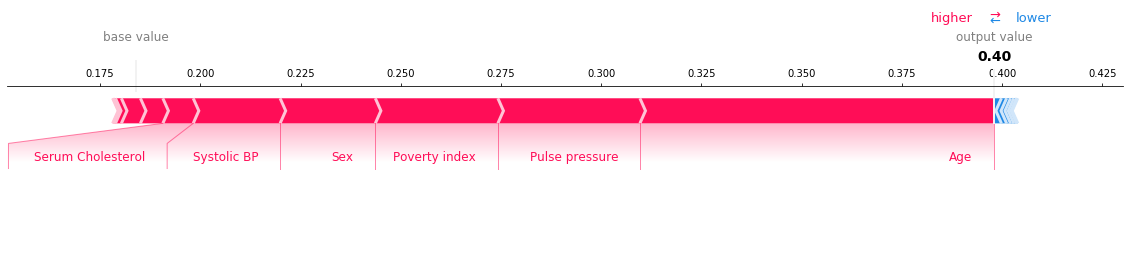

In [104]:
explainer = shap.TreeExplainer(rf_imputed)
i = 0
shap_value = explainer.shap_values(X_test.loc[X_test_risk.index[i], :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

How to read this chart:
- The red sections on the left are features which push the model towards the final prediction in the positive direction (i.e. a higher Age increases the predicted risk).
- The blue sections on the right are features that push the model towards the final prediction in the negative direction (if an increase in a feature leads to a lower risk, it will be shown in blue).
- Note that the exact output of your chart will differ depending on the hyper-parameters that you choose for your model.

We can also use SHAP values to understand the model output in aggregate. Run the next cell to initialize the SHAP values (this may take a few minutes).

In [105]:
shap_values = shap.TreeExplainer(rf_imputed).shap_values(X_test)[1]

Run the next cell to see a summary plot of the SHAP values for each feature on each of the test examples. The colors indicate the value of the feature.

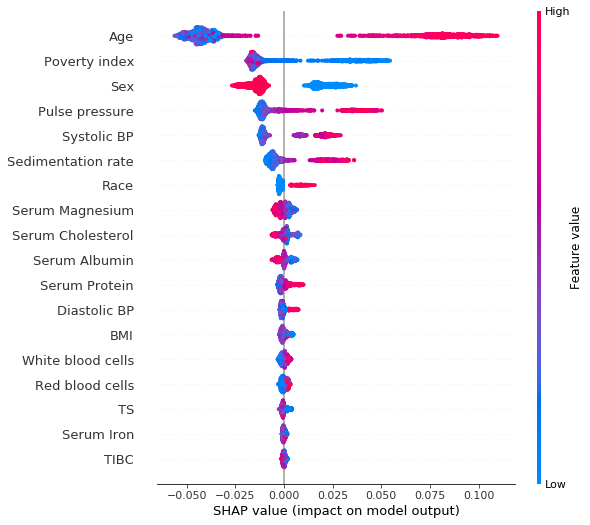

In [106]:
shap.summary_plot(shap_values, X_test)

Clearly we see that being a woman (`sex = 2.0`, as opposed to men for which `sex = 1.0`) has a negative SHAP value, meaning that it reduces the risk of dying within 10 years. High age and high systolic blood pressure have positive SHAP values, and are therefore related to increased mortality. 

You can see how features interact using dependence plots. These plot the SHAP value for a given feature for each data point, and color the points in using the value for another feature. This lets us begin to explain the variation in SHAP value for a single value of the main feature.

Run the next cell to see the interaction between Age and Sex.

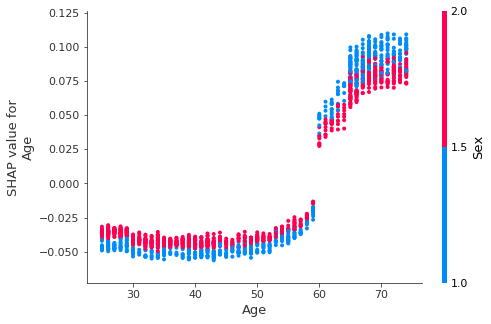

In [107]:
shap.dependence_plot('Age', shap_values, X_test, interaction_index='Sex')

We see that while Age > 50 is generally bad (positive SHAP value), being a woman generally reduces the impact of age. This makes sense since we know that women generally live longer than men.

Let's now look at poverty index and age.

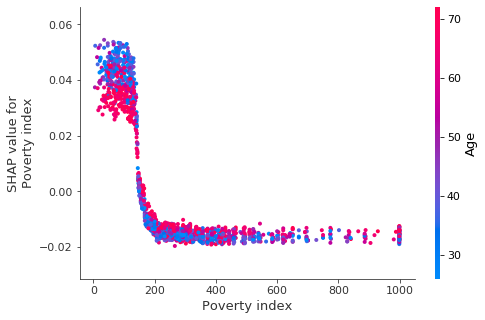

In [108]:
shap.dependence_plot('Poverty index', shap_values, X_test, interaction_index='Age')

We see that the impact of poverty index drops off quickly, and for higher income individuals age begins to explain much of variation in the impact of poverty index.

Try some other pairs and see what other interesting relationships you can find!

# Congratulations!

You have completed the second assignment in Course 2. Along the way you've learned to fit decision trees, random forests, and deal with missing data. Now you're ready to move on to week 3!